# 패키지 다운로드

In [ ]:
# pip install xarray

# 패키지 로딩

In [23]:
import xarray as xr

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

import tensorflow as tf

import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="tensorflow")

# 종속변수(SCTR) 전처리

In [2]:
# nc -> csv 변환
ds = xr.open_dataset('./data/EN.4.2.2_D20_SCTR_f.nc')

df = ds.D20_SCTR.to_dataframe()

df.reset_index(inplace=True)

df.to_csv('./output/SCTR.csv', index=False)

ds.close()

# 종속변수 불러오기

In [40]:
sctr = pd.read_csv("./output/SCTR.csv")

# 날짜 형식 통일
sctr["TIME1"] = pd.to_datetime(sctr["TIME1"])
sctr["TIME1"] = sctr["TIME1"].dt.to_period('M').dt.to_timestamp()

# 날짜 컬럼 이름 변경
sctr = sctr.rename(columns={"TIME1":"Date"})

sctr

Date    D20_SCTR
0   1991-01-01   54.960640
1   1991-02-01   59.899442
2   1991-03-01   70.225124
3   1991-04-01   67.375125
4   1991-05-01   63.783066
..         ...         ...
395 2023-12-01  124.376897
396 2024-01-01  117.300079
397 2024-02-01  121.968669
398 2024-03-01  118.355688
399 2024-04-01  108.767079

[400 rows x 2 columns]

# 독립변수 전처리

## IOD
- WTIO  : 동경 50도 ~ 70도, 남위 10도 ~ 북위 10도에서 SST 편차의 평균 
- SETIO : 동경 90도 ~ 110도, 남위 10도 ~ 적도선에서 SST 편차의 평균
- DMI  = WTIO - SETIO

In [ ]:
# txt -> csv 변환
IOD = pd.read_csv("./data/IOD.txt", sep="\t", encoding="cp949")

# 날짜 형식 통일
IOD['Date'] = pd.to_datetime(IOD['Year'].astype(str) + '-' + IOD['Month'].astype(str) + '-01')
IOD = IOD.drop(["Year", "Month"], axis = 1)
IOD = IOD[["Date", "WTIO", "SETIO"]]

# DMI(Dipole Mode Index) 컬럼 생성
IOD["DMI"] = IOD["WTIO"] - IOD["SETIO"]

IOD.to_csv("./output/IOD.csv", encoding="utf-8-sig", index=False)

In [35]:
IOD = pd.read_csv("./output/IOD.csv")

IOD

Date  WTIO  SETIO   DMI
0    1991-01-01  0.18   0.12  0.06
1    1991-02-01  0.05  -0.04  0.09
2    1991-03-01 -0.04   0.02 -0.06
3    1991-04-01  0.31  -0.45  0.76
4    1991-05-01  0.28  -0.62  0.90
..          ...   ...    ...   ...
395  2023-12-01  1.14  -0.07  1.21
396  2024-01-01  1.18   0.36  0.82
397  2024-02-01  1.22   0.92  0.30
398  2024-03-01  0.95   0.41  0.54
399  2024-04-01  0.95   0.62  0.33

[400 rows x 4 columns]

## ONI

In [32]:
# txt -> csv 변환
ONI = pd.read_csv("./data/ONI.txt", sep="\t", encoding="cp949")

# 날짜 형식 통일
ONI['Date'] = pd.to_datetime(ONI['Date'].astype(str) + '-01')

# ENSO 상태 결정 함수
def determine_enso(oni_values):
    if all(oni >= 0.5 for oni in oni_values):
        return 'El Nino'
    elif all(oni <= -0.5 for oni in oni_values):
        return 'La Nina'
    else:
        return 'Neutral'
    
ONI["ENSO"] = "Neutral"

for i in range(400):
    status = determine_enso(ONI.loc[i : i + 4, "ONI"])
    
    ONI["ENSO"].loc[i + 4] = status    

ONI = ONI[4:].reset_index(drop=True)

ONI.to_csv("./output/ONI.csv", encoding="utf-8-sig", index=False)

In [33]:
ONI = pd.read_csv("./output/ONI.csv")

ONI

Date   ONI     ENSO
0    1991-01-01  0.41  Neutral
1    1991-02-01  0.26  Neutral
2    1991-03-01  0.22  Neutral
3    1991-04-01  0.26  Neutral
4    1991-05-01  0.45  Neutral
..          ...   ...      ...
395  2023-12-01  1.95  El Nino
396  2024-01-01  1.79  El Nino
397  2024-02-01  1.49  El Nino
398  2024-03-01  1.14  El Nino
399  2024-04-01  0.71  El Nino

[400 rows x 3 columns]

## SOI
- 남방진동지수, Darwin - Tahiti 사이의 표준화된 해면기압 차이

In [ ]:
# txt -> csv 변환
SOI = pd.read_csv("./data/SOI.txt", sep="\t", encoding="cp949")

# 날짜 형식 통일
SOI['Date'] = pd.to_datetime(SOI['Date'].astype(str) + '-01')

SOI.to_csv("./output/SOI.csv", encoding="utf-8-sig", index=False)

In [37]:
SOI = pd.read_csv("./output/SOI.csv")

SOI

Date  SOI
0    1991-01-01  0.6
1    1991-02-01  0.3
2    1991-03-01 -0.7
3    1991-04-01 -0.6
4    1991-05-01 -1.0
..          ...  ...
395  2023-12-01 -0.2
396  2024-01-01  0.5
397  2024-02-01 -1.4
398  2024-03-01  0.4
399  2024-04-01 -0.2

[400 rows x 2 columns]

## 독립변수 합치기

In [48]:
df = pd.merge(IOD, ONI, on="Date")
df = pd.merge(df, SOI, on="Date")

df.to_csv("./output/IND.csv", encoding="utf-8-sig", index=False)

# 독립변수 불러오기 & 종속변수 합치기

In [49]:
ind = pd.read_csv("./output/IND.csv")

ind["Date"] = pd.to_datetime(ind["Date"])

data = pd.merge(ind, sctr, on="Date").drop("Date", axis = 1)

data.to_csv("./output/data.csv", encoding="cp949", index=False)

In [2]:
data = pd.read_csv("./output/data.csv")

data

WTIO  SETIO   DMI   ONI     ENSO  SOI    D20_SCTR
0    0.18   0.12  0.06  0.41  Neutral  0.6   54.960640
1    0.05  -0.04  0.09  0.26  Neutral  0.3   59.899442
2   -0.04   0.02 -0.06  0.22  Neutral -0.7   70.225124
3    0.31  -0.45  0.76  0.26  Neutral -0.6   67.375125
4    0.28  -0.62  0.90  0.45  Neutral -1.0   63.783066
..    ...    ...   ...   ...      ...  ...         ...
395  1.14  -0.07  1.21  1.95  El Nino -0.2  124.376897
396  1.18   0.36  0.82  1.79  El Nino  0.5  117.300079
397  1.22   0.92  0.30  1.49  El Nino -1.4  121.968669
398  0.95   0.41  0.54  1.14  El Nino  0.4  118.355688
399  0.95   0.62  0.33  0.71  El Nino -0.2  108.767079

[400 rows x 7 columns]

# 함수 정의

In [3]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size

    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i + target_size])
            
    return np.array(data), np.array(labels)

In [4]:
def label_split(dataset, start_index, end_index, history_size, target_size, step):
    data = []

    start_index = start_index + history_size

    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])
        
    return np.array(data)

In [5]:
def plot_train_history(history, function, val_func):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))
    
    plt.figure(figsize=(12, 8))
    
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    
    plt.xlabel("Epoch")
    plt.ylabel(val_func)
    
    plt.title(f"{function} 손실함수 시각화_{val_func}")
    plt.legend()
    plt.grid()
    
    directory = function.split(",")[0]
    
    plt.savefig(f'./output/{directory}/{function}_{val_func}.png')

    plt.show()

# 하이퍼 파라매터 세팅

In [6]:
# 전체 데이터 길이
total_length = len(data)

# 학습(0.7) - 검증(0.2) - 테스트(0.1) 데이터 분리
TRAIN_SPLIT = int(total_length * 0.7)
VAL_SPLIT = int(total_length * 0.2)
TEST_SPLIT = total_length - TRAIN_SPLIT - VAL_SPLIT

# 12개월 학습 - 12개월 예측
past_history = 12
future_target = 12
STEP = 1

BATCH_SIZE = 16
EPOCHS = 300

tf.random.set_seed(13)

# ENSO Label Encoding

In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

data['ENSO'] = le.fit_transform(data['ENSO'])

# 인코딩 매핑 확인
encoding_map = dict(zip(le.classes_, le.transform(le.classes_)))
print("인코딩 매핑:")
print(encoding_map)

인코딩 매핑:
{'El Nino': 0, 'La Nina': 1, 'Neutral': 2}


# Case1) WTIO, SETIO & 표준화

## 데이터 전처리

In [8]:
case1_df = data[['WTIO', 'SETIO', 'ONI', 'SOI', 'ENSO', 'D20_SCTR']]

case1_dts = case1_df.values
print(case1_dts.shape)

case1_label = case1_dts[ : , 4]
case1_dts = case1_dts[ : , [0, 1, 2, 3, 5]]

case1_mean = case1_dts.mean(axis=0)
case1_std = case1_dts.std(axis=0)
case1_dts = (case1_dts-case1_mean)/case1_std

print(case1_dts.shape)

(400, 6)
(400, 5)


## 데이터 분리

In [9]:
# 학습 데이터
x_train_multi, y_train_multi = multivariate_data(case1_dts, case1_dts[:, -1], 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

x_train_label = label_split(case1_label, 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

# 검증 데이터
x_val_multi, y_val_multi = multivariate_data(case1_dts, case1_dts[:, -1], TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

x_val_label = label_split(case1_label, TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

# 테스트 데이터
x_test_multi, y_test_multi = multivariate_data(case1_dts, case1_dts[:, -1], TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

x_test_label = label_split(case1_label, TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

print(f"학습 데이터 형태: {x_train_multi.shape}")
print(f"학습 타겟데이터 형태: {y_train_multi.shape}")
print(f"학습 라벨데이터 형태: {x_train_label.shape}")
print("--------------------------------")
print(f"검증 데이터 형태: {x_val_multi.shape}")
print(f"검증 타겟데이터 형태: {y_val_multi.shape}")
print(f"검증 라벨데이터 형태: {x_val_label.shape}")
print("--------------------------------")
print(f"테스트 데이터 형태: {x_test_multi.shape}")
print(f"테스트 타겟데이터 형태: {y_test_multi.shape}")
print(f"테스트 라벨데이터 형태: {x_test_label.shape}")
print("--------------------------------")
print('과거 데이터 윈도우 형태: {}'.format(x_train_multi[0].shape))
print('예측 목표 기간 형태: {}'.format(y_train_multi[0].shape))

학습 데이터 형태: (256, 12, 5)
학습 타겟데이터 형태: (256, 12)
학습 라벨데이터 형태: (256, 12)
--------------------------------
검증 데이터 형태: (56, 12, 5)
검증 타겟데이터 형태: (56, 12)
검증 라벨데이터 형태: (56, 12)
--------------------------------
테스트 데이터 형태: (16, 12, 5)
테스트 타겟데이터 형태: (16, 12)
테스트 라벨데이터 형태: (16, 12)
--------------------------------
과거 데이터 윈도우 형태: (12, 5)
예측 목표 기간 형태: (12,)


## 모델 학습

### 단방향 LSTM

Epoch 1/300
16/16 [==============================] - 4s 56ms/step - loss: 22.1571 - val_loss: 21.0773 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 15ms/step - loss: 20.6335 - val_loss: 19.6511 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 13ms/step - loss: 19.1735 - val_loss: 18.2722 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 12ms/step - loss: 17.7674 - val_loss: 16.9429 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 12ms/step - loss: 16.4200 - val_loss: 15.6623 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 12ms/step - loss: 15.1300 - val_loss: 14.4375 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 12ms/step - loss: 13.9188 - val_loss: 13.2765 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 12ms/step - loss: 12.7904 - val_loss: 12.1794 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

16/16 [==============================] - 0s 12ms/step - loss: 0.7449 - val_loss: 0.8611 - lr: 5.0000e-04
Epoch 140/300
16/16 [==============================] - 0s 11ms/step - loss: 0.7337 - val_loss: 0.9227 - lr: 5.0000e-04
Epoch 141/300
16/16 [==============================] - 0s 11ms/step - loss: 0.7245 - val_loss: 0.9102 - lr: 5.0000e-04
Epoch 142/300
16/16 [==============================] - 0s 11ms/step - loss: 0.7210 - val_loss: 0.9061 - lr: 5.0000e-04
Epoch 143/300
16/16 [==============================] - 0s 11ms/step - loss: 0.7215 - val_loss: 0.9078 - lr: 5.0000e-04
Epoch 144/300
13/16 [=======================>......] - ETA: 0s - loss: 0.7108
Epoch 144: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
16/16 [==============================] - 0s 11ms/step - loss: 0.7102 - val_loss: 0.8849 - lr: 5.0000e-04
Epoch 145/300
16/16 [==============================] - 0s 11ms/step - loss: 0.7031 - val_loss: 0.8934 - lr: 2.5000e-04
Epoch 146/300
16/16 [==================

Epoch 200/300
16/16 [==============================] - 0s 11ms/step - loss: 0.5961 - val_loss: 0.7439 - lr: 3.9063e-06
Epoch 201/300
16/16 [==============================] - 0s 11ms/step - loss: 0.5927 - val_loss: 0.7427 - lr: 3.9063e-06
Epoch 202/300
16/16 [==============================] - 0s 11ms/step - loss: 0.5926 - val_loss: 0.7427 - lr: 3.9063e-06
Epoch 203/300
16/16 [==============================] - 0s 11ms/step - loss: 0.5837 - val_loss: 0.7426 - lr: 3.9063e-06
Epoch 204/300
13/16 [=======================>......] - ETA: 0s - loss: 0.5820
Epoch 204: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
16/16 [==============================] - 0s 12ms/step - loss: 0.5837 - val_loss: 0.7437 - lr: 3.9063e-06


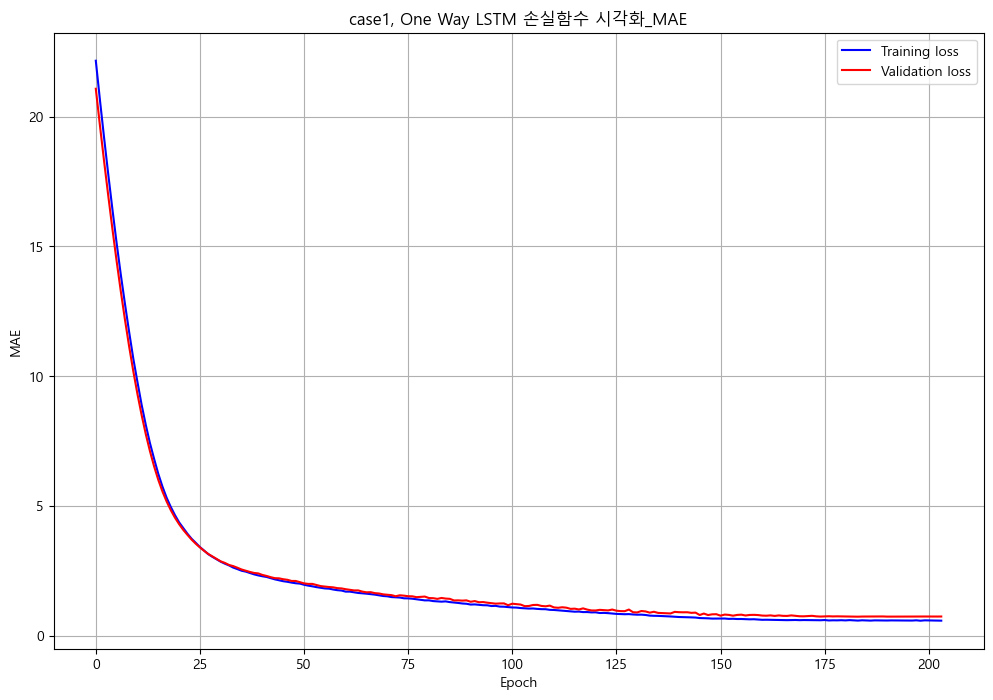

In [11]:
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = LSTM(128, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = LSTM(64, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case1_uni_mae = Model(inputs=[numerical_input, categorical_input], outputs=output)

case1_uni_mae.compile(optimizer=optimizer, loss="mae")

# 모델 학습
case1_uni_mae_history = case1_uni_mae.fit(
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case1_uni_mae_history, "case1, One Way LSTM", "MAE")

# 모델 저장
case1_uni_mae.save("./output/case1/case1_uni_mae.h5")

Epoch 1/300
16/16 [==============================] - 4s 72ms/step - loss: 22.9708 - val_loss: 21.8920 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 13ms/step - loss: 21.8068 - val_loss: 21.0571 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 14ms/step - loss: 20.7604 - val_loss: 20.1834 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 13ms/step - loss: 19.8205 - val_loss: 19.2989 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 14ms/step - loss: 18.8614 - val_loss: 18.4128 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 14ms/step - loss: 17.8958 - val_loss: 17.5324 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 14ms/step - loss: 16.9859 - val_loss: 16.6611 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 13ms/step - loss: 16.0567 - val_loss: 15.8048 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

16/16 [==============================] - 0s 13ms/step - loss: 0.7633 - val_loss: 1.3175 - lr: 2.5000e-04
Epoch 139/300
16/16 [==============================] - 0s 13ms/step - loss: 0.7743 - val_loss: 1.2371 - lr: 2.5000e-04
Epoch 140/300
16/16 [==============================] - 0s 13ms/step - loss: 0.7667 - val_loss: 1.3572 - lr: 2.5000e-04
Epoch 141/300
16/16 [==============================] - ETA: 0s - loss: 0.7594
Epoch 141: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
16/16 [==============================] - 0s 13ms/step - loss: 0.7594 - val_loss: 1.2436 - lr: 2.5000e-04
Epoch 142/300
16/16 [==============================] - 0s 13ms/step - loss: 0.7358 - val_loss: 1.2374 - lr: 1.2500e-04
Epoch 143/300
16/16 [==============================] - 0s 12ms/step - loss: 0.7417 - val_loss: 1.2669 - lr: 1.2500e-04
Epoch 144/300
16/16 [==============================] - 0s 12ms/step - loss: 0.7331 - val_loss: 1.1996 - lr: 1.2500e-04
Epoch 145/300
16/16 [==================

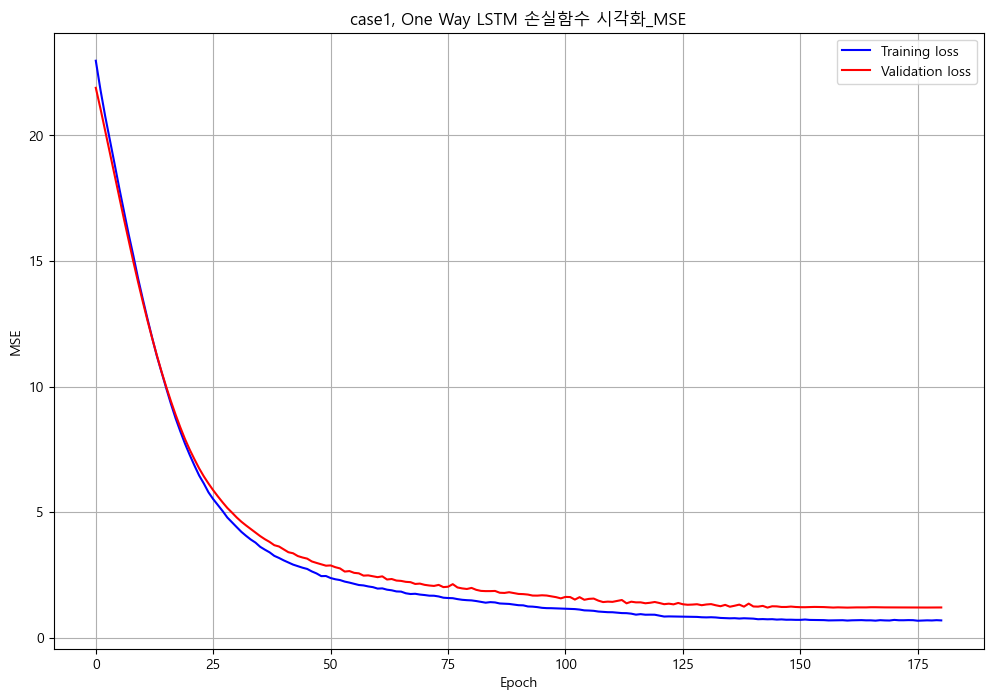

In [12]:
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = LSTM(128, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = LSTM(64, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case1_uni_mse = Model(inputs=[numerical_input, categorical_input], outputs=output)

case1_uni_mse.compile(optimizer=optimizer, loss="mse")

# 모델 학습
case1_uni_mse_history = case1_uni_mse.fit(
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case1_uni_mse_history, "case1, One Way LSTM", "MSE")

# 모델 저장
case1_uni_mse.save("./output/case1/case1_uni_mse.h5")

Epoch 1/300
16/16 [==============================] - 4s 56ms/step - loss: 23.1739 - root_mean_squared_error: 1.3346 - val_loss: 21.9525 - val_root_mean_squared_error: 0.9730 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 12ms/step - loss: 22.0555 - root_mean_squared_error: 1.1876 - val_loss: 21.1827 - val_root_mean_squared_error: 0.9750 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 12ms/step - loss: 21.0978 - root_mean_squared_error: 1.1120 - val_loss: 20.3925 - val_root_mean_squared_error: 0.9775 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 12ms/step - loss: 20.1804 - root_mean_squared_error: 1.0601 - val_loss: 19.5830 - val_root_mean_squared_error: 0.9797 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 12ms/step - loss: 19.3139 - root_mean_squared_error: 1.0372 - val_loss: 18.7649 - val_root_mean_squared_error: 0.9807 - lr: 5.0000e-04
Epoch 6/300
16/16 [==========================

Epoch 44/300
16/16 [==============================] - 0s 12ms/step - loss: 3.1757 - root_mean_squared_error: 0.7604 - val_loss: 3.5405 - val_root_mean_squared_error: 0.9965 - lr: 5.0000e-04
Epoch 45/300
16/16 [==============================] - 0s 12ms/step - loss: 3.0766 - root_mean_squared_error: 0.7553 - val_loss: 3.4695 - val_root_mean_squared_error: 1.0050 - lr: 5.0000e-04
Epoch 46/300
16/16 [==============================] - 0s 12ms/step - loss: 2.9874 - root_mean_squared_error: 0.7532 - val_loss: 3.3677 - val_root_mean_squared_error: 0.9960 - lr: 5.0000e-04
Epoch 47/300
16/16 [==============================] - 0s 12ms/step - loss: 2.9092 - root_mean_squared_error: 0.7562 - val_loss: 3.2887 - val_root_mean_squared_error: 0.9983 - lr: 5.0000e-04
Epoch 48/300
16/16 [==============================] - 0s 12ms/step - loss: 2.8138 - root_mean_squared_error: 0.7479 - val_loss: 3.1859 - val_root_mean_squared_error: 0.9863 - lr: 5.0000e-04
Epoch 49/300
16/16 [==============================

16/16 [==============================] - 0s 11ms/step - loss: 0.8766 - root_mean_squared_error: 0.6926 - val_loss: 1.3223 - val_root_mean_squared_error: 0.9627 - lr: 1.2500e-04
Epoch 129/300
16/16 [==============================] - 0s 12ms/step - loss: 0.8559 - root_mean_squared_error: 0.6792 - val_loss: 1.3949 - val_root_mean_squared_error: 1.0007 - lr: 1.2500e-04
Epoch 130/300
16/16 [==============================] - 0s 12ms/step - loss: 0.8758 - root_mean_squared_error: 0.6951 - val_loss: 1.3122 - val_root_mean_squared_error: 0.9595 - lr: 1.2500e-04
Epoch 131/300
13/16 [=======================>......] - ETA: 0s - loss: 0.8552 - root_mean_squared_error: 0.6816
Epoch 131: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
16/16 [==============================] - 0s 12ms/step - loss: 0.8588 - root_mean_squared_error: 0.6844 - val_loss: 1.3353 - val_root_mean_squared_error: 0.9729 - lr: 1.2500e-04
Epoch 132/300
16/16 [==============================] - 0s 11ms/step - loss:

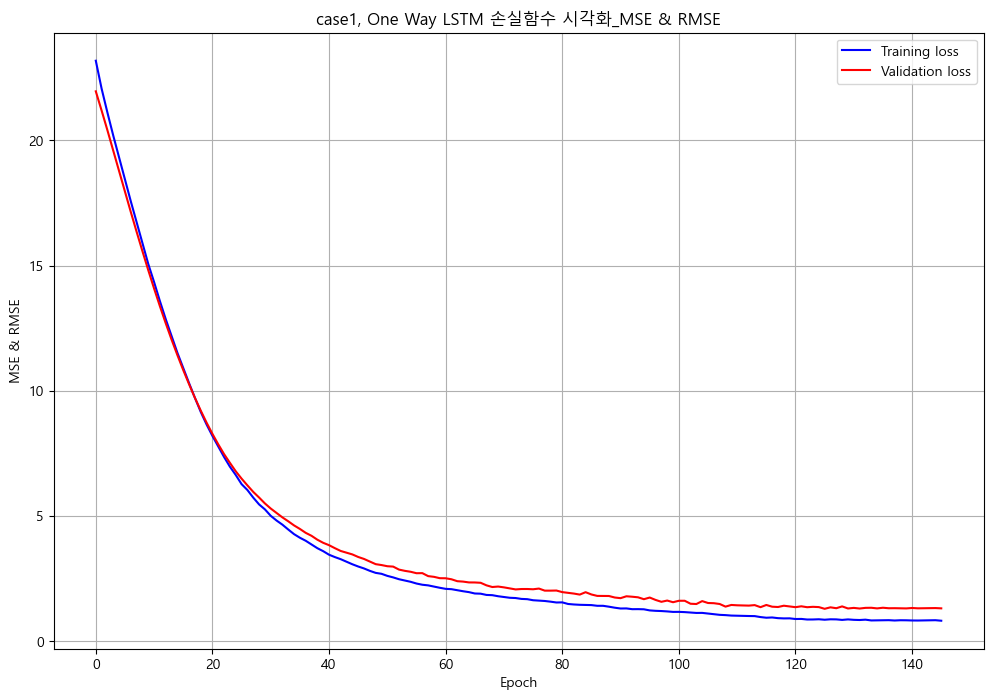

In [13]:
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = LSTM(128, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = LSTM(64, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case1_uni_rmse = Model(inputs=[numerical_input, categorical_input], outputs=output)
case1_uni_rmse.compile(optimizer=optimizer
                       , loss="mse"
                       , metrics=[metrics.RootMeanSquaredError()]
                      )

# 모델 학습
case1_uni_rmse_history = case1_uni_rmse.fit(
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case1_uni_rmse_history, "case1, One Way LSTM", "MSE & RMSE")

# 모델 저장
case1_uni_rmse.save("./output/case1/case1_uni_rmse.h5")

### 양방향 LSTM

Epoch 1/300
16/16 [==============================] - 6s 89ms/step - loss: 54.4926 - val_loss: 51.2914 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 18ms/step - loss: 48.8821 - val_loss: 45.9141 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 18ms/step - loss: 43.6156 - val_loss: 40.8188 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 18ms/step - loss: 38.6289 - val_loss: 36.0764 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 18ms/step - loss: 34.0416 - val_loss: 31.6756 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 18ms/step - loss: 29.7645 - val_loss: 27.6446 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 18ms/step - loss: 25.8963 - val_loss: 23.9878 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 18ms/step - loss: 22.4148 - val_loss: 20.7085 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

16/16 [==============================] - 0s 18ms/step - loss: 0.8564 - val_loss: 0.9797 - lr: 5.0000e-04
Epoch 140/300
16/16 [==============================] - 0s 19ms/step - loss: 0.8399 - val_loss: 0.9709 - lr: 5.0000e-04
Epoch 141/300
16/16 [==============================] - 0s 21ms/step - loss: 0.8328 - val_loss: 0.9251 - lr: 5.0000e-04
Epoch 142/300
16/16 [==============================] - 0s 18ms/step - loss: 0.8304 - val_loss: 0.9692 - lr: 5.0000e-04
Epoch 143/300
16/16 [==============================] - 0s 25ms/step - loss: 0.8081 - val_loss: 0.9774 - lr: 5.0000e-04
Epoch 144/300
16/16 [==============================] - 0s 21ms/step - loss: 0.7992 - val_loss: 0.9836 - lr: 5.0000e-04
Epoch 145/300
16/16 [==============================] - 0s 19ms/step - loss: 0.7890 - val_loss: 0.9227 - lr: 5.0000e-04
Epoch 146/300
16/16 [==============================] - 0s 21ms/step - loss: 0.7639 - val_loss: 0.8822 - lr: 5.0000e-04
Epoch 147/300
16/16 [==============================] - 0s 20ms

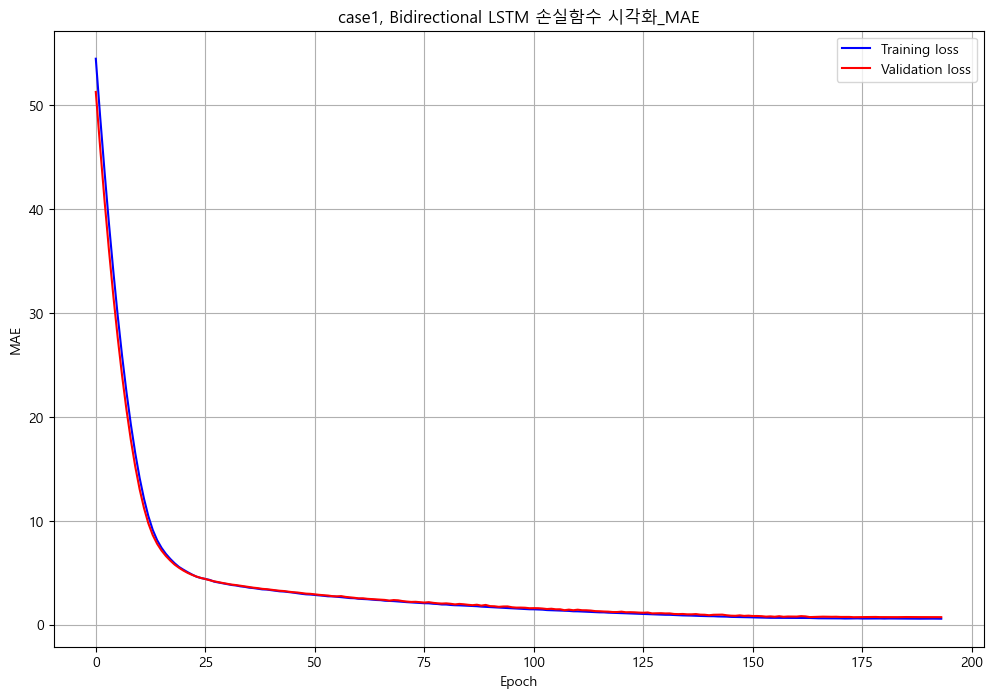

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention, Bidirectional
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = Bidirectional(LSTM(128, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case1_bi_mae = Model(inputs=[numerical_input, categorical_input], outputs=output)
case1_bi_mae.compile(optimizer=optimizer, loss="mae")

# 모델 학습
case1_bi_mae_history = case1_bi_mae.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case1_bi_mae_history, "case1, Bidirectional LSTM", "MAE")

# 모델 저장
case1_bi_mae.save("./output/case1/case1_bi_mae.h5")

Epoch 1/300
16/16 [==============================] - 6s 87ms/step - loss: 56.1416 - val_loss: 53.5577 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 17ms/step - loss: 52.2866 - val_loss: 49.9692 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 17ms/step - loss: 48.4635 - val_loss: 46.3594 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 17ms/step - loss: 44.7046 - val_loss: 42.7759 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 17ms/step - loss: 41.1161 - val_loss: 39.2909 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 17ms/step - loss: 37.5695 - val_loss: 35.9292 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 18ms/step - loss: 34.2780 - val_loss: 32.7149 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 17ms/step - loss: 31.1131 - val_loss: 29.6838 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

16/16 [==============================] - 0s 17ms/step - loss: 1.2677 - val_loss: 1.8206 - lr: 2.5000e-04
Epoch 139/300
16/16 [==============================] - 0s 17ms/step - loss: 1.2550 - val_loss: 1.7404 - lr: 2.5000e-04
Epoch 140/300
16/16 [==============================] - 0s 17ms/step - loss: 1.2529 - val_loss: 1.7736 - lr: 2.5000e-04
Epoch 141/300
16/16 [==============================] - 0s 17ms/step - loss: 1.2357 - val_loss: 1.8242 - lr: 2.5000e-04
Epoch 142/300
16/16 [==============================] - 0s 17ms/step - loss: 1.2341 - val_loss: 1.7449 - lr: 2.5000e-04
Epoch 143/300
16/16 [==============================] - 0s 17ms/step - loss: 1.2334 - val_loss: 1.7344 - lr: 2.5000e-04
Epoch 144/300
16/16 [==============================] - 0s 17ms/step - loss: 1.2081 - val_loss: 1.7204 - lr: 2.5000e-04
Epoch 145/300
16/16 [==============================] - 0s 17ms/step - loss: 1.2133 - val_loss: 1.7404 - lr: 2.5000e-04
Epoch 146/300
16/16 [==============================] - 0s 17ms

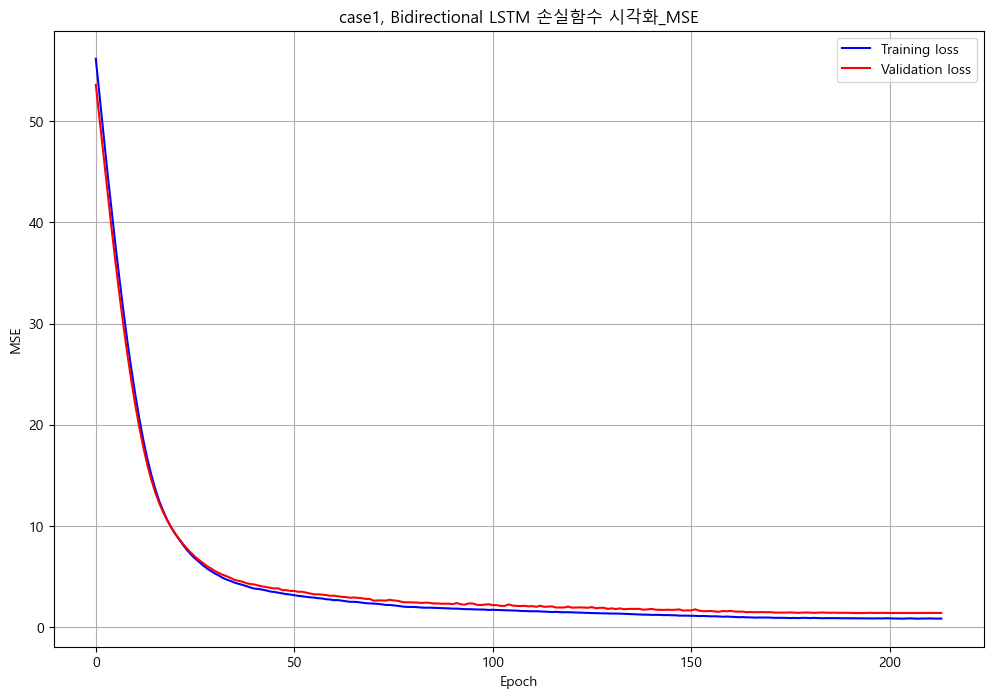

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention, Bidirectional
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = Bidirectional(LSTM(128, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case1_bi_mse = Model(inputs=[numerical_input, categorical_input], outputs=output)
case1_bi_mse.compile(optimizer=optimizer, loss="mse")

# 모델 학습
case1_bi_mse_history = case1_bi_mse.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case1_bi_mse_history, "case1, Bidirectional LSTM", "MSE")

# 모델 저장
case1_bi_mse.save("./output/case1/case1_bi_mse.h5")

Epoch 1/300
16/16 [==============================] - 6s 89ms/step - loss: 55.7140 - root_mean_squared_error: 1.1697 - val_loss: 53.2290 - val_root_mean_squared_error: 0.9757 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 18ms/step - loss: 51.6182 - root_mean_squared_error: 1.0730 - val_loss: 49.3854 - val_root_mean_squared_error: 0.9799 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 19ms/step - loss: 47.6954 - root_mean_squared_error: 1.0370 - val_loss: 45.5467 - val_root_mean_squared_error: 0.9828 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 17ms/step - loss: 43.7896 - root_mean_squared_error: 0.9869 - val_loss: 41.8015 - val_root_mean_squared_error: 0.9866 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 17ms/step - loss: 40.0570 - root_mean_squared_error: 0.9721 - val_loss: 38.1821 - val_root_mean_squared_error: 0.9919 - lr: 5.0000e-04
Epoch 6/300
16/16 [==========================

Epoch 44/300
16/16 [==============================] - 0s 17ms/step - loss: 3.5685 - root_mean_squared_error: 0.7739 - val_loss: 3.9002 - val_root_mean_squared_error: 0.9899 - lr: 5.0000e-04
Epoch 45/300
16/16 [==============================] - 0s 17ms/step - loss: 3.5143 - root_mean_squared_error: 0.7850 - val_loss: 3.8119 - val_root_mean_squared_error: 0.9605 - lr: 5.0000e-04
Epoch 46/300
16/16 [==============================] - 0s 17ms/step - loss: 3.4820 - root_mean_squared_error: 0.7854 - val_loss: 3.8006 - val_root_mean_squared_error: 0.9867 - lr: 5.0000e-04
Epoch 47/300
16/16 [==============================] - 0s 17ms/step - loss: 3.3514 - root_mean_squared_error: 0.7520 - val_loss: 3.6977 - val_root_mean_squared_error: 0.9757 - lr: 5.0000e-04
Epoch 48/300
16/16 [==============================] - 0s 18ms/step - loss: 3.2876 - root_mean_squared_error: 0.7594 - val_loss: 3.6193 - val_root_mean_squared_error: 0.9713 - lr: 5.0000e-04
Epoch 49/300
16/16 [==============================

16/16 [==============================] - 0s 17ms/step - loss: 1.1932 - root_mean_squared_error: 0.7008 - val_loss: 1.6500 - val_root_mean_squared_error: 0.9745 - lr: 1.2500e-04
Epoch 129/300
16/16 [==============================] - 0s 17ms/step - loss: 1.1728 - root_mean_squared_error: 0.6890 - val_loss: 1.7168 - val_root_mean_squared_error: 1.0108 - lr: 1.2500e-04
Epoch 130/300
16/16 [==============================] - 0s 17ms/step - loss: 1.1602 - root_mean_squared_error: 0.6836 - val_loss: 1.6661 - val_root_mean_squared_error: 0.9878 - lr: 1.2500e-04
Epoch 131/300
16/16 [==============================] - 0s 17ms/step - loss: 1.1625 - root_mean_squared_error: 0.6885 - val_loss: 1.6639 - val_root_mean_squared_error: 0.9887 - lr: 1.2500e-04
Epoch 132/300
16/16 [==============================] - 0s 17ms/step - loss: 1.1700 - root_mean_squared_error: 0.6974 - val_loss: 1.7271 - val_root_mean_squared_error: 1.0225 - lr: 1.2500e-04
Epoch 133/300
16/16 [==============================] - 0s 1

Epoch 171/300
16/16 [==============================] - 0s 18ms/step - loss: 0.9860 - root_mean_squared_error: 0.6958 - val_loss: 1.5227 - val_root_mean_squared_error: 1.0110 - lr: 1.2500e-04
Epoch 172/300
16/16 [==============================] - 0s 18ms/step - loss: 0.9591 - root_mean_squared_error: 0.6790 - val_loss: 1.4655 - val_root_mean_squared_error: 0.9850 - lr: 1.2500e-04
Epoch 173/300
16/16 [==============================] - 0s 17ms/step - loss: 0.9601 - root_mean_squared_error: 0.6833 - val_loss: 1.4713 - val_root_mean_squared_error: 0.9902 - lr: 1.2500e-04
Epoch 174/300
16/16 [==============================] - 0s 18ms/step - loss: 0.9750 - root_mean_squared_error: 0.6973 - val_loss: 1.4936 - val_root_mean_squared_error: 1.0038 - lr: 1.2500e-04
Epoch 175/300
16/16 [==============================] - 0s 18ms/step - loss: 0.9435 - root_mean_squared_error: 0.6779 - val_loss: 1.5165 - val_root_mean_squared_error: 1.0173 - lr: 1.2500e-04
Epoch 176/300
16/16 [========================

Epoch 211/300
16/16 [==============================] - 0s 17ms/step - loss: 0.8456 - root_mean_squared_error: 0.6841 - val_loss: 1.3763 - val_root_mean_squared_error: 0.9996 - lr: 7.8125e-06
Epoch 212/300
16/16 [==============================] - 0s 17ms/step - loss: 0.8396 - root_mean_squared_error: 0.6803 - val_loss: 1.3778 - val_root_mean_squared_error: 1.0006 - lr: 7.8125e-06
Epoch 213/300
16/16 [==============================] - 0s 17ms/step - loss: 0.8270 - root_mean_squared_error: 0.6713 - val_loss: 1.3836 - val_root_mean_squared_error: 1.0037 - lr: 7.8125e-06
Epoch 214/300
16/16 [==============================] - 0s 17ms/step - loss: 0.8274 - root_mean_squared_error: 0.6718 - val_loss: 1.3848 - val_root_mean_squared_error: 1.0044 - lr: 7.8125e-06
Epoch 215/300
13/16 [=======================>......] - ETA: 0s - loss: 0.8389 - root_mean_squared_error: 0.6805
Epoch 215: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
16/16 [==============================] - 0s 18

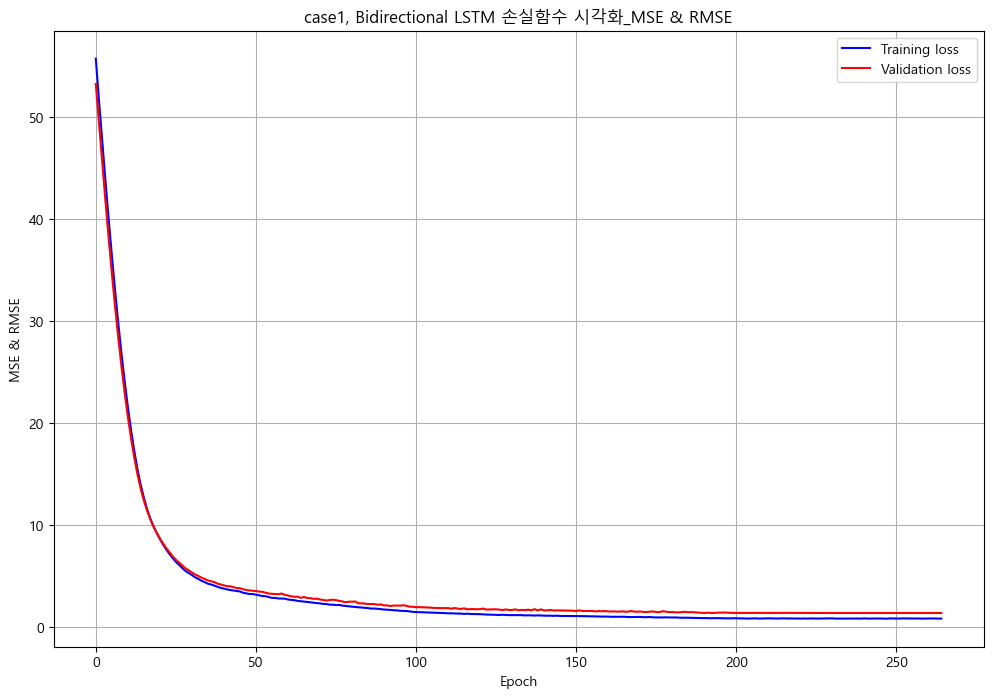

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention, Bidirectional
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = Bidirectional(LSTM(128, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case1_bi_rmse = Model(inputs=[numerical_input, categorical_input], outputs=output)
case1_bi_rmse.compile(optimizer=optimizer
                       , loss="mse"
                       , metrics=[metrics.RootMeanSquaredError()]
                      )

# 모델 학습
case1_bi_rmse_history = case1_bi_rmse.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case1_bi_rmse_history, "case1, Bidirectional LSTM", "MSE & RMSE")

# 모델 저장
case1_bi_rmse.save("./output/case1/case1_bi_rmse.h5")

# Case2) WTIO, SETIO & 로그변환

## 데이터 전처리

### 부호 유지 로그 변환

In [17]:
case2_df = data[['WTIO', 'SETIO', 'ONI', 'SOI', 'ENSO', 'D20_SCTR']]

case2_dts = case2_df.values
print(case2_dts.shape)

case2_label = case2_dts[ : , 4]
case2_dts = case2_dts[ : , [0, 1, 2, 3, 5]]

case2_dts = np.sign(case2_dts) * np.log1p(np.abs(case2_dts))
print(case2_dts.shape)

(400, 6)
(400, 5)


### 데이터 분포 확인

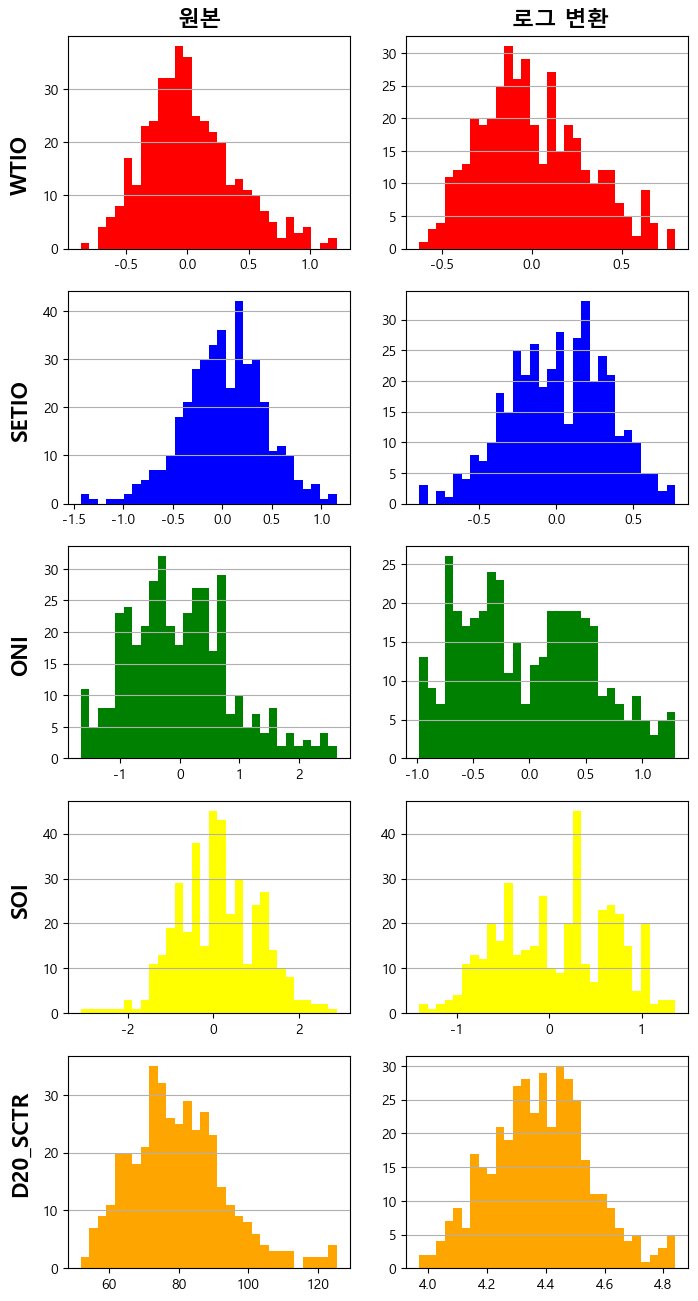

In [18]:
fig, ax = plt.subplots(5, 2, figsize=(8, 16))

i = 0

colors = ["red", "blue", "green", "yellow", "orange"]

for column in ['WTIO', 'SETIO', 'ONI', 'SOI', 'D20_SCTR']:

    ax[i][0].hist(case2_df[column], bins=30, label=column, color=colors[i])
    ax[i][0].grid(axis = "y")
    
    ax[i][1].hist(case2_dts[:, i], bins=30, label=column, color=colors[i])
    ax[i][1].grid(axis = "y")

    i += 1
    
for j, col_title in enumerate(['원본', '로그 변환']):
    fig.text(0.29 + j * 0.45, 0.89, col_title, ha='center', va='center', fontsize=16, fontweight='bold')
    
for i, label in enumerate(['WTIO', 'SETIO', 'ONI', 'SOI', 'D20_SCTR']):
    fig.text(0.08, 0.8 - i * 0.153, label, va='center', ha='right', fontsize=16, rotation=90, fontweight='bold')
    
plt.savefig('./output/Case2_스케일 비교.png', bbox_inches='tight')
plt.show()

## 데이터 분리

In [19]:
# 학습 데이터
x_train_multi, y_train_multi = multivariate_data(case2_dts, case2_dts[:, -1], 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

x_train_label = label_split(case2_label, 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

# 검증 데이터
x_val_multi, y_val_multi = multivariate_data(case2_dts, case2_dts[:, -1], TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

x_val_label = label_split(case2_label, TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

# 테스트 데이터
x_test_multi, y_test_multi = multivariate_data(case2_dts, case2_dts[:, -1], TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

x_test_label = label_split(case2_label, TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

print(f"학습 데이터 형태: {x_train_multi.shape}")
print(f"학습 타겟데이터 형태: {y_train_multi.shape}")
print(f"학습 라벨데이터 형태: {x_train_label.shape}")
print("--------------------------------")
print(f"검증 데이터 형태: {x_val_multi.shape}")
print(f"검증 타겟데이터 형태: {y_val_multi.shape}")
print(f"검증 라벨데이터 형태: {x_val_label.shape}")
print("--------------------------------")
print(f"테스트 데이터 형태: {x_test_multi.shape}")
print(f"테스트 타겟데이터 형태: {y_test_multi.shape}")
print(f"테스트 라벨데이터 형태: {x_test_label.shape}")
print("--------------------------------")
print('과거 데이터 윈도우 형태: {}'.format(x_train_multi[0].shape))
print('예측 목표 기간 형태: {}'.format(y_train_multi[0].shape))

학습 데이터 형태: (256, 12, 5)
학습 타겟데이터 형태: (256, 12)
학습 라벨데이터 형태: (256, 12)
--------------------------------
검증 데이터 형태: (56, 12, 5)
검증 타겟데이터 형태: (56, 12)
검증 라벨데이터 형태: (56, 12)
--------------------------------
테스트 데이터 형태: (16, 12, 5)
테스트 타겟데이터 형태: (16, 12)
테스트 라벨데이터 형태: (16, 12)
--------------------------------
과거 데이터 윈도우 형태: (12, 5)
예측 목표 기간 형태: (12,)


## 모델 학습

### 단방향 LSTM

Epoch 1/300
16/16 [==============================] - 4s 56ms/step - loss: 25.0473 - val_loss: 24.3229 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 12ms/step - loss: 23.0486 - val_loss: 22.5529 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 11ms/step - loss: 21.0934 - val_loss: 20.8217 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 12ms/step - loss: 19.2535 - val_loss: 19.1514 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 12ms/step - loss: 17.4208 - val_loss: 17.5407 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 11ms/step - loss: 15.6550 - val_loss: 16.0103 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 11ms/step - loss: 14.0868 - val_loss: 14.5115 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 11ms/step - loss: 12.5788 - val_loss: 13.1319 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

16/16 [==============================] - 0s 12ms/step - loss: 1.4240 - val_loss: 1.1176 - lr: 3.9063e-06
Epoch 132/300
16/16 [==============================] - 0s 11ms/step - loss: 1.4469 - val_loss: 1.1134 - lr: 3.9063e-06
Epoch 133/300
16/16 [==============================] - 0s 11ms/step - loss: 1.4227 - val_loss: 1.1138 - lr: 3.9063e-06
Epoch 134/300
16/16 [==============================] - 0s 12ms/step - loss: 1.4343 - val_loss: 1.1154 - lr: 3.9063e-06
Epoch 135/300
16/16 [==============================] - 0s 11ms/step - loss: 1.4150 - val_loss: 1.1191 - lr: 3.9063e-06
Epoch 136/300
16/16 [==============================] - 0s 11ms/step - loss: 1.3974 - val_loss: 1.1168 - lr: 3.9063e-06
Epoch 137/300
13/16 [=======================>......] - ETA: 0s - loss: 1.4083
Epoch 137: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
16/16 [==============================] - 0s 11ms/step - loss: 1.3983 - val_loss: 1.1167 - lr: 3.9063e-06
Epoch 138/300
16/16 [=================

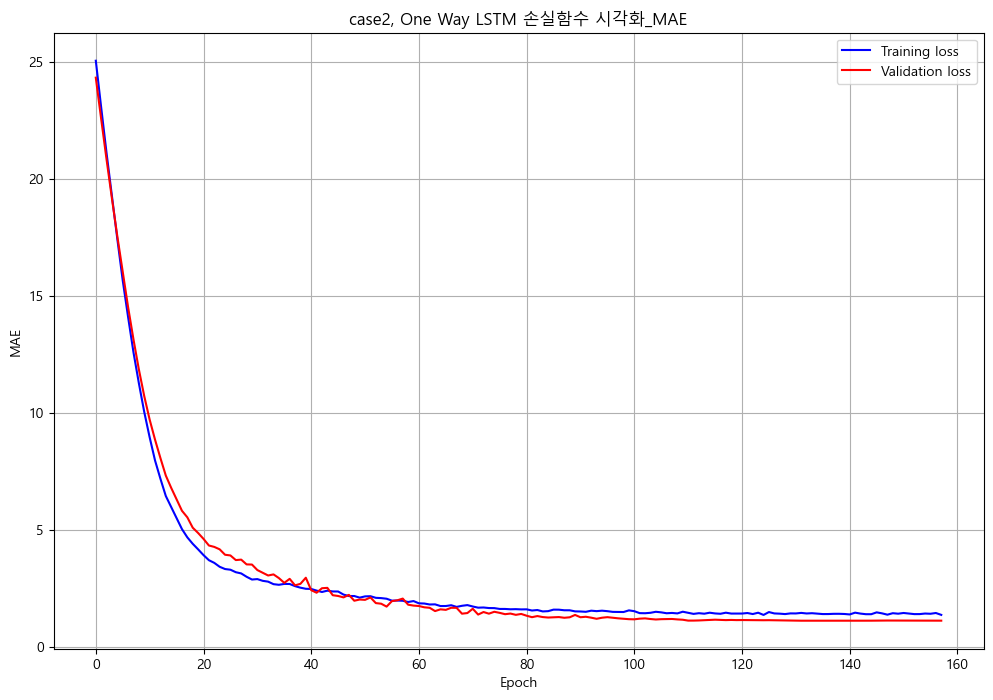

In [20]:
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = LSTM(128, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = LSTM(64, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case2_uni_mae = Model(inputs=[numerical_input, categorical_input], outputs=output)
case2_uni_mae.compile(optimizer=optimizer, loss="mae")

# 모델 학습
case2_uni_mae_history = case2_uni_mae.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case2_uni_mae_history, "case2, One Way LSTM", "MAE")

# 모델 저장
case2_uni_mae.save("./output/case2/case2_uni_mae.h5")

Epoch 1/300
16/16 [==============================] - 4s 55ms/step - loss: 40.7641 - val_loss: 40.3213 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 11ms/step - loss: 38.0813 - val_loss: 39.3991 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 11ms/step - loss: 35.7907 - val_loss: 38.2678 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 11ms/step - loss: 33.4385 - val_loss: 36.8619 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 11ms/step - loss: 31.1701 - val_loss: 35.1425 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 11ms/step - loss: 28.7901 - val_loss: 33.4065 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 11ms/step - loss: 26.7912 - val_loss: 31.4923 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 11ms/step - loss: 24.6588 - val_loss: 29.2181 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

16/16 [==============================] - 0s 11ms/step - loss: 3.0511 - val_loss: 2.4680 - lr: 5.0000e-04
Epoch 71/300
16/16 [==============================] - 0s 11ms/step - loss: 2.8428 - val_loss: 2.4354 - lr: 5.0000e-04
Epoch 72/300
16/16 [==============================] - 0s 11ms/step - loss: 2.7743 - val_loss: 2.3322 - lr: 5.0000e-04
Epoch 73/300
16/16 [==============================] - 0s 11ms/step - loss: 2.6975 - val_loss: 2.2379 - lr: 5.0000e-04
Epoch 74/300
16/16 [==============================] - 0s 11ms/step - loss: 2.6348 - val_loss: 2.1963 - lr: 5.0000e-04
Epoch 75/300
16/16 [==============================] - 0s 11ms/step - loss: 2.5886 - val_loss: 2.2536 - lr: 5.0000e-04
Epoch 76/300
16/16 [==============================] - 0s 11ms/step - loss: 2.4361 - val_loss: 2.0844 - lr: 5.0000e-04
Epoch 77/300
16/16 [==============================] - 0s 12ms/step - loss: 2.3945 - val_loss: 2.0881 - lr: 5.0000e-04
Epoch 78/300
16/16 [==============================] - 0s 11ms/step - 

16/16 [==============================] - 0s 11ms/step - loss: 1.0634 - val_loss: 0.8081 - lr: 2.5000e-04
Epoch 139/300
16/16 [==============================] - 0s 11ms/step - loss: 1.0063 - val_loss: 0.7898 - lr: 2.5000e-04
Epoch 140/300
16/16 [==============================] - 0s 11ms/step - loss: 0.9822 - val_loss: 0.7418 - lr: 2.5000e-04
Epoch 141/300
16/16 [==============================] - 0s 11ms/step - loss: 1.0361 - val_loss: 0.7288 - lr: 2.5000e-04
Epoch 142/300
16/16 [==============================] - 0s 12ms/step - loss: 1.0509 - val_loss: 0.6971 - lr: 2.5000e-04
Epoch 143/300
16/16 [==============================] - 0s 13ms/step - loss: 0.9646 - val_loss: 0.7244 - lr: 2.5000e-04
Epoch 144/300
16/16 [==============================] - 0s 11ms/step - loss: 0.9410 - val_loss: 0.6823 - lr: 2.5000e-04
Epoch 145/300
16/16 [==============================] - 0s 11ms/step - loss: 0.9296 - val_loss: 0.6994 - lr: 2.5000e-04
Epoch 146/300
16/16 [==============================] - 0s 11ms

16/16 [==============================] - 0s 12ms/step - loss: 0.6926 - val_loss: 0.4184 - lr: 1.0000e-06
Epoch 267/300
16/16 [==============================] - 0s 11ms/step - loss: 0.6386 - val_loss: 0.4175 - lr: 1.0000e-06
Epoch 268/300
16/16 [==============================] - 0s 11ms/step - loss: 0.7103 - val_loss: 0.4188 - lr: 1.0000e-06
Epoch 269/300
16/16 [==============================] - 0s 11ms/step - loss: 0.6669 - val_loss: 0.4174 - lr: 1.0000e-06
Epoch 270/300
16/16 [==============================] - 0s 11ms/step - loss: 0.6995 - val_loss: 0.4166 - lr: 1.0000e-06
Epoch 271/300
16/16 [==============================] - 0s 11ms/step - loss: 0.6928 - val_loss: 0.4171 - lr: 1.0000e-06
Epoch 272/300
16/16 [==============================] - 0s 11ms/step - loss: 0.6534 - val_loss: 0.4166 - lr: 1.0000e-06
Epoch 273/300
16/16 [==============================] - 0s 12ms/step - loss: 0.7230 - val_loss: 0.4155 - lr: 1.0000e-06
Epoch 274/300
16/16 [==============================] - 0s 11ms

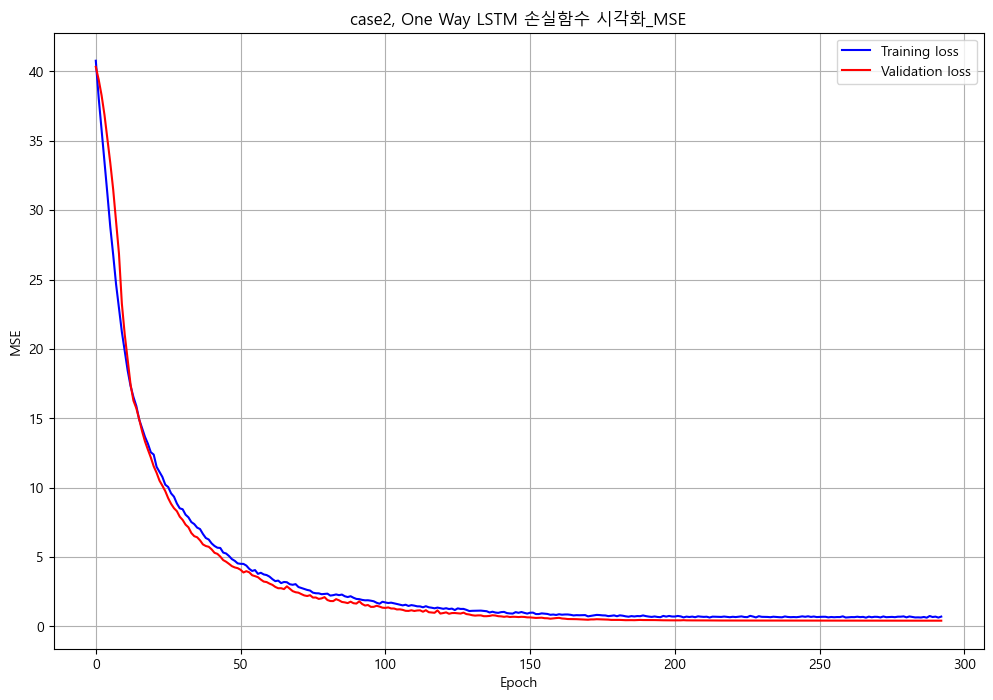

In [21]:
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = LSTM(128, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = LSTM(64, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case2_uni_mse = Model(inputs=[numerical_input, categorical_input], outputs=output)
case2_uni_mse.compile(optimizer=optimizer, loss="mse")

# 모델 학습
case2_uni_mse_history = case2_uni_mse.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case2_uni_mse_history, "case2, One Way LSTM", "MSE")

# 모델 저장
case2_uni_mse.save("./output/case2/case2_uni_mse.h5")

Epoch 1/300
16/16 [==============================] - 4s 76ms/step - loss: 39.3032 - root_mean_squared_error: 4.2147 - val_loss: 40.3488 - val_root_mean_squared_error: 4.3687 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 11ms/step - loss: 36.8770 - root_mean_squared_error: 3.9831 - val_loss: 39.6469 - val_root_mean_squared_error: 4.3504 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 11ms/step - loss: 34.7923 - root_mean_squared_error: 3.7861 - val_loss: 38.6027 - val_root_mean_squared_error: 4.2947 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 11ms/step - loss: 32.6998 - root_mean_squared_error: 3.5787 - val_loss: 37.2583 - val_root_mean_squared_error: 4.2032 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 12ms/step - loss: 30.6022 - root_mean_squared_error: 3.3580 - val_loss: 35.7084 - val_root_mean_squared_error: 4.0846 - lr: 5.0000e-04
Epoch 6/300
16/16 [==========================

Epoch 44/300
16/16 [==============================] - 0s 14ms/step - loss: 5.9280 - root_mean_squared_error: 0.9606 - val_loss: 5.1375 - val_root_mean_squared_error: 0.4635 - lr: 5.0000e-04
Epoch 45/300
16/16 [==============================] - 0s 12ms/step - loss: 5.5983 - root_mean_squared_error: 0.8533 - val_loss: 4.9652 - val_root_mean_squared_error: 0.4225 - lr: 5.0000e-04
Epoch 46/300
16/16 [==============================] - 0s 12ms/step - loss: 5.5253 - root_mean_squared_error: 0.9032 - val_loss: 4.8104 - val_root_mean_squared_error: 0.4171 - lr: 5.0000e-04
Epoch 47/300
16/16 [==============================] - 0s 12ms/step - loss: 5.2236 - root_mean_squared_error: 0.8087 - val_loss: 4.6180 - val_root_mean_squared_error: 0.3615 - lr: 5.0000e-04
Epoch 48/300
16/16 [==============================] - 0s 12ms/step - loss: 5.0582 - root_mean_squared_error: 0.7989 - val_loss: 4.5067 - val_root_mean_squared_error: 0.3908 - lr: 5.0000e-04
Epoch 49/300
16/16 [==============================

16/16 [==============================] - 0s 11ms/step - loss: 1.3666 - root_mean_squared_error: 0.6065 - val_loss: 1.1649 - val_root_mean_squared_error: 0.4136 - lr: 1.2500e-04
Epoch 129/300
16/16 [==============================] - 0s 11ms/step - loss: 1.3915 - root_mean_squared_error: 0.6334 - val_loss: 1.1400 - val_root_mean_squared_error: 0.3882 - lr: 1.2500e-04
Epoch 130/300
16/16 [==============================] - 0s 11ms/step - loss: 1.3993 - root_mean_squared_error: 0.6409 - val_loss: 1.1564 - val_root_mean_squared_error: 0.4097 - lr: 1.2500e-04
Epoch 131/300
16/16 [==============================] - 0s 11ms/step - loss: 1.3822 - root_mean_squared_error: 0.6295 - val_loss: 1.0947 - val_root_mean_squared_error: 0.3368 - lr: 1.2500e-04
Epoch 132/300
16/16 [==============================] - 0s 11ms/step - loss: 1.3904 - root_mean_squared_error: 0.6428 - val_loss: 1.0732 - val_root_mean_squared_error: 0.3184 - lr: 1.2500e-04
Epoch 133/300
16/16 [==============================] - 0s 1

16/16 [==============================] - 0s 11ms/step - loss: 1.1860 - root_mean_squared_error: 0.6218 - val_loss: 0.8859 - val_root_mean_squared_error: 0.2993 - lr: 6.2500e-05
Epoch 171/300
16/16 [==============================] - 0s 11ms/step - loss: 1.1450 - root_mean_squared_error: 0.5919 - val_loss: 0.8833 - val_root_mean_squared_error: 0.3007 - lr: 6.2500e-05
Epoch 172/300
16/16 [==============================] - 0s 11ms/step - loss: 1.1355 - root_mean_squared_error: 0.5865 - val_loss: 0.8906 - val_root_mean_squared_error: 0.3161 - lr: 6.2500e-05
Epoch 173/300
16/16 [==============================] - 0s 11ms/step - loss: 1.1451 - root_mean_squared_error: 0.5971 - val_loss: 0.8896 - val_root_mean_squared_error: 0.3221 - lr: 6.2500e-05
Epoch 174/300
16/16 [==============================] - 0s 11ms/step - loss: 1.1490 - root_mean_squared_error: 0.6035 - val_loss: 0.8837 - val_root_mean_squared_error: 0.3140 - lr: 6.2500e-05
Epoch 175/300
16/16 [==============================] - 0s 1

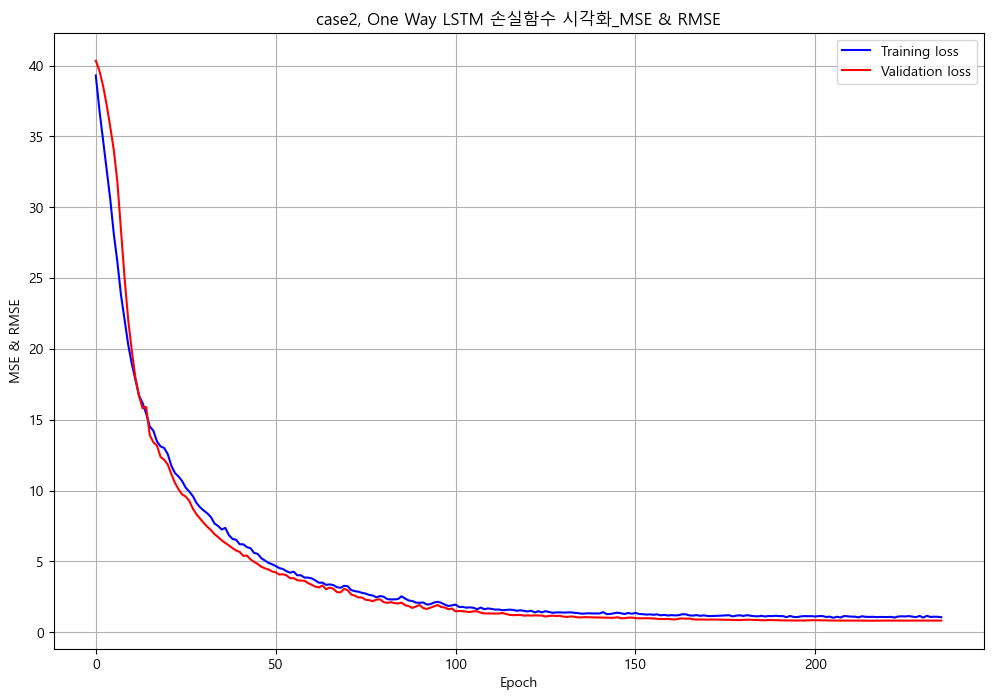

In [22]:
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = LSTM(128, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = LSTM(64, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case2_uni_rmse = Model(inputs=[numerical_input, categorical_input], outputs=output)
case2_uni_rmse.compile(optimizer=optimizer
                       , loss="mse"
                       , metrics=[metrics.RootMeanSquaredError()]
                      )

# 모델 학습
case2_uni_rmse_history = case2_uni_rmse.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case2_uni_rmse_history, "case2, One Way LSTM", "MSE & RMSE")

# 모델 저장
case2_uni_rmse.save("./output/case2/case2_uni_rmse.h5")

### 양방향 LSTM

Epoch 1/300
16/16 [==============================] - 6s 88ms/step - loss: 57.8808 - val_loss: 54.6648 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 17ms/step - loss: 51.6780 - val_loss: 48.9214 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 17ms/step - loss: 45.9477 - val_loss: 43.5157 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 17ms/step - loss: 40.5944 - val_loss: 38.5021 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 17ms/step - loss: 35.5833 - val_loss: 33.8790 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 17ms/step - loss: 31.0013 - val_loss: 29.6293 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 17ms/step - loss: 26.8152 - val_loss: 25.7560 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 17ms/step - loss: 23.0144 - val_loss: 22.2549 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

16/16 [==============================] - 0s 16ms/step - loss: 1.4832 - val_loss: 1.2419 - lr: 1.5625e-05
Epoch 134/300
16/16 [==============================] - 0s 16ms/step - loss: 1.5081 - val_loss: 1.2481 - lr: 1.5625e-05
Epoch 135/300
16/16 [==============================] - 0s 17ms/step - loss: 1.4645 - val_loss: 1.2563 - lr: 1.5625e-05
Epoch 136/300
16/16 [==============================] - 0s 16ms/step - loss: 1.4373 - val_loss: 1.2579 - lr: 1.5625e-05
Epoch 137/300
13/16 [=======================>......] - ETA: 0s - loss: 1.4572
Epoch 137: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
16/16 [==============================] - 0s 16ms/step - loss: 1.4600 - val_loss: 1.2489 - lr: 1.5625e-05
Epoch 138/300
16/16 [==============================] - 0s 16ms/step - loss: 1.4489 - val_loss: 1.2473 - lr: 7.8125e-06
Epoch 139/300
16/16 [==============================] - 0s 17ms/step - loss: 1.4437 - val_loss: 1.2374 - lr: 7.8125e-06
Epoch 140/300
16/16 [==================

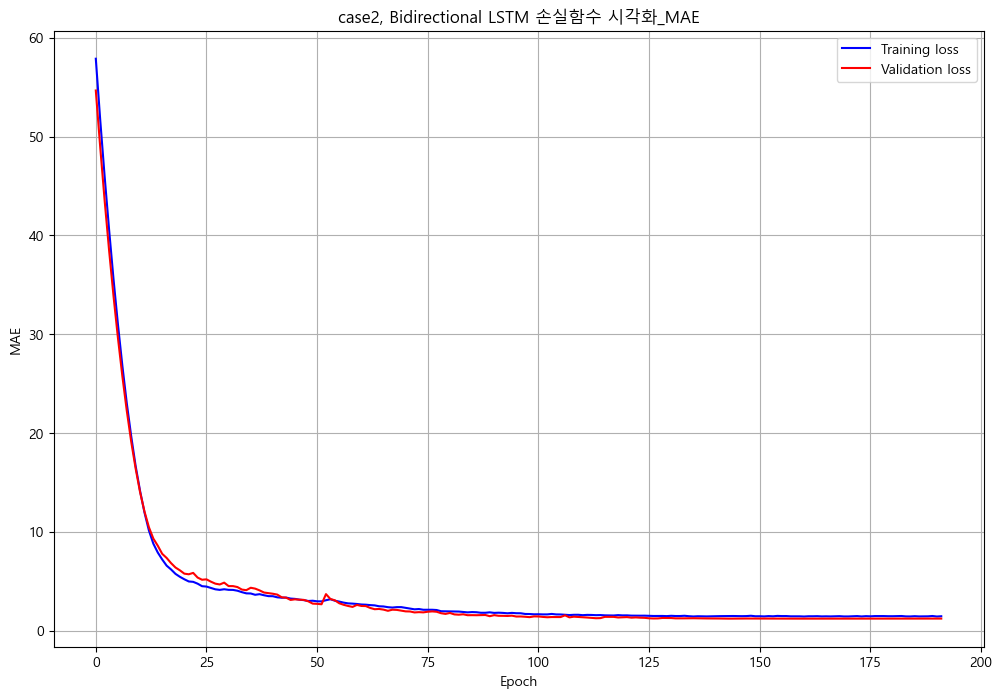

In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention, Bidirectional
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = Bidirectional(LSTM(128, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case2_bi_mae = Model(inputs=[numerical_input, categorical_input], outputs=output)
case2_bi_mae.compile(optimizer=optimizer, loss="mae")

# 모델 학습
case2_bi_mae_history = case2_bi_mae.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case2_bi_mae_history, "case2, Bidirectional LSTM", "MAE")

case2_bi_mae.save("./output/case2/case2_bi_mae.h5")

Epoch 1/300
16/16 [==============================] - 6s 89ms/step - loss: 73.3770 - val_loss: 73.4175 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 17ms/step - loss: 69.5220 - val_loss: 71.2365 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 17ms/step - loss: 65.8375 - val_loss: 68.6918 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 17ms/step - loss: 61.9942 - val_loss: 66.0720 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 17ms/step - loss: 58.1970 - val_loss: 63.3613 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 17ms/step - loss: 54.0665 - val_loss: 60.6006 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 17ms/step - loss: 50.2076 - val_loss: 57.0729 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 17ms/step - loss: 46.2217 - val_loss: 53.7090 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

Epoch 70/300
16/16 [==============================] - 0s 17ms/step - loss: 5.7124 - val_loss: 5.2280 - lr: 5.0000e-04
Epoch 71/300
16/16 [==============================] - 0s 16ms/step - loss: 5.5464 - val_loss: 5.4422 - lr: 5.0000e-04
Epoch 72/300
16/16 [==============================] - 0s 17ms/step - loss: 5.1963 - val_loss: 5.1162 - lr: 5.0000e-04
Epoch 73/300
16/16 [==============================] - 0s 17ms/step - loss: 5.1379 - val_loss: 4.9059 - lr: 5.0000e-04
Epoch 74/300
16/16 [==============================] - 0s 17ms/step - loss: 4.9835 - val_loss: 4.8846 - lr: 5.0000e-04
Epoch 75/300
16/16 [==============================] - 0s 17ms/step - loss: 4.8147 - val_loss: 4.6777 - lr: 5.0000e-04
Epoch 76/300
16/16 [==============================] - 0s 18ms/step - loss: 4.6939 - val_loss: 4.6990 - lr: 5.0000e-04
Epoch 77/300
16/16 [==============================] - 0s 17ms/step - loss: 4.7413 - val_loss: 4.4696 - lr: 5.0000e-04
Epoch 78/300
16/16 [==============================] - 0s

Epoch 138/300
16/16 [==============================] - 0s 17ms/step - loss: 2.1851 - val_loss: 1.8785 - lr: 2.5000e-04
Epoch 139/300
16/16 [==============================] - 0s 17ms/step - loss: 2.1180 - val_loss: 1.7945 - lr: 2.5000e-04
Epoch 140/300
16/16 [==============================] - 0s 17ms/step - loss: 2.1128 - val_loss: 1.7923 - lr: 2.5000e-04
Epoch 141/300
16/16 [==============================] - 0s 17ms/step - loss: 2.0745 - val_loss: 1.7726 - lr: 2.5000e-04
Epoch 142/300
16/16 [==============================] - 0s 16ms/step - loss: 2.1154 - val_loss: 1.7854 - lr: 2.5000e-04
Epoch 143/300
16/16 [==============================] - 0s 16ms/step - loss: 2.1404 - val_loss: 1.7917 - lr: 2.5000e-04
Epoch 144/300
16/16 [==============================] - 0s 17ms/step - loss: 2.0918 - val_loss: 1.7279 - lr: 2.5000e-04
Epoch 145/300
16/16 [==============================] - 0s 17ms/step - loss: 2.0321 - val_loss: 1.7013 - lr: 2.5000e-04
Epoch 146/300
16/16 [===========================

Epoch 207/300
16/16 [==============================] - 0s 17ms/step - loss: 1.1292 - val_loss: 0.8922 - lr: 2.5000e-04
Epoch 208/300
16/16 [==============================] - 0s 17ms/step - loss: 1.0726 - val_loss: 0.8687 - lr: 2.5000e-04
Epoch 209/300
16/16 [==============================] - 0s 17ms/step - loss: 1.1530 - val_loss: 0.8551 - lr: 2.5000e-04
Epoch 210/300
16/16 [==============================] - 0s 17ms/step - loss: 1.1508 - val_loss: 0.8543 - lr: 2.5000e-04
Epoch 211/300
16/16 [==============================] - 0s 17ms/step - loss: 1.1253 - val_loss: 0.8389 - lr: 2.5000e-04
Epoch 212/300
16/16 [==============================] - 0s 17ms/step - loss: 1.1301 - val_loss: 0.8286 - lr: 2.5000e-04
Epoch 213/300
16/16 [==============================] - 0s 16ms/step - loss: 1.0657 - val_loss: 0.8383 - lr: 2.5000e-04
Epoch 214/300
16/16 [==============================] - 0s 16ms/step - loss: 1.1296 - val_loss: 0.8303 - lr: 2.5000e-04
Epoch 215/300
16/16 [===========================

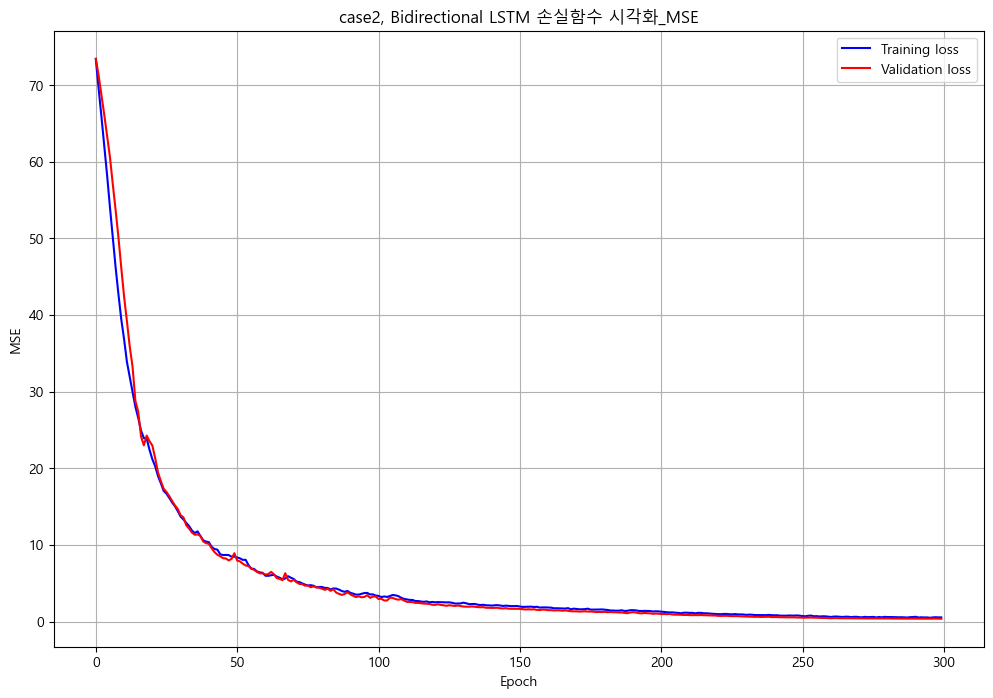

In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention, Bidirectional
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = Bidirectional(LSTM(128, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case2_bi_mse = Model(inputs=[numerical_input, categorical_input], outputs=output)
case2_bi_mse.compile(optimizer=optimizer, loss="mse")

# 모델 학습
case2_bi_mse_history = case2_bi_mse.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case2_bi_mse_history, "case2, Bidirectional LSTM", "MSE")

# case2_bi_label.save("./output/case2/case2_lstm_bi_label_mae.h5")
case2_bi_mse.save("./output/case2/case2_bi_mse.h5")

Epoch 1/300
16/16 [==============================] - 6s 89ms/step - loss: 76.6606 - root_mean_squared_error: 4.6210 - val_loss: 73.4789 - val_root_mean_squared_error: 4.3785 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 17ms/step - loss: 72.9419 - root_mean_squared_error: 4.4210 - val_loss: 71.2692 - val_root_mean_squared_error: 4.3499 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 17ms/step - loss: 69.3111 - root_mean_squared_error: 4.2329 - val_loss: 68.8311 - val_root_mean_squared_error: 4.3048 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 17ms/step - loss: 66.2069 - root_mean_squared_error: 4.1103 - val_loss: 66.1891 - val_root_mean_squared_error: 4.2431 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 17ms/step - loss: 62.6060 - root_mean_squared_error: 3.9274 - val_loss: 63.3554 - val_root_mean_squared_error: 4.1613 - lr: 5.0000e-04
Epoch 6/300
16/16 [==========================

Epoch 44/300
16/16 [==============================] - 0s 17ms/step - loss: 7.2722 - root_mean_squared_error: 0.8845 - val_loss: 7.6547 - val_root_mean_squared_error: 1.1155 - lr: 5.0000e-04
Epoch 45/300
16/16 [==============================] - 0s 17ms/step - loss: 7.0850 - root_mean_squared_error: 0.8725 - val_loss: 7.5739 - val_root_mean_squared_error: 1.1736 - lr: 5.0000e-04
Epoch 46/300
16/16 [==============================] - 0s 17ms/step - loss: 7.0415 - root_mean_squared_error: 0.9685 - val_loss: 6.7998 - val_root_mean_squared_error: 0.9018 - lr: 5.0000e-04
Epoch 47/300
16/16 [==============================] - 0s 17ms/step - loss: 6.5889 - root_mean_squared_error: 0.8530 - val_loss: 6.8425 - val_root_mean_squared_error: 1.0556 - lr: 5.0000e-04
Epoch 48/300
16/16 [==============================] - 0s 17ms/step - loss: 6.4336 - root_mean_squared_error: 0.8981 - val_loss: 6.7221 - val_root_mean_squared_error: 1.0938 - lr: 5.0000e-04
Epoch 49/300
16/16 [==============================

16/16 [==============================] - 0s 17ms/step - loss: 2.0352 - root_mean_squared_error: 0.6860 - val_loss: 1.6383 - val_root_mean_squared_error: 0.2753 - lr: 3.1250e-05
Epoch 127/300
16/16 [==============================] - 0s 17ms/step - loss: 2.0375 - root_mean_squared_error: 0.6908 - val_loss: 1.6787 - val_root_mean_squared_error: 0.3474 - lr: 3.1250e-05
Epoch 128/300
16/16 [==============================] - 0s 17ms/step - loss: 2.0440 - root_mean_squared_error: 0.6989 - val_loss: 1.6674 - val_root_mean_squared_error: 0.3330 - lr: 3.1250e-05
Epoch 129/300
16/16 [==============================] - 0s 17ms/step - loss: 2.0928 - root_mean_squared_error: 0.7323 - val_loss: 1.6512 - val_root_mean_squared_error: 0.3074 - lr: 3.1250e-05
Epoch 130/300
16/16 [==============================] - 0s 17ms/step - loss: 2.0342 - root_mean_squared_error: 0.6916 - val_loss: 1.6503 - val_root_mean_squared_error: 0.3098 - lr: 3.1250e-05
Epoch 131/300
13/16 [=======================>......] - ETA:

16/16 [==============================] - 0s 17ms/step - loss: 2.0026 - root_mean_squared_error: 0.7120 - val_loss: 1.5534 - val_root_mean_squared_error: 0.2406 - lr: 1.0000e-06
Epoch 208/300
16/16 [==============================] - 0s 17ms/step - loss: 1.9060 - root_mean_squared_error: 0.6408 - val_loss: 1.5521 - val_root_mean_squared_error: 0.2384 - lr: 1.0000e-06
Epoch 209/300
16/16 [==============================] - 0s 17ms/step - loss: 2.1066 - root_mean_squared_error: 0.7819 - val_loss: 1.5555 - val_root_mean_squared_error: 0.2452 - lr: 1.0000e-06
Epoch 210/300
16/16 [==============================] - 0s 17ms/step - loss: 2.0240 - root_mean_squared_error: 0.7271 - val_loss: 1.5530 - val_root_mean_squared_error: 0.2402 - lr: 1.0000e-06
Epoch 211/300
16/16 [==============================] - 0s 17ms/step - loss: 1.9345 - root_mean_squared_error: 0.6628 - val_loss: 1.5517 - val_root_mean_squared_error: 0.2375 - lr: 1.0000e-06
Epoch 212/300
16/16 [==============================] - 0s 1

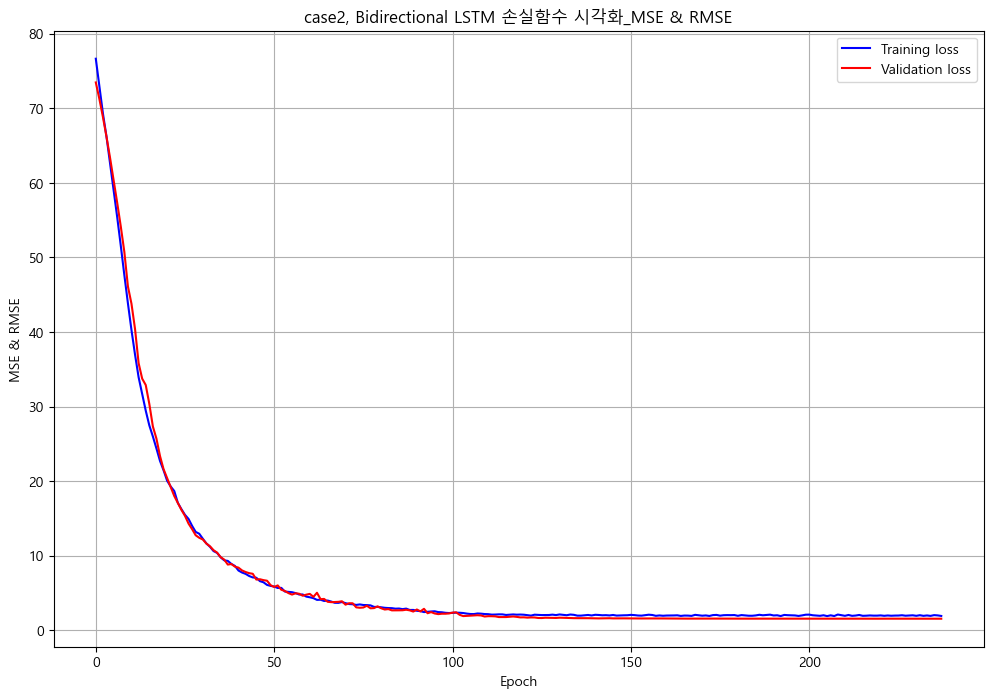

In [25]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention, Bidirectional
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = Bidirectional(LSTM(128, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case2_bi_rmse = Model(inputs=[numerical_input, categorical_input], outputs=output)
case2_bi_rmse.compile(optimizer=optimizer
                       , loss="mse"
                       , metrics=[metrics.RootMeanSquaredError()]
                      )

# 모델 학습
case2_bi_rmse_history = case2_bi_rmse.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case2_bi_rmse_history, "case2, Bidirectional LSTM", "MSE & RMSE")

# case2_bi_label.save("./output/case2/case2_lstm_bi_label_mae.h5")
# case2_bi_label.save("./output/case2/case2_lstm_bi_label_mse.h5")
case2_bi_rmse.save("./output/case2/case2_bi_rmse.h5")

# Case3) DMI & 표준화

## 데이터 전처리

In [26]:
case3_df = data[['DMI', 'ONI', 'SOI', 'ENSO', 'D20_SCTR']]

case3_dts = case3_df.values
print(case3_dts.shape)

case3_label = case3_dts[ : , 3]
case3_dts = case3_dts[ : , [0, 1, 2, 4]]

case3_mean = case3_dts.mean(axis=0)
case3_std = case3_dts.std(axis=0)
case3_dts = (case3_dts-case3_mean)/case3_std

print(case3_dts.shape)

(400, 5)
(400, 4)


## 데이터 분리

In [27]:
# 학습 데이터
x_train_multi, y_train_multi = multivariate_data(case3_dts, case3_dts[:, -1], 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

x_train_label = label_split(case3_label, 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

# 검증 데이터
x_val_multi, y_val_multi = multivariate_data(case3_dts, case3_dts[:, -1], TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

x_val_label = label_split(case3_label, TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

# 테스트 데이터
x_test_multi, y_test_multi = multivariate_data(case3_dts, case3_dts[:, -1], TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

x_test_label = label_split(case3_label, TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

print(f"학습 데이터 형태: {x_train_multi.shape}")
print(f"학습 타겟데이터 형태: {y_train_multi.shape}")
print(f"학습 라벨데이터 형태: {x_train_label.shape}")
print("--------------------------------")
print(f"검증 데이터 형태: {x_val_multi.shape}")
print(f"검증 타겟데이터 형태: {y_val_multi.shape}")
print(f"검증 라벨데이터 형태: {x_val_label.shape}")
print("--------------------------------")
print(f"테스트 데이터 형태: {x_test_multi.shape}")
print(f"테스트 타겟데이터 형태: {y_test_multi.shape}")
print(f"테스트 라벨데이터 형태: {x_test_label.shape}")
print("--------------------------------")
print('과거 데이터 윈도우 형태: {}'.format(x_train_multi[0].shape))
print('예측 목표 기간 형태: {}'.format(y_train_multi[0].shape))

학습 데이터 형태: (256, 12, 4)
학습 타겟데이터 형태: (256, 12)
학습 라벨데이터 형태: (256, 12)
--------------------------------
검증 데이터 형태: (56, 12, 4)
검증 타겟데이터 형태: (56, 12)
검증 라벨데이터 형태: (56, 12)
--------------------------------
테스트 데이터 형태: (16, 12, 4)
테스트 타겟데이터 형태: (16, 12)
테스트 라벨데이터 형태: (16, 12)
--------------------------------
과거 데이터 윈도우 형태: (12, 4)
예측 목표 기간 형태: (12,)


## 모델 학습

### 단방향 LSTM

Epoch 1/300
16/16 [==============================] - 4s 55ms/step - loss: 21.8353 - val_loss: 20.7444 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 11ms/step - loss: 20.1897 - val_loss: 19.2346 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 11ms/step - loss: 18.6613 - val_loss: 17.7731 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 11ms/step - loss: 17.1886 - val_loss: 16.3748 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 11ms/step - loss: 15.8077 - val_loss: 15.0481 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 11ms/step - loss: 14.4821 - val_loss: 13.7954 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 11ms/step - loss: 13.2568 - val_loss: 12.6161 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 11ms/step - loss: 12.1067 - val_loss: 11.5205 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

16/16 [==============================] - 0s 11ms/step - loss: 0.7523 - val_loss: 0.9209 - lr: 5.0000e-04
Epoch 140/300
16/16 [==============================] - 0s 11ms/step - loss: 0.7571 - val_loss: 0.9438 - lr: 5.0000e-04
Epoch 141/300
16/16 [==============================] - 0s 11ms/step - loss: 0.7329 - val_loss: 0.8830 - lr: 5.0000e-04
Epoch 142/300
16/16 [==============================] - 0s 11ms/step - loss: 0.7269 - val_loss: 0.9219 - lr: 5.0000e-04
Epoch 143/300
16/16 [==============================] - 0s 11ms/step - loss: 0.7305 - val_loss: 1.0098 - lr: 5.0000e-04
Epoch 144/300
16/16 [==============================] - 0s 11ms/step - loss: 0.7299 - val_loss: 0.9629 - lr: 5.0000e-04
Epoch 145/300
16/16 [==============================] - 0s 11ms/step - loss: 0.7240 - val_loss: 0.9505 - lr: 5.0000e-04
Epoch 146/300
13/16 [=======================>......] - ETA: 0s - loss: 0.6920
Epoch 146: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
16/16 [==================

Epoch 201/300
16/16 [==============================] - 0s 11ms/step - loss: 0.5955 - val_loss: 0.7932 - lr: 7.8125e-06
Epoch 202/300
13/16 [=======================>......] - ETA: 0s - loss: 0.6028
Epoch 202: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
16/16 [==============================] - 0s 11ms/step - loss: 0.6060 - val_loss: 0.7939 - lr: 7.8125e-06


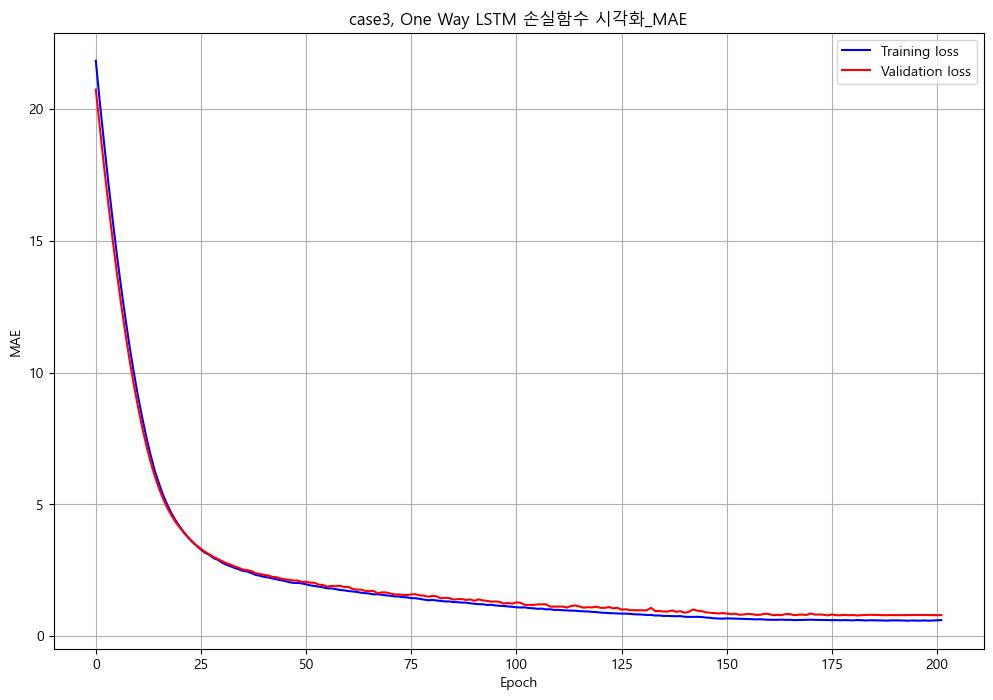

In [28]:
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = LSTM(128, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = LSTM(64, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case3_uni_mae = Model(inputs=[numerical_input, categorical_input], outputs=output)
case3_uni_mae.compile(optimizer=optimizer, loss="mae")

# 모델 학습
case3_uni_mae_history = case3_uni_mae.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case3_uni_mae_history, "case3, One Way LSTM" ,"MAE")

# 모델 저장
case3_uni_mae.save("./output/case3/case3_uni_mae.h5")

Epoch 1/300
16/16 [==============================] - 4s 55ms/step - loss: 22.9349 - val_loss: 21.7933 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 11ms/step - loss: 21.8498 - val_loss: 21.0016 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 11ms/step - loss: 20.8734 - val_loss: 20.1794 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 11ms/step - loss: 19.9678 - val_loss: 19.3364 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 11ms/step - loss: 19.0503 - val_loss: 18.4909 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 11ms/step - loss: 18.1232 - val_loss: 17.6472 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 11ms/step - loss: 17.2083 - val_loss: 16.8127 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 11ms/step - loss: 16.3578 - val_loss: 15.9904 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

16/16 [==============================] - 0s 11ms/step - loss: 0.9446 - val_loss: 1.5656 - lr: 6.2500e-05
Epoch 136/300
16/16 [==============================] - 0s 11ms/step - loss: 0.9342 - val_loss: 1.5924 - lr: 6.2500e-05
Epoch 137/300
16/16 [==============================] - 0s 11ms/step - loss: 0.9480 - val_loss: 1.5962 - lr: 6.2500e-05
Epoch 138/300
13/16 [=======================>......] - ETA: 0s - loss: 0.9354
Epoch 138: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
16/16 [==============================] - 0s 11ms/step - loss: 0.9328 - val_loss: 1.5814 - lr: 6.2500e-05
Epoch 139/300
16/16 [==============================] - 0s 11ms/step - loss: 0.9440 - val_loss: 1.5652 - lr: 3.1250e-05
Epoch 140/300
16/16 [==============================] - 0s 11ms/step - loss: 0.9236 - val_loss: 1.5535 - lr: 3.1250e-05
Epoch 141/300
16/16 [==============================] - 0s 11ms/step - loss: 0.9284 - val_loss: 1.5888 - lr: 3.1250e-05
Epoch 142/300
16/16 [==================

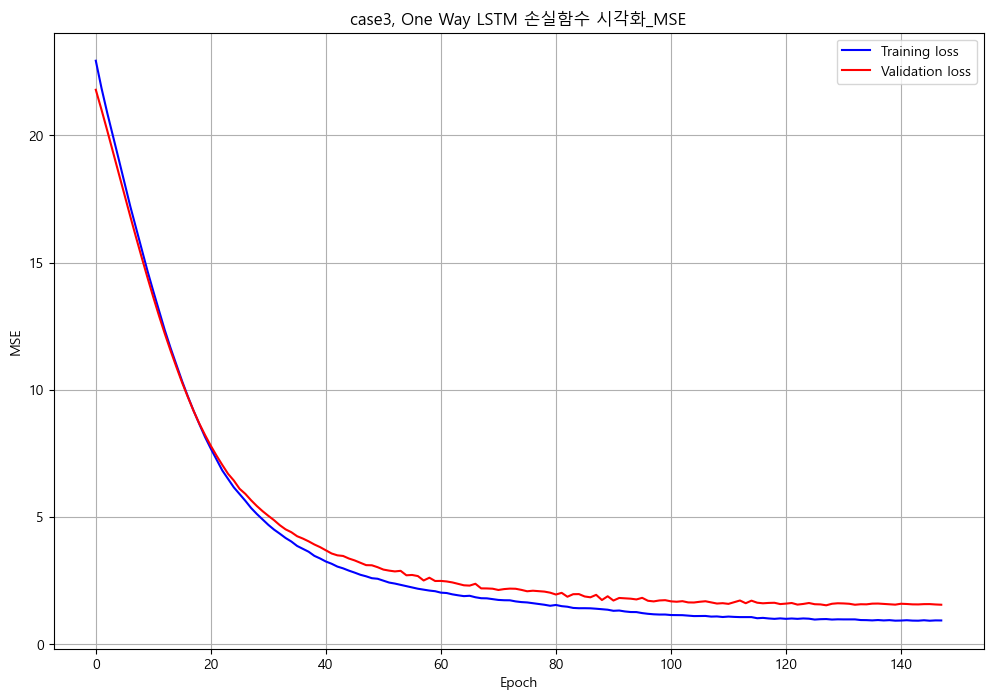

In [29]:
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = LSTM(128, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = LSTM(64, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case3_uni_mse = Model(inputs=[numerical_input, categorical_input], outputs=output)
case3_uni_mse.compile(optimizer=optimizer, loss="mse")


# 모델 학습
case3_uni_mse_history = case3_uni_mse.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case3_uni_mse_history, "case3, One Way LSTM" ,"MSE")

# 모델 저장
case3_uni_mse.save("./output/case3/case3_uni_mse.h5")

Epoch 1/300
16/16 [==============================] - 5s 90ms/step - loss: 22.8722 - root_mean_squared_error: 1.2990 - val_loss: 21.7282 - val_root_mean_squared_error: 0.9843 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 13ms/step - loss: 21.7453 - root_mean_squared_error: 1.1708 - val_loss: 20.9158 - val_root_mean_squared_error: 0.9939 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 12ms/step - loss: 20.7081 - root_mean_squared_error: 1.0883 - val_loss: 20.0611 - val_root_mean_squared_error: 1.0007 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 13ms/step - loss: 19.6956 - root_mean_squared_error: 1.0272 - val_loss: 19.1768 - val_root_mean_squared_error: 1.0068 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 12ms/step - loss: 18.7406 - root_mean_squared_error: 0.9997 - val_loss: 18.2835 - val_root_mean_squared_error: 1.0102 - lr: 5.0000e-04
Epoch 6/300
16/16 [==========================

16/16 [==============================] - 0s 13ms/step - loss: 2.7872 - root_mean_squared_error: 0.7800 - val_loss: 3.1382 - val_root_mean_squared_error: 0.9983 - lr: 5.0000e-04
Epoch 45/300
16/16 [==============================] - 0s 13ms/step - loss: 2.7082 - root_mean_squared_error: 0.7729 - val_loss: 3.0659 - val_root_mean_squared_error: 0.9959 - lr: 5.0000e-04
Epoch 46/300
16/16 [==============================] - 0s 13ms/step - loss: 2.6233 - root_mean_squared_error: 0.7642 - val_loss: 2.9937 - val_root_mean_squared_error: 0.9947 - lr: 5.0000e-04
Epoch 47/300
16/16 [==============================] - 0s 13ms/step - loss: 2.5607 - root_mean_squared_error: 0.7657 - val_loss: 2.9429 - val_root_mean_squared_error: 0.9978 - lr: 5.0000e-04
Epoch 48/300
16/16 [==============================] - 0s 13ms/step - loss: 2.5239 - root_mean_squared_error: 0.7748 - val_loss: 2.8928 - val_root_mean_squared_error: 0.9980 - lr: 5.0000e-04
Epoch 49/300
16/16 [==============================] - 0s 13ms/s

16/16 [==============================] - 0s 13ms/step - loss: 1.0981 - root_mean_squared_error: 0.7018 - val_loss: 1.6782 - val_root_mean_squared_error: 1.0360 - lr: 6.2500e-05
Epoch 128/300
12/16 [=====================>........] - ETA: 0s - loss: 1.1070 - root_mean_squared_error: 0.7088
Epoch 128: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
16/16 [==============================] - 0s 12ms/step - loss: 1.1013 - root_mean_squared_error: 0.7049 - val_loss: 1.6693 - val_root_mean_squared_error: 1.0324 - lr: 6.2500e-05
Epoch 129/300
16/16 [==============================] - 0s 13ms/step - loss: 1.0868 - root_mean_squared_error: 0.6961 - val_loss: 1.6803 - val_root_mean_squared_error: 1.0389 - lr: 3.1250e-05
Epoch 130/300
16/16 [==============================] - 0s 12ms/step - loss: 1.0843 - root_mean_squared_error: 0.6958 - val_loss: 1.6809 - val_root_mean_squared_error: 1.0400 - lr: 3.1250e-05
Epoch 131/300
16/16 [==============================] - 0s 13ms/step - loss

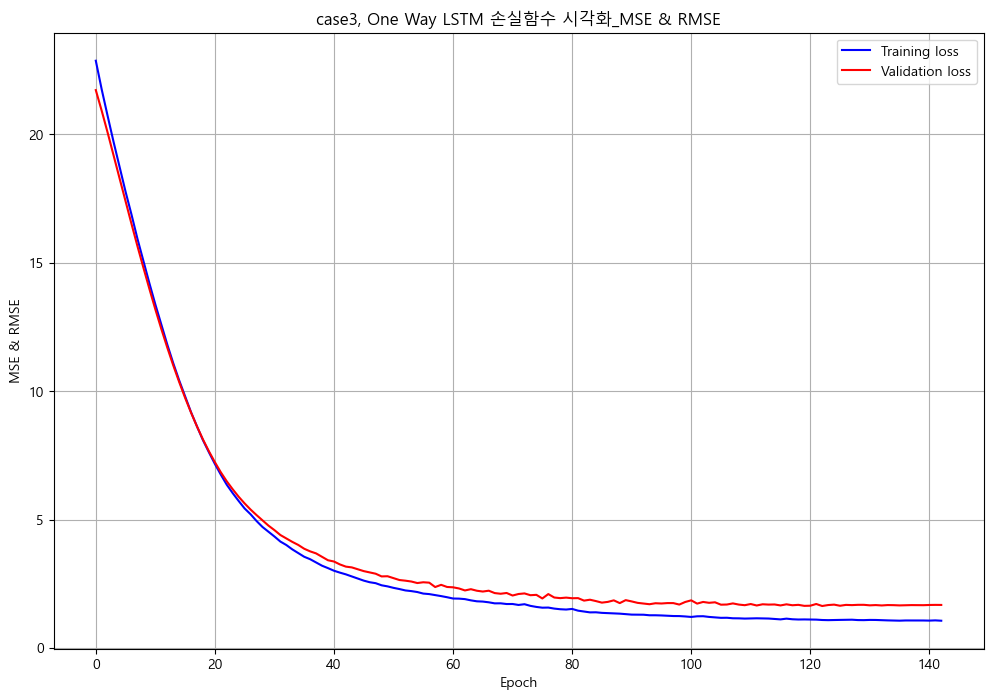

In [30]:
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = LSTM(128, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = LSTM(64, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case3_uni_rmse = Model(inputs=[numerical_input, categorical_input], outputs=output)
case3_uni_rmse.compile(optimizer=optimizer
                       , loss="mse"
                       , metrics=[metrics.RootMeanSquaredError()]
                      )


# 모델 학습
case3_uni_rmse_history = case3_uni_rmse.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case3_uni_rmse_history, "case3, One Way LSTM" ,"MSE & RMSE")

# 모델 저장
case3_uni_rmse.save("./output/case3/case3_uni_rmse.h5")

### 양방향 LSTM

Epoch 1/300
16/16 [==============================] - 6s 88ms/step - loss: 53.9941 - val_loss: 50.6999 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 19ms/step - loss: 48.2365 - val_loss: 45.2223 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 17ms/step - loss: 42.8593 - val_loss: 40.0952 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 17ms/step - loss: 37.8707 - val_loss: 35.3206 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 17ms/step - loss: 33.2546 - val_loss: 30.9299 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 18ms/step - loss: 29.0133 - val_loss: 26.9326 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 18ms/step - loss: 25.1886 - val_loss: 23.3194 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 17ms/step - loss: 21.7467 - val_loss: 20.0882 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

16/16 [==============================] - 0s 18ms/step - loss: 0.8548 - val_loss: 1.0428 - lr: 5.0000e-04
Epoch 140/300
16/16 [==============================] - 0s 17ms/step - loss: 0.8406 - val_loss: 1.0625 - lr: 5.0000e-04
Epoch 141/300
16/16 [==============================] - 0s 17ms/step - loss: 0.8251 - val_loss: 0.9677 - lr: 5.0000e-04
Epoch 142/300
16/16 [==============================] - 0s 17ms/step - loss: 0.8209 - val_loss: 1.0413 - lr: 5.0000e-04
Epoch 143/300
16/16 [==============================] - 0s 18ms/step - loss: 0.8152 - val_loss: 1.0314 - lr: 5.0000e-04
Epoch 144/300
16/16 [==============================] - 0s 18ms/step - loss: 0.7945 - val_loss: 1.0427 - lr: 5.0000e-04
Epoch 145/300
16/16 [==============================] - 0s 18ms/step - loss: 0.7861 - val_loss: 0.9669 - lr: 5.0000e-04
Epoch 146/300
16/16 [==============================] - 0s 19ms/step - loss: 0.7668 - val_loss: 0.9161 - lr: 5.0000e-04
Epoch 147/300
16/16 [==============================] - 0s 17ms

Epoch 202/300
13/16 [=======================>......] - ETA: 0s - loss: 0.5868
Epoch 202: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
16/16 [==============================] - 0s 18ms/step - loss: 0.5885 - val_loss: 0.8123 - lr: 1.5625e-05


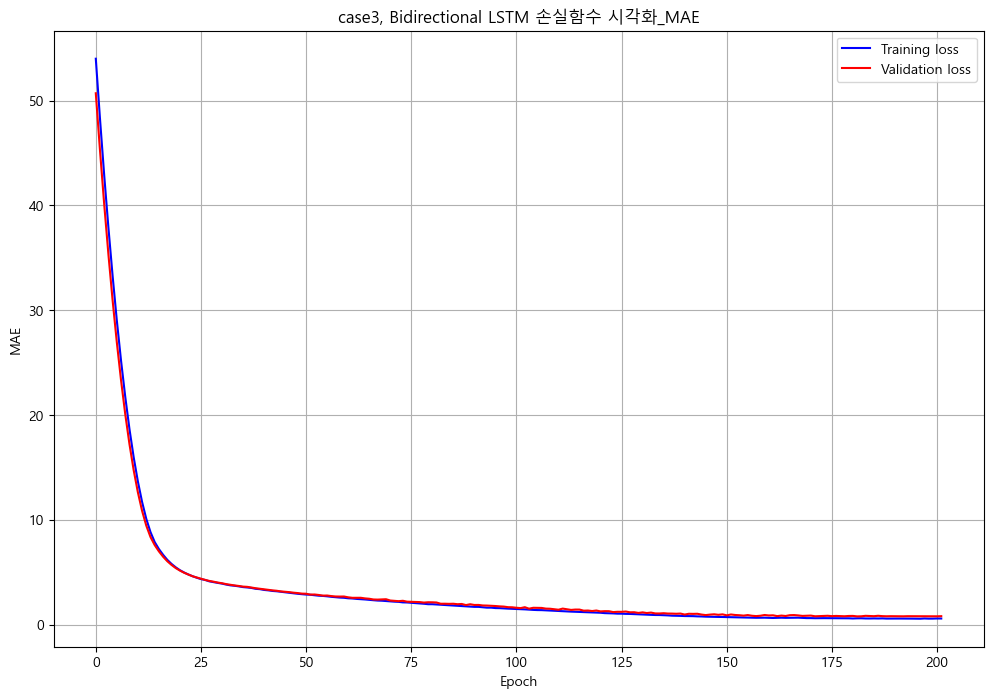

In [31]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention, Bidirectional
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = Bidirectional(LSTM(128, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case3_bi_mae = Model(inputs=[numerical_input, categorical_input], outputs=output)
case3_bi_mae.compile(optimizer=optimizer, loss="mae")

# 모델 학습
case3_bi_mae_history = case3_bi_mae.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case3_bi_mae_history, "case3, Bidirectional LSTM", "MAE")

# 모델 학습
case3_bi_mae.save("./output/case3/case3_bi_mae.h5")

Epoch 1/300
16/16 [==============================] - 6s 89ms/step - loss: 56.1201 - val_loss: 53.5475 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 17ms/step - loss: 52.3335 - val_loss: 49.9850 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 17ms/step - loss: 48.5746 - val_loss: 46.4121 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 17ms/step - loss: 44.8777 - val_loss: 42.8803 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 17ms/step - loss: 41.2950 - val_loss: 39.4344 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 17ms/step - loss: 37.8749 - val_loss: 36.1129 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 18ms/step - loss: 34.5662 - val_loss: 32.9627 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 18ms/step - loss: 31.5007 - val_loss: 29.9860 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

13/16 [=======================>......] - ETA: 0s - loss: 0.8549
Epoch 139: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
16/16 [==============================] - 0s 17ms/step - loss: 0.8492 - val_loss: 1.5035 - lr: 5.0000e-04
Epoch 140/300
16/16 [==============================] - 0s 17ms/step - loss: 0.8083 - val_loss: 1.3774 - lr: 2.5000e-04
Epoch 141/300
16/16 [==============================] - 0s 17ms/step - loss: 0.7843 - val_loss: 1.3049 - lr: 2.5000e-04
Epoch 142/300
16/16 [==============================] - 0s 16ms/step - loss: 0.7757 - val_loss: 1.3122 - lr: 2.5000e-04
Epoch 143/300
16/16 [==============================] - 0s 16ms/step - loss: 0.7715 - val_loss: 1.4292 - lr: 2.5000e-04
Epoch 144/300
16/16 [==============================] - 0s 16ms/step - loss: 0.7466 - val_loss: 1.3445 - lr: 2.5000e-04
Epoch 145/300
16/16 [==============================] - 0s 16ms/step - loss: 0.7470 - val_loss: 1.3213 - lr: 2.5000e-04
Epoch 146/300
16/16 [==================

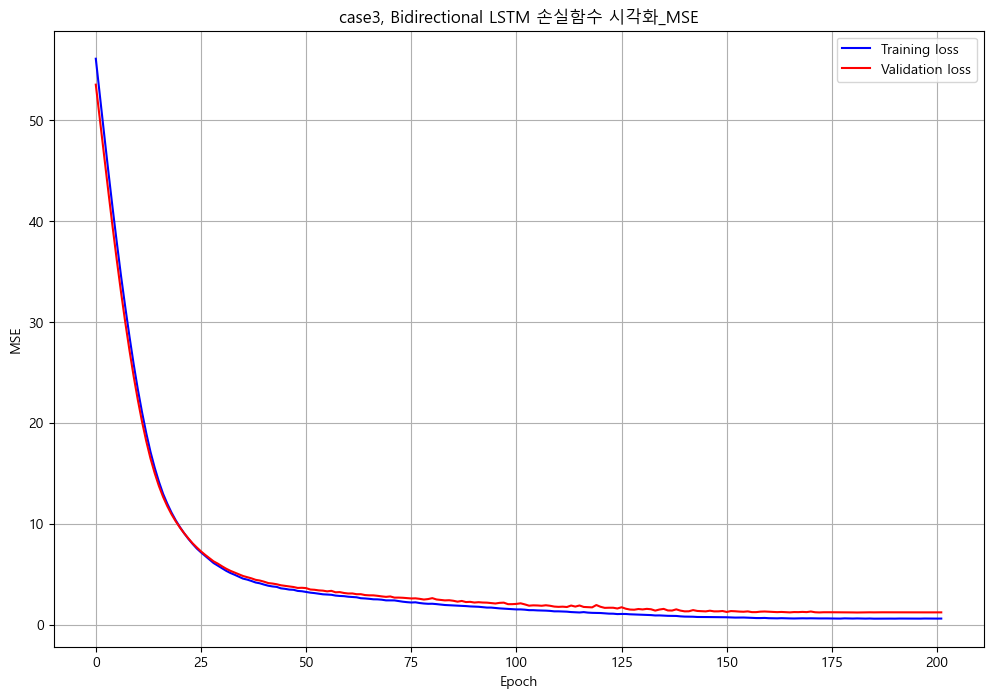

In [32]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention, Bidirectional
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = Bidirectional(LSTM(128, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case3_bi_mse = Model(inputs=[numerical_input, categorical_input], outputs=output)
case3_bi_mse.compile(optimizer=optimizer, loss="mse")

# 모델 학습
case3_bi_mse_history = case3_bi_mse.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case3_bi_mse_history, "case3, Bidirectional LSTM", "MSE")

# 모델 학습
case3_bi_mse.save("./output/case3/case3_bi_mse.h5")

Epoch 1/300
16/16 [==============================] - 6s 89ms/step - loss: 56.1593 - root_mean_squared_error: 1.2471 - val_loss: 53.8111 - val_root_mean_squared_error: 0.9754 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 17ms/step - loss: 52.4812 - root_mean_squared_error: 1.1299 - val_loss: 50.2721 - val_root_mean_squared_error: 0.9822 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 18ms/step - loss: 48.8369 - root_mean_squared_error: 1.1057 - val_loss: 46.6819 - val_root_mean_squared_error: 0.9890 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 17ms/step - loss: 45.0650 - root_mean_squared_error: 1.0187 - val_loss: 43.1210 - val_root_mean_squared_error: 0.9938 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 17ms/step - loss: 41.4863 - root_mean_squared_error: 0.9982 - val_loss: 39.6470 - val_root_mean_squared_error: 0.9965 - lr: 5.0000e-04
Epoch 6/300
16/16 [==========================

Epoch 44/300
16/16 [==============================] - 0s 17ms/step - loss: 3.6816 - root_mean_squared_error: 0.7901 - val_loss: 3.9855 - val_root_mean_squared_error: 0.9807 - lr: 5.0000e-04
Epoch 45/300
16/16 [==============================] - 0s 16ms/step - loss: 3.5808 - root_mean_squared_error: 0.7704 - val_loss: 3.9296 - val_root_mean_squared_error: 0.9918 - lr: 5.0000e-04
Epoch 46/300
16/16 [==============================] - 0s 16ms/step - loss: 3.5257 - root_mean_squared_error: 0.7790 - val_loss: 3.8406 - val_root_mean_squared_error: 0.9729 - lr: 5.0000e-04
Epoch 47/300
16/16 [==============================] - 0s 17ms/step - loss: 3.4670 - root_mean_squared_error: 0.7743 - val_loss: 3.7897 - val_root_mean_squared_error: 0.9797 - lr: 5.0000e-04
Epoch 48/300
16/16 [==============================] - 0s 17ms/step - loss: 3.3882 - root_mean_squared_error: 0.7711 - val_loss: 3.6945 - val_root_mean_squared_error: 0.9601 - lr: 5.0000e-04
Epoch 49/300
16/16 [==============================

16/16 [==============================] - 0s 16ms/step - loss: 1.0146 - root_mean_squared_error: 0.6899 - val_loss: 1.6274 - val_root_mean_squared_error: 1.0449 - lr: 2.5000e-04
Epoch 130/300
16/16 [==============================] - 0s 17ms/step - loss: 1.0079 - root_mean_squared_error: 0.6898 - val_loss: 1.5261 - val_root_mean_squared_error: 0.9989 - lr: 2.5000e-04
Epoch 131/300
16/16 [==============================] - 0s 17ms/step - loss: 0.9992 - root_mean_squared_error: 0.6895 - val_loss: 1.5843 - val_root_mean_squared_error: 1.0321 - lr: 2.5000e-04
Epoch 132/300
16/16 [==============================] - 0s 16ms/step - loss: 0.9993 - root_mean_squared_error: 0.6961 - val_loss: 1.6375 - val_root_mean_squared_error: 1.0621 - lr: 2.5000e-04
Epoch 133/300
16/16 [==============================] - 0s 17ms/step - loss: 0.9844 - root_mean_squared_error: 0.6919 - val_loss: 1.5968 - val_root_mean_squared_error: 1.0463 - lr: 2.5000e-04
Epoch 134/300
16/16 [==============================] - 0s 1

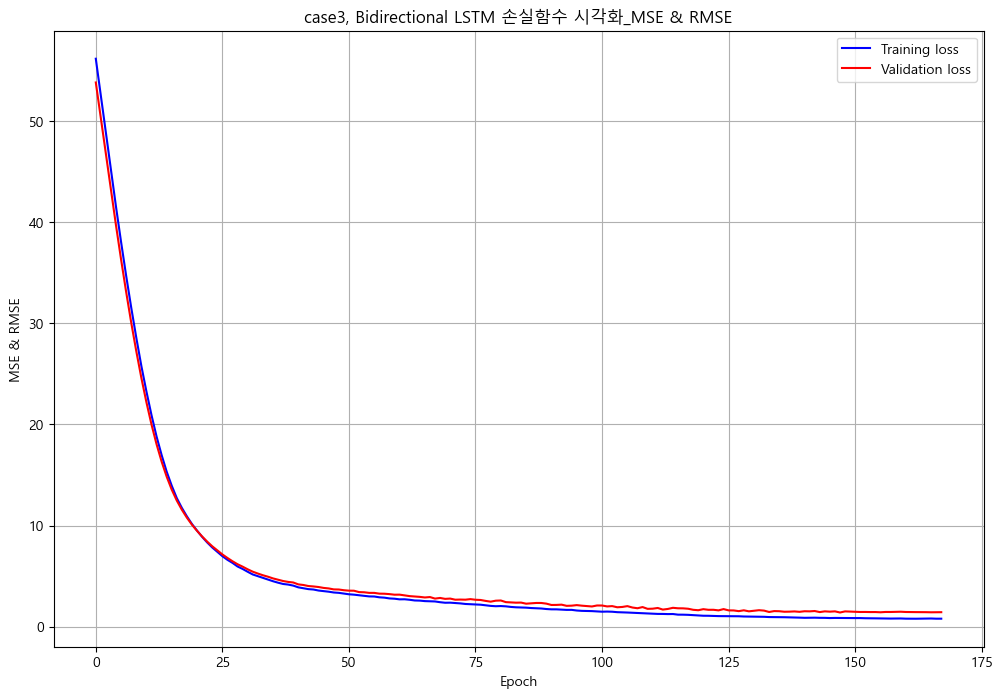

In [33]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention, Bidirectional
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = Bidirectional(LSTM(128, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case3_bi_rmse = Model(inputs=[numerical_input, categorical_input], outputs=output)
case3_bi_rmse.compile(optimizer=optimizer
                       , loss="mse"
                       , metrics=[metrics.RootMeanSquaredError()]
                      )

# 모델 학습
case3_bi_rmse_history = case3_bi_rmse.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case3_bi_rmse_history, "case3, Bidirectional LSTM", "MSE & RMSE")

# 모델 학습
case3_bi_rmse.save("./output/case3/case3_bi_rmse.h5")

# Case4) DMI & 로그 변환

## 데이터 전처리

### 부호 유지 로그 변환

In [34]:
case4_df = data[['DMI', 'ONI', 'SOI', 'ENSO', 'D20_SCTR']]

case4_dts = case4_df.values
print(case4_dts.shape)

case4_label = case4_dts[ : , 3]
case4_dts = case4_dts[ : , [0, 1, 2, 4]]

case4_dts = np.sign(case4_dts) * np.log1p(np.abs(case4_dts))
print(case4_dts.shape)

(400, 5)
(400, 4)


### 데이터 분포 확인

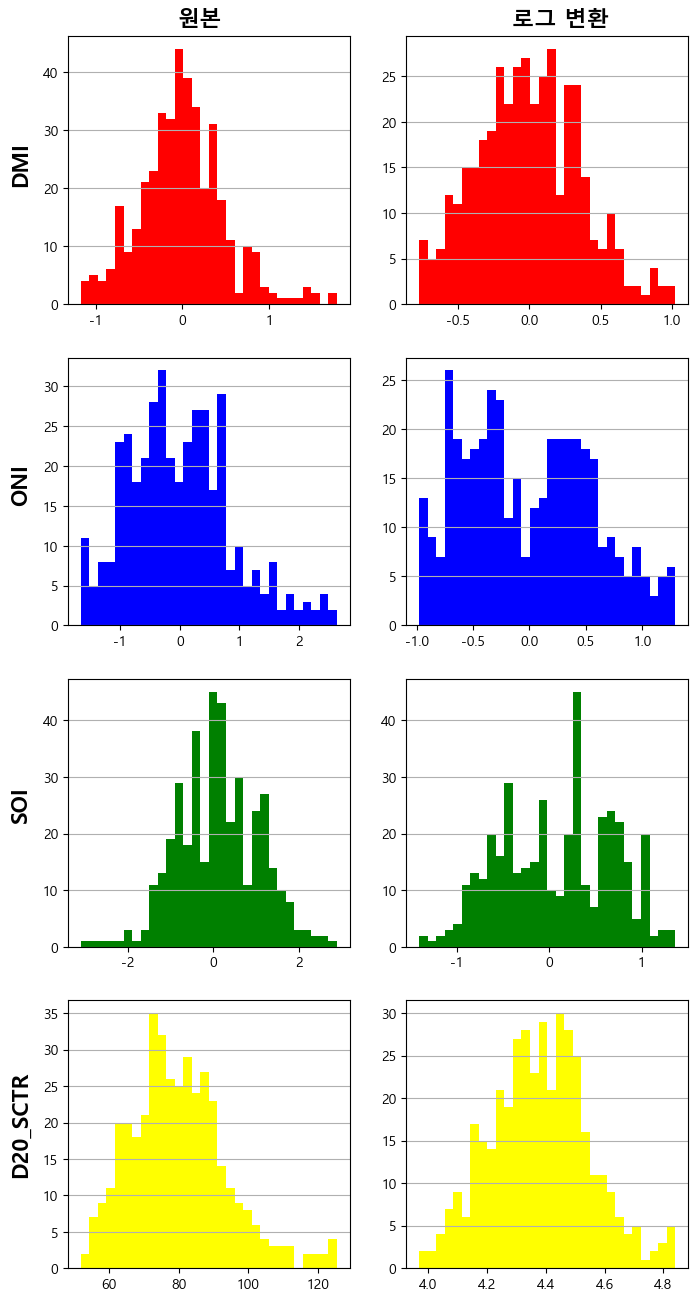

In [35]:
fig, ax = plt.subplots(4, 2, figsize=(8, 16))

i = 0

colors = ["red", "blue", "green", "yellow"]

for column in ['DMI', 'ONI', 'SOI', 'D20_SCTR']:

    ax[i][0].hist(case4_df[column], bins=30, label=column, color=colors[i])
    ax[i][0].grid(axis = "y")
    
    ax[i][1].hist(case4_dts[:, i], bins=30, label=column, color=colors[i])
    ax[i][1].grid(axis = "y")

    i += 1
    
for j, col_title in enumerate(['원본', '로그 변환']):
    fig.text(0.29 + j * 0.45, 0.89, col_title, ha='center', va='center', fontsize=16, fontweight='bold')
    
for i, label in enumerate(['DMI', 'ONI', 'SOI', 'D20_SCTR']):
    fig.text(0.08, 0.8 - i * 0.2, label, va='center', ha='right', fontsize=16, rotation=90, fontweight='bold')
    
plt.savefig('./output/Case4_스케일 비교.png', bbox_inches='tight')
plt.show()

## 데이터 분리

In [36]:
# 학습 데이터
x_train_multi, y_train_multi = multivariate_data(case4_dts, case4_dts[:, -1], 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

x_train_label = label_split(case4_label, 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

# 검증 데이터
x_val_multi, y_val_multi = multivariate_data(case4_dts, case4_dts[:, -1], TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

x_val_label = label_split(case4_label, TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

# 테스트 데이터
x_test_multi, y_test_multi = multivariate_data(case4_dts, case4_dts[:, -1], TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

x_test_label = label_split(case4_label, TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

print(f"학습 데이터 형태: {x_train_multi.shape}")
print(f"학습 타겟데이터 형태: {y_train_multi.shape}")
print(f"학습 라벨데이터 형태: {x_train_label.shape}")
print("--------------------------------")
print(f"검증 데이터 형태: {x_val_multi.shape}")
print(f"검증 타겟데이터 형태: {y_val_multi.shape}")
print(f"검증 라벨데이터 형태: {x_val_label.shape}")
print("--------------------------------")
print(f"테스트 데이터 형태: {x_test_multi.shape}")
print(f"테스트 타겟데이터 형태: {y_test_multi.shape}")
print(f"테스트 라벨데이터 형태: {x_test_label.shape}")
print("--------------------------------")
print('과거 데이터 윈도우 형태: {}'.format(x_train_multi[0].shape))
print('예측 목표 기간 형태: {}'.format(y_train_multi[0].shape))

학습 데이터 형태: (256, 12, 4)
학습 타겟데이터 형태: (256, 12)
학습 라벨데이터 형태: (256, 12)
--------------------------------
검증 데이터 형태: (56, 12, 4)
검증 타겟데이터 형태: (56, 12)
검증 라벨데이터 형태: (56, 12)
--------------------------------
테스트 데이터 형태: (16, 12, 4)
테스트 타겟데이터 형태: (16, 12)
테스트 라벨데이터 형태: (16, 12)
--------------------------------
과거 데이터 윈도우 형태: (12, 4)
예측 목표 기간 형태: (12,)


## 모델 학습

### 단방향 LSTM

Epoch 1/300
16/16 [==============================] - 4s 55ms/step - loss: 24.9328 - val_loss: 24.2371 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 11ms/step - loss: 23.0798 - val_loss: 22.6269 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 11ms/step - loss: 21.3126 - val_loss: 21.0455 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 11ms/step - loss: 19.5335 - val_loss: 19.5098 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 11ms/step - loss: 17.8301 - val_loss: 17.9912 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 11ms/step - loss: 16.1691 - val_loss: 16.5153 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 11ms/step - loss: 14.6670 - val_loss: 15.0817 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 12ms/step - loss: 13.1507 - val_loss: 13.7224 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

Epoch 68/300
16/16 [==============================] - 0s 11ms/step - loss: 1.7816 - val_loss: 1.7068 - lr: 1.2500e-04
Epoch 69/300
16/16 [==============================] - 0s 11ms/step - loss: 1.8428 - val_loss: 1.8631 - lr: 1.2500e-04
Epoch 70/300
16/16 [==============================] - 0s 11ms/step - loss: 1.8288 - val_loss: 1.8579 - lr: 1.2500e-04
Epoch 71/300
16/16 [==============================] - 0s 11ms/step - loss: 1.7868 - val_loss: 1.6043 - lr: 1.2500e-04
Epoch 72/300
16/16 [==============================] - 0s 11ms/step - loss: 1.7658 - val_loss: 1.5955 - lr: 1.2500e-04
Epoch 73/300
16/16 [==============================] - 0s 11ms/step - loss: 1.7794 - val_loss: 1.4721 - lr: 1.2500e-04
Epoch 74/300
16/16 [==============================] - 0s 11ms/step - loss: 1.7738 - val_loss: 1.4254 - lr: 1.2500e-04
Epoch 75/300
16/16 [==============================] - 0s 11ms/step - loss: 1.6977 - val_loss: 1.4232 - lr: 1.2500e-04
Epoch 76/300
16/16 [==============================] - 0s

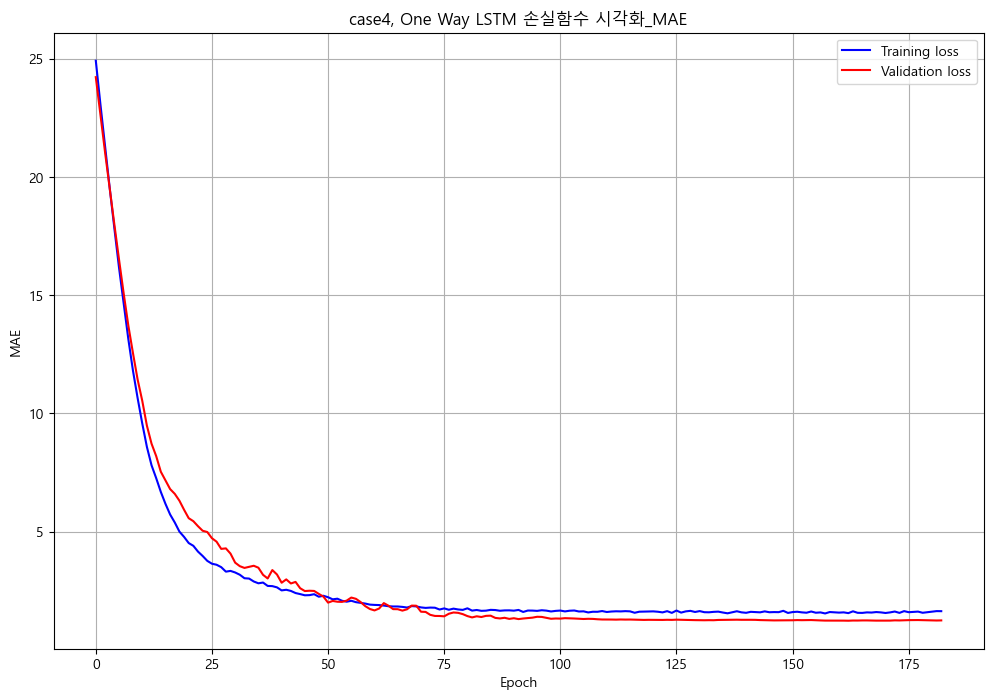

In [37]:
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = LSTM(128, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = LSTM(64, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case4_uni_mae = Model(inputs=[numerical_input, categorical_input], outputs=output)
case4_uni_mae.compile(optimizer=optimizer, loss="mae" )

# 모델 학습
case4_uni_mae_history = case4_uni_mae.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case4_uni_mae_history, "case4, One Way LSTM", "MAE")

# 모델 저장
case4_uni_mae.save("./output/case4/case4_uni_mae.h5")

Epoch 1/300
16/16 [==============================] - 4s 55ms/step - loss: 40.3790 - val_loss: 40.1515 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 11ms/step - loss: 37.4869 - val_loss: 39.2204 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 11ms/step - loss: 35.3620 - val_loss: 38.0186 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 11ms/step - loss: 33.2765 - val_loss: 36.8163 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 11ms/step - loss: 31.3028 - val_loss: 35.4937 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 11ms/step - loss: 29.2881 - val_loss: 33.8777 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 13ms/step - loss: 27.3729 - val_loss: 32.2075 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 11ms/step - loss: 25.2248 - val_loss: 30.0782 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

16/16 [==============================] - 0s 11ms/step - loss: 3.3145 - val_loss: 2.8475 - lr: 5.0000e-04
Epoch 71/300
16/16 [==============================] - 0s 11ms/step - loss: 3.2077 - val_loss: 2.6224 - lr: 5.0000e-04
Epoch 72/300
16/16 [==============================] - 0s 11ms/step - loss: 3.0609 - val_loss: 2.5954 - lr: 5.0000e-04
Epoch 73/300
16/16 [==============================] - 0s 11ms/step - loss: 3.0525 - val_loss: 2.7002 - lr: 5.0000e-04
Epoch 74/300
16/16 [==============================] - 0s 11ms/step - loss: 3.0746 - val_loss: 2.8160 - lr: 5.0000e-04
Epoch 75/300
16/16 [==============================] - 0s 11ms/step - loss: 2.8869 - val_loss: 2.7570 - lr: 5.0000e-04
Epoch 76/300
16/16 [==============================] - 0s 11ms/step - loss: 2.8481 - val_loss: 2.7421 - lr: 5.0000e-04
Epoch 77/300
16/16 [==============================] - 0s 11ms/step - loss: 2.6957 - val_loss: 2.5105 - lr: 5.0000e-04
Epoch 78/300
16/16 [==============================] - 0s 11ms/step - 

Epoch 202/300
16/16 [==============================] - 0s 11ms/step - loss: 0.7254 - val_loss: 0.4997 - lr: 1.5625e-05
Epoch 203/300
16/16 [==============================] - 0s 12ms/step - loss: 0.7318 - val_loss: 0.4968 - lr: 1.5625e-05
Epoch 204/300
16/16 [==============================] - 0s 11ms/step - loss: 0.6799 - val_loss: 0.4911 - lr: 1.5625e-05
Epoch 205/300
13/16 [=======================>......] - ETA: 0s - loss: 0.7271
Epoch 205: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
16/16 [==============================] - 0s 11ms/step - loss: 0.7250 - val_loss: 0.4933 - lr: 1.5625e-05
Epoch 206/300
16/16 [==============================] - 0s 11ms/step - loss: 0.7086 - val_loss: 0.4905 - lr: 7.8125e-06
Epoch 207/300
16/16 [==============================] - 0s 11ms/step - loss: 0.7295 - val_loss: 0.4847 - lr: 7.8125e-06
Epoch 208/300
16/16 [==============================] - 0s 11ms/step - loss: 0.6654 - val_loss: 0.4844 - lr: 7.8125e-06
Epoch 209/300
16/16 [====

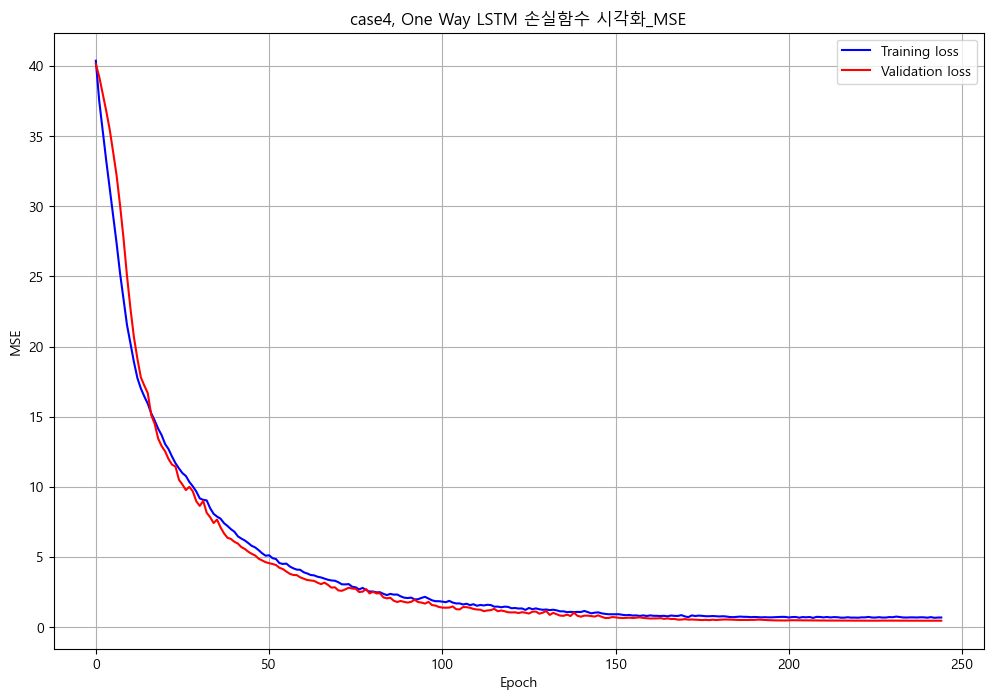

In [38]:
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = LSTM(128, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = LSTM(64, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case4_uni_mse = Model(inputs=[numerical_input, categorical_input], outputs=output)
case4_uni_mse.compile(optimizer=optimizer, loss="mse" )

# 모델 학습
case4_uni_mse_history = case4_uni_mse.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case4_uni_mse_history, "case4, One Way LSTM", "MSE")

# 모델 저장
case4_uni_mse.save("./output/case4/case4_uni_mse.h5")

Epoch 1/300
16/16 [==============================] - 4s 55ms/step - loss: 41.7182 - root_mean_squared_error: 4.5222 - val_loss: 40.1348 - val_root_mean_squared_error: 4.3745 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 11ms/step - loss: 39.6784 - root_mean_squared_error: 4.3515 - val_loss: 39.3447 - val_root_mean_squared_error: 4.3470 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 11ms/step - loss: 37.7819 - root_mean_squared_error: 4.1957 - val_loss: 38.4446 - val_root_mean_squared_error: 4.3102 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 11ms/step - loss: 35.8306 - root_mean_squared_error: 4.0303 - val_loss: 37.3235 - val_root_mean_squared_error: 4.2491 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 12ms/step - loss: 33.7546 - root_mean_squared_error: 3.8433 - val_loss: 35.9710 - val_root_mean_squared_error: 4.1607 - lr: 5.0000e-04
Epoch 6/300
16/16 [==========================

Epoch 44/300
16/16 [==============================] - 0s 12ms/step - loss: 5.7062 - root_mean_squared_error: 0.8791 - val_loss: 5.6758 - val_root_mean_squared_error: 0.8999 - lr: 5.0000e-04
Epoch 45/300
16/16 [==============================] - 0s 12ms/step - loss: 5.6322 - root_mean_squared_error: 0.9231 - val_loss: 5.5644 - val_root_mean_squared_error: 0.9368 - lr: 5.0000e-04
Epoch 46/300
16/16 [==============================] - 0s 12ms/step - loss: 5.5360 - root_mean_squared_error: 0.9551 - val_loss: 5.3072 - val_root_mean_squared_error: 0.8645 - lr: 5.0000e-04
Epoch 47/300
16/16 [==============================] - 0s 12ms/step - loss: 5.4510 - root_mean_squared_error: 0.9810 - val_loss: 5.0245 - val_root_mean_squared_error: 0.7834 - lr: 5.0000e-04
Epoch 48/300
16/16 [==============================] - 0s 12ms/step - loss: 5.0883 - root_mean_squared_error: 0.8579 - val_loss: 4.8928 - val_root_mean_squared_error: 0.7811 - lr: 5.0000e-04
Epoch 49/300
16/16 [==============================

16/16 [==============================] - 0s 11ms/step - loss: 1.3480 - root_mean_squared_error: 0.6535 - val_loss: 0.9838 - val_root_mean_squared_error: 0.2895 - lr: 2.5000e-04
Epoch 130/300
16/16 [==============================] - 0s 11ms/step - loss: 1.3498 - root_mean_squared_error: 0.6811 - val_loss: 0.9940 - val_root_mean_squared_error: 0.3459 - lr: 2.5000e-04
Epoch 131/300
16/16 [==============================] - 0s 11ms/step - loss: 1.3478 - root_mean_squared_error: 0.6944 - val_loss: 0.9776 - val_root_mean_squared_error: 0.3353 - lr: 2.5000e-04
Epoch 132/300
16/16 [==============================] - 0s 11ms/step - loss: 1.3550 - root_mean_squared_error: 0.6974 - val_loss: 0.9330 - val_root_mean_squared_error: 0.2728 - lr: 2.5000e-04
Epoch 133/300
16/16 [==============================] - 0s 11ms/step - loss: 1.3136 - root_mean_squared_error: 0.6810 - val_loss: 0.9410 - val_root_mean_squared_error: 0.3024 - lr: 2.5000e-04
Epoch 134/300
16/16 [==============================] - 0s 1

16/16 [==============================] - 0s 11ms/step - loss: 0.9869 - root_mean_squared_error: 0.5979 - val_loss: 0.6871 - val_root_mean_squared_error: 0.2527 - lr: 1.2500e-04
Epoch 172/300
16/16 [==============================] - 0s 11ms/step - loss: 1.0025 - root_mean_squared_error: 0.6192 - val_loss: 0.6884 - val_root_mean_squared_error: 0.2686 - lr: 1.2500e-04
Epoch 173/300
13/16 [=======================>......] - ETA: 0s - loss: 0.9857 - root_mean_squared_error: 0.6088
Epoch 173: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
16/16 [==============================] - 0s 11ms/step - loss: 1.0545 - root_mean_squared_error: 0.6630 - val_loss: 0.7052 - val_root_mean_squared_error: 0.3030 - lr: 1.2500e-04
Epoch 174/300
16/16 [==============================] - 0s 11ms/step - loss: 0.9733 - root_mean_squared_error: 0.6030 - val_loss: 0.6816 - val_root_mean_squared_error: 0.2735 - lr: 6.2500e-05
Epoch 175/300
16/16 [==============================] - 0s 11ms/step - loss:

16/16 [==============================] - 0s 11ms/step - loss: 0.9002 - root_mean_squared_error: 0.6104 - val_loss: 0.5847 - val_root_mean_squared_error: 0.2393 - lr: 1.9531e-06
Epoch 252/300
16/16 [==============================] - 0s 11ms/step - loss: 0.9160 - root_mean_squared_error: 0.6235 - val_loss: 0.5847 - val_root_mean_squared_error: 0.2398 - lr: 1.9531e-06
Epoch 253/300
16/16 [==============================] - 0s 11ms/step - loss: 0.9331 - root_mean_squared_error: 0.6371 - val_loss: 0.5844 - val_root_mean_squared_error: 0.2392 - lr: 1.9531e-06
Epoch 254/300
16/16 [==============================] - 0s 11ms/step - loss: 0.9292 - root_mean_squared_error: 0.6341 - val_loss: 0.5852 - val_root_mean_squared_error: 0.2411 - lr: 1.9531e-06
Epoch 255/300
16/16 [==============================] - 0s 11ms/step - loss: 0.9020 - root_mean_squared_error: 0.6123 - val_loss: 0.5855 - val_root_mean_squared_error: 0.2418 - lr: 1.9531e-06
Epoch 256/300
16/16 [==============================] - 0s 1

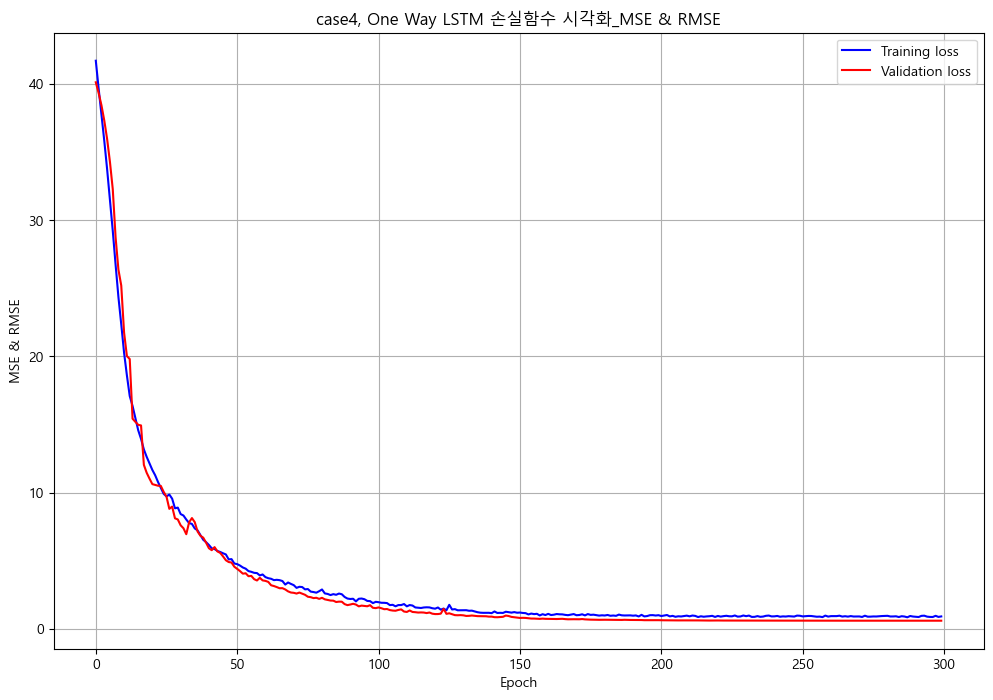

In [39]:
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = LSTM(128, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = LSTM(64, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case4_uni_rmse = Model(inputs=[numerical_input, categorical_input], outputs=output)
case4_uni_rmse.compile(optimizer=optimizer
                       , loss="mse"
                       , metrics=[metrics.RootMeanSquaredError()]
                      )

# 모델 학습
case4_uni_rmse_history = case4_uni_rmse.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case4_uni_rmse_history, "case4, One Way LSTM", "MSE & RMSE")

# 모델 저장
case4_uni_rmse.save("./output/case4/case4_uni_rmse.h5")

### 양방향 LSTM

Epoch 1/300
16/16 [==============================] - 6s 88ms/step - loss: 57.2169 - val_loss: 53.8073 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 17ms/step - loss: 50.7610 - val_loss: 47.7329 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 16ms/step - loss: 44.7078 - val_loss: 42.0749 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 17ms/step - loss: 39.0526 - val_loss: 36.8647 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 16ms/step - loss: 33.8312 - val_loss: 32.1158 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 16ms/step - loss: 29.0222 - val_loss: 27.7842 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 16ms/step - loss: 24.7230 - val_loss: 23.9113 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 17ms/step - loss: 20.8441 - val_loss: 20.4985 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

16/16 [==============================] - 0s 17ms/step - loss: 1.3498 - val_loss: 1.1243 - lr: 6.2500e-05
Epoch 136/300
16/16 [==============================] - 0s 17ms/step - loss: 1.3112 - val_loss: 1.0701 - lr: 6.2500e-05
Epoch 137/300
16/16 [==============================] - 0s 17ms/step - loss: 1.3009 - val_loss: 1.0598 - lr: 6.2500e-05
Epoch 138/300
16/16 [==============================] - 0s 18ms/step - loss: 1.3357 - val_loss: 1.0574 - lr: 6.2500e-05
Epoch 139/300
16/16 [==============================] - 0s 17ms/step - loss: 1.3057 - val_loss: 1.0356 - lr: 6.2500e-05
Epoch 140/300
16/16 [==============================] - 0s 16ms/step - loss: 1.2652 - val_loss: 1.0979 - lr: 6.2500e-05
Epoch 141/300
16/16 [==============================] - 0s 16ms/step - loss: 1.2937 - val_loss: 1.0677 - lr: 6.2500e-05
Epoch 142/300
16/16 [==============================] - 0s 16ms/step - loss: 1.3079 - val_loss: 1.0445 - lr: 6.2500e-05
Epoch 143/300
16/16 [==============================] - 0s 16ms

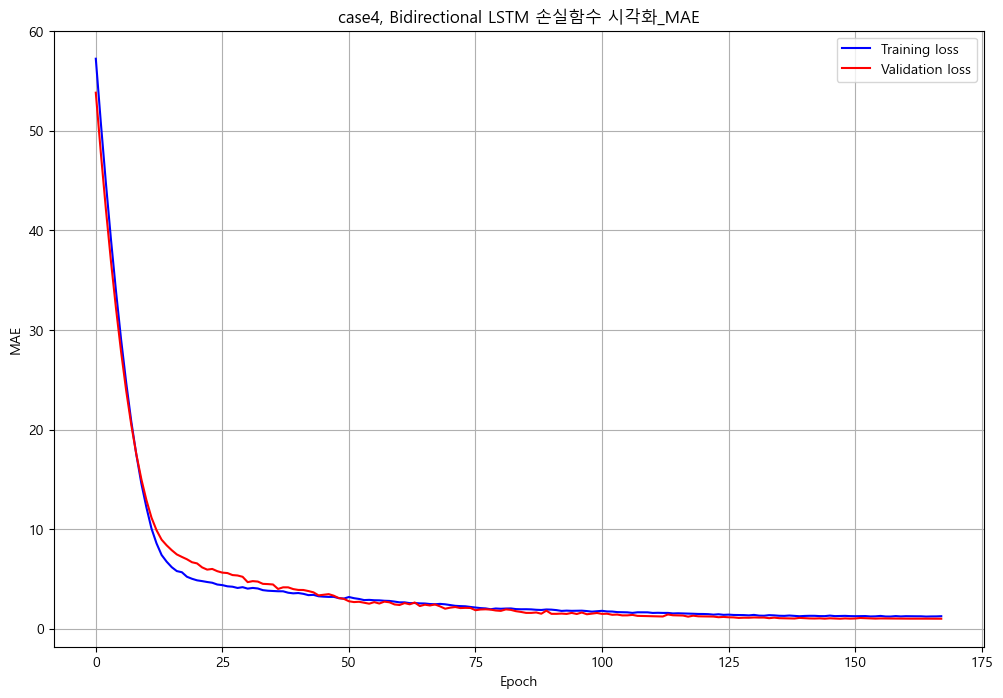

In [40]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention, Bidirectional
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = Bidirectional(LSTM(128, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case4_bi_mae = Model(inputs=[numerical_input, categorical_input], outputs=output)
case4_bi_mae.compile(optimizer=optimizer, loss="mae")

# 모델 학습
case4_bi_mae_history = case4_bi_mae.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case4_bi_mae_history, "case4, Bidirectional LSTM", "MAE")

# 모델 학습
case4_bi_mae.save("./output/case4/case4_bi_mae.h5")

Epoch 1/300
16/16 [==============================] - 7s 90ms/step - loss: 72.8395 - val_loss: 73.4354 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 17ms/step - loss: 68.5771 - val_loss: 71.0256 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 17ms/step - loss: 64.5238 - val_loss: 68.4180 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 17ms/step - loss: 60.3751 - val_loss: 65.6064 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 17ms/step - loss: 56.1246 - val_loss: 62.7641 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 17ms/step - loss: 52.1500 - val_loss: 59.9218 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 17ms/step - loss: 48.4992 - val_loss: 56.8594 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 17ms/step - loss: 44.9130 - val_loss: 53.7337 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

Epoch 70/300
16/16 [==============================] - 0s 17ms/step - loss: 3.6889 - val_loss: 3.4905 - lr: 5.0000e-04
Epoch 71/300
16/16 [==============================] - 0s 16ms/step - loss: 3.6168 - val_loss: 3.6249 - lr: 5.0000e-04
Epoch 72/300
16/16 [==============================] - 0s 17ms/step - loss: 3.4834 - val_loss: 3.3879 - lr: 5.0000e-04
Epoch 73/300
16/16 [==============================] - 0s 17ms/step - loss: 3.4310 - val_loss: 3.4025 - lr: 5.0000e-04
Epoch 74/300
16/16 [==============================] - 0s 17ms/step - loss: 3.3581 - val_loss: 3.3669 - lr: 5.0000e-04
Epoch 75/300
16/16 [==============================] - 0s 17ms/step - loss: 3.3771 - val_loss: 3.3254 - lr: 5.0000e-04
Epoch 76/300
16/16 [==============================] - 0s 17ms/step - loss: 3.3438 - val_loss: 3.2642 - lr: 5.0000e-04
Epoch 77/300
16/16 [==============================] - 0s 17ms/step - loss: 3.3720 - val_loss: 3.0440 - lr: 5.0000e-04
Epoch 78/300
16/16 [==============================] - 0s

Epoch 138/300
16/16 [==============================] - 0s 18ms/step - loss: 1.3173 - val_loss: 1.0498 - lr: 2.5000e-04
Epoch 139/300
16/16 [==============================] - 0s 18ms/step - loss: 1.3242 - val_loss: 1.0398 - lr: 2.5000e-04
Epoch 140/300
16/16 [==============================] - 0s 20ms/step - loss: 1.2891 - val_loss: 1.0076 - lr: 2.5000e-04
Epoch 141/300
16/16 [==============================] - 0s 18ms/step - loss: 1.2866 - val_loss: 0.9798 - lr: 2.5000e-04
Epoch 142/300
16/16 [==============================] - 0s 18ms/step - loss: 1.2645 - val_loss: 0.9969 - lr: 2.5000e-04
Epoch 143/300
16/16 [==============================] - 0s 18ms/step - loss: 1.2672 - val_loss: 0.9772 - lr: 2.5000e-04
Epoch 144/300
16/16 [==============================] - 0s 20ms/step - loss: 1.2925 - val_loss: 0.9614 - lr: 2.5000e-04
Epoch 145/300
16/16 [==============================] - 0s 18ms/step - loss: 1.1968 - val_loss: 0.9611 - lr: 2.5000e-04
Epoch 146/300
16/16 [===========================

16/16 [==============================] - 0s 24ms/step - loss: 0.6414 - val_loss: 0.4412 - lr: 2.5000e-04
Epoch 207/300
16/16 [==============================] - 0s 20ms/step - loss: 0.6306 - val_loss: 0.4072 - lr: 1.2500e-04
Epoch 208/300
16/16 [==============================] - 0s 17ms/step - loss: 0.5470 - val_loss: 0.3845 - lr: 1.2500e-04
Epoch 209/300
16/16 [==============================] - 0s 19ms/step - loss: 0.6534 - val_loss: 0.3716 - lr: 1.2500e-04
Epoch 210/300
16/16 [==============================] - 0s 18ms/step - loss: 0.6057 - val_loss: 0.3761 - lr: 1.2500e-04
Epoch 211/300
16/16 [==============================] - 0s 18ms/step - loss: 0.5993 - val_loss: 0.3674 - lr: 1.2500e-04
Epoch 212/300
16/16 [==============================] - 0s 17ms/step - loss: 0.5933 - val_loss: 0.3703 - lr: 1.2500e-04
Epoch 213/300
16/16 [==============================] - 0s 18ms/step - loss: 0.6082 - val_loss: 0.3672 - lr: 1.2500e-04
Epoch 214/300
16/16 [==============================] - 0s 17ms

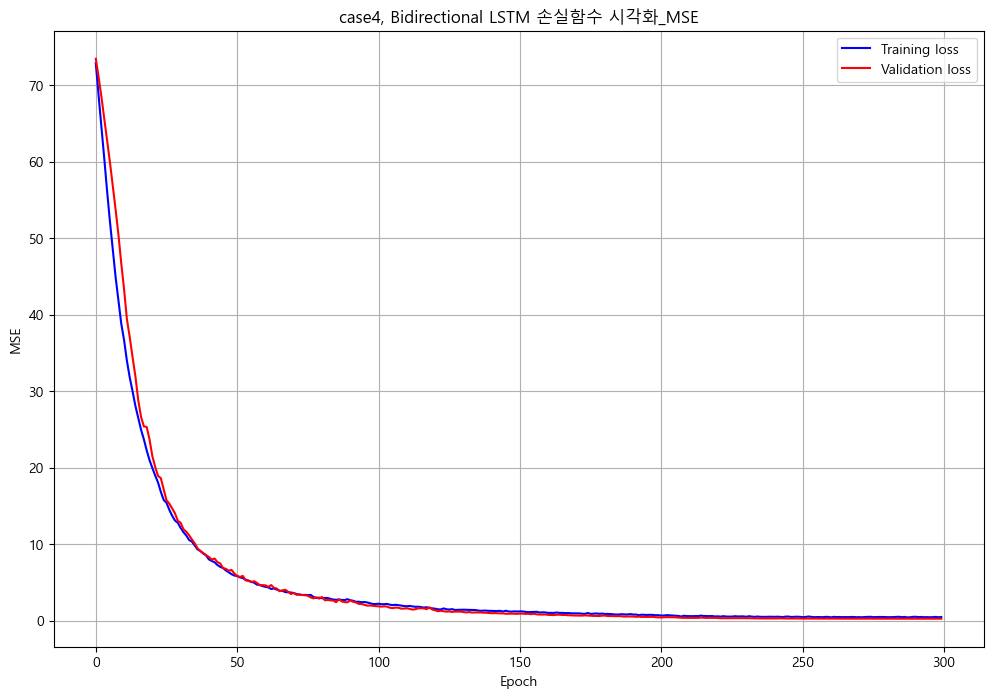

In [41]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention, Bidirectional
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = Bidirectional(LSTM(128, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case4_bi_mse = Model(inputs=[numerical_input, categorical_input], outputs=output)
case4_bi_mse.compile(optimizer=optimizer, loss="mse")

# 모델 학습
case4_bi_mse_history = case4_bi_mse.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case4_bi_mse_history, "case4, Bidirectional LSTM", "MSE")

# 모델 학습
case4_bi_mse.save("./output/case4/case4_bi_mse.h5")

Epoch 1/300
16/16 [==============================] - 6s 91ms/step - loss: 73.6430 - root_mean_squared_error: 4.3073 - val_loss: 73.1998 - val_root_mean_squared_error: 4.3728 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 17ms/step - loss: 69.8265 - root_mean_squared_error: 4.0871 - val_loss: 70.8605 - val_root_mean_squared_error: 4.3414 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 17ms/step - loss: 66.1114 - root_mean_squared_error: 3.8882 - val_loss: 68.3778 - val_root_mean_squared_error: 4.3075 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 17ms/step - loss: 62.3783 - root_mean_squared_error: 3.6880 - val_loss: 65.8741 - val_root_mean_squared_error: 4.2765 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 18ms/step - loss: 58.9333 - root_mean_squared_error: 3.5212 - val_loss: 63.1135 - val_root_mean_squared_error: 4.2145 - lr: 5.0000e-04
Epoch 6/300
16/16 [==========================

Epoch 44/300
16/16 [==============================] - 0s 17ms/step - loss: 7.0740 - root_mean_squared_error: 0.8791 - val_loss: 7.7122 - val_root_mean_squared_error: 1.2328 - lr: 5.0000e-04
Epoch 45/300
16/16 [==============================] - 0s 17ms/step - loss: 6.7747 - root_mean_squared_error: 0.8327 - val_loss: 7.0987 - val_root_mean_squared_error: 1.0690 - lr: 5.0000e-04
Epoch 46/300
16/16 [==============================] - 0s 17ms/step - loss: 6.7025 - root_mean_squared_error: 0.9073 - val_loss: 6.4744 - val_root_mean_squared_error: 0.8378 - lr: 5.0000e-04
Epoch 47/300
16/16 [==============================] - 0s 17ms/step - loss: 6.3939 - root_mean_squared_error: 0.8581 - val_loss: 6.0116 - val_root_mean_squared_error: 0.6928 - lr: 5.0000e-04
Epoch 48/300
16/16 [==============================] - 0s 17ms/step - loss: 6.2156 - root_mean_squared_error: 0.8871 - val_loss: 6.0098 - val_root_mean_squared_error: 0.8136 - lr: 5.0000e-04
Epoch 49/300
16/16 [==============================

16/16 [==============================] - 0s 17ms/step - loss: 1.3170 - root_mean_squared_error: 0.6084 - val_loss: 1.1711 - val_root_mean_squared_error: 0.4922 - lr: 2.5000e-04
Epoch 130/300
16/16 [==============================] - 0s 17ms/step - loss: 1.2709 - root_mean_squared_error: 0.5992 - val_loss: 1.2405 - val_root_mean_squared_error: 0.5801 - lr: 2.5000e-04
Epoch 131/300
16/16 [==============================] - 0s 17ms/step - loss: 1.3695 - root_mean_squared_error: 0.6713 - val_loss: 1.1437 - val_root_mean_squared_error: 0.4725 - lr: 2.5000e-04
Epoch 132/300
16/16 [==============================] - 0s 18ms/step - loss: 1.3200 - root_mean_squared_error: 0.6360 - val_loss: 1.1160 - val_root_mean_squared_error: 0.4406 - lr: 2.5000e-04
Epoch 133/300
16/16 [==============================] - 0s 17ms/step - loss: 1.2458 - root_mean_squared_error: 0.5828 - val_loss: 1.1535 - val_root_mean_squared_error: 0.5167 - lr: 2.5000e-04
Epoch 134/300
16/16 [==============================] - 0s 1

Epoch 172/300
16/16 [==============================] - 0s 17ms/step - loss: 0.7992 - root_mean_squared_error: 0.5222 - val_loss: 0.6511 - val_root_mean_squared_error: 0.3693 - lr: 2.5000e-04
Epoch 173/300
16/16 [==============================] - 0s 17ms/step - loss: 0.8147 - root_mean_squared_error: 0.5535 - val_loss: 0.6018 - val_root_mean_squared_error: 0.3048 - lr: 2.5000e-04
Epoch 174/300
16/16 [==============================] - 0s 17ms/step - loss: 0.8318 - root_mean_squared_error: 0.5715 - val_loss: 0.6090 - val_root_mean_squared_error: 0.3211 - lr: 2.5000e-04
Epoch 175/300
16/16 [==============================] - 0s 17ms/step - loss: 0.8931 - root_mean_squared_error: 0.6189 - val_loss: 0.5934 - val_root_mean_squared_error: 0.2836 - lr: 2.5000e-04
Epoch 176/300
16/16 [==============================] - 0s 17ms/step - loss: 0.8089 - root_mean_squared_error: 0.5428 - val_loss: 0.6179 - val_root_mean_squared_error: 0.3368 - lr: 2.5000e-04
Epoch 177/300
16/16 [========================

Epoch 214/300
16/16 [==============================] - 0s 17ms/step - loss: 0.5192 - root_mean_squared_error: 0.5100 - val_loss: 0.3383 - val_root_mean_squared_error: 0.2866 - lr: 1.2500e-04
Epoch 215/300
16/16 [==============================] - 0s 17ms/step - loss: 0.5485 - root_mean_squared_error: 0.5396 - val_loss: 0.3489 - val_root_mean_squared_error: 0.3048 - lr: 1.2500e-04
Epoch 216/300
16/16 [==============================] - 0s 18ms/step - loss: 0.5038 - root_mean_squared_error: 0.5019 - val_loss: 0.3353 - val_root_mean_squared_error: 0.2962 - lr: 1.2500e-04
Epoch 217/300
16/16 [==============================] - 0s 17ms/step - loss: 0.4982 - root_mean_squared_error: 0.5024 - val_loss: 0.3242 - val_root_mean_squared_error: 0.2832 - lr: 1.2500e-04
Epoch 218/300
16/16 [==============================] - 0s 17ms/step - loss: 0.5100 - root_mean_squared_error: 0.5183 - val_loss: 0.3371 - val_root_mean_squared_error: 0.3080 - lr: 1.2500e-04
Epoch 219/300
16/16 [========================

16/16 [==============================] - 0s 17ms/step - loss: 0.4278 - root_mean_squared_error: 0.4851 - val_loss: 0.2859 - val_root_mean_squared_error: 0.3066 - lr: 3.1250e-05
Epoch 256/300
16/16 [==============================] - ETA: 0s - loss: 0.4364 - root_mean_squared_error: 0.4946
Epoch 256: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
16/16 [==============================] - 0s 18ms/step - loss: 0.4364 - root_mean_squared_error: 0.4946 - val_loss: 0.2874 - val_root_mean_squared_error: 0.3089 - lr: 3.1250e-05
Epoch 257/300
16/16 [==============================] - 0s 17ms/step - loss: 0.4385 - root_mean_squared_error: 0.4967 - val_loss: 0.2876 - val_root_mean_squared_error: 0.3059 - lr: 1.5625e-05
Epoch 258/300
16/16 [==============================] - 0s 17ms/step - loss: 0.4531 - root_mean_squared_error: 0.5095 - val_loss: 0.2830 - val_root_mean_squared_error: 0.3020 - lr: 1.5625e-05
Epoch 259/300
16/16 [==============================] - 0s 17ms/step - los

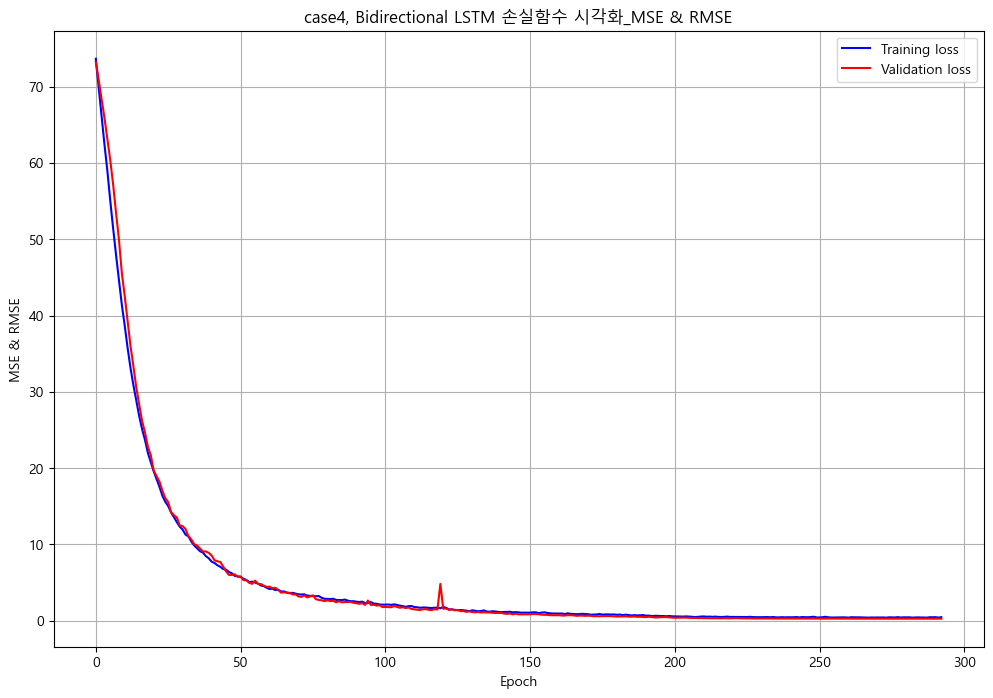

In [42]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention, Bidirectional
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = Bidirectional(LSTM(128, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case4_bi_rmse = Model(inputs=[numerical_input, categorical_input], outputs=output)
case4_bi_rmse.compile(optimizer=optimizer
                       , loss="mse"
                       , metrics=[metrics.RootMeanSquaredError()]
                      )

# 모델 학습
case4_bi_rmse_history = case4_bi_rmse.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case4_bi_rmse_history, "case4, Bidirectional LSTM", "MSE & RMSE")

# 모델 학습
case4_bi_rmse.save("./output/case4/case4_bi_rmse.h5")

# Case5) 3개 다 & 표준화

## 데이터 전처리

In [48]:
case5_df = data[['WTIO', 'SETIO', 'DMI', 'ONI', 'SOI', 'ENSO', 'D20_SCTR']]

case5_dts = case5_df.values
print(case5_dts.shape)

case5_label = case5_dts[ : , 5]
case5_dts = case5_dts[ : , [0, 1, 2, 3, 4, 6]]

case5_mean = case5_dts.mean(axis=0)
case5_std = case5_dts.std(axis=0)
case5_dts = (case5_dts-case5_mean)/case5_std

print(case5_dts.shape)

(400, 7)
(400, 6)


## 데이터 분리

In [49]:
# 학습 데이터
x_train_multi, y_train_multi = multivariate_data(case5_dts, case5_dts[:, -1], 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

x_train_label = label_split(case5_label, 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

# 검증 데이터
x_val_multi, y_val_multi = multivariate_data(case5_dts, case5_dts[:, -1], TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

x_val_label = label_split(case5_label, TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

# 테스트 데이터
x_test_multi, y_test_multi = multivariate_data(case5_dts, case5_dts[:, -1], TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

x_test_label = label_split(case5_label, TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

print(f"학습 데이터 형태: {x_train_multi.shape}")
print(f"학습 타겟데이터 형태: {y_train_multi.shape}")
print(f"학습 라벨데이터 형태: {x_train_label.shape}")
print("--------------------------------")
print(f"검증 데이터 형태: {x_val_multi.shape}")
print(f"검증 타겟데이터 형태: {y_val_multi.shape}")
print(f"검증 라벨데이터 형태: {x_val_label.shape}")
print("--------------------------------")
print(f"테스트 데이터 형태: {x_test_multi.shape}")
print(f"테스트 타겟데이터 형태: {y_test_multi.shape}")
print(f"테스트 라벨데이터 형태: {x_test_label.shape}")
print("--------------------------------")
print('과거 데이터 윈도우 형태: {}'.format(x_train_multi[0].shape))
print('예측 목표 기간 형태: {}'.format(y_train_multi[0].shape))

학습 데이터 형태: (256, 12, 6)
학습 타겟데이터 형태: (256, 12)
학습 라벨데이터 형태: (256, 12)
--------------------------------
검증 데이터 형태: (56, 12, 6)
검증 타겟데이터 형태: (56, 12)
검증 라벨데이터 형태: (56, 12)
--------------------------------
테스트 데이터 형태: (16, 12, 6)
테스트 타겟데이터 형태: (16, 12)
테스트 라벨데이터 형태: (16, 12)
--------------------------------
과거 데이터 윈도우 형태: (12, 6)
예측 목표 기간 형태: (12,)


## 모델 학습

### 단방향 LSTM

Epoch 1/300
16/16 [==============================] - 6s 94ms/step - loss: 22.1533 - val_loss: 21.0723 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 20ms/step - loss: 20.5188 - val_loss: 19.5295 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 17ms/step - loss: 18.9679 - val_loss: 18.0368 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 18ms/step - loss: 17.4663 - val_loss: 16.6099 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 18ms/step - loss: 16.0370 - val_loss: 15.2532 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 17ms/step - loss: 14.7145 - val_loss: 13.9750 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 18ms/step - loss: 13.4269 - val_loss: 12.7731 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 18ms/step - loss: 12.2496 - val_loss: 11.6529 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

16/16 [==============================] - 0s 21ms/step - loss: 1.5265 - val_loss: 1.6147 - lr: 5.0000e-04
Epoch 71/300
16/16 [==============================] - 0s 22ms/step - loss: 1.5107 - val_loss: 1.6394 - lr: 5.0000e-04
Epoch 72/300
16/16 [==============================] - 0s 19ms/step - loss: 1.4926 - val_loss: 1.5706 - lr: 5.0000e-04
Epoch 73/300
16/16 [==============================] - 0s 18ms/step - loss: 1.4719 - val_loss: 1.5565 - lr: 5.0000e-04
Epoch 74/300
16/16 [==============================] - 0s 16ms/step - loss: 1.4528 - val_loss: 1.5615 - lr: 5.0000e-04
Epoch 75/300
16/16 [==============================] - 0s 16ms/step - loss: 1.4384 - val_loss: 1.5272 - lr: 5.0000e-04
Epoch 76/300
16/16 [==============================] - 0s 18ms/step - loss: 1.4204 - val_loss: 1.5113 - lr: 5.0000e-04
Epoch 77/300
16/16 [==============================] - 0s 17ms/step - loss: 1.4170 - val_loss: 1.5594 - lr: 5.0000e-04
Epoch 78/300
16/16 [==============================] - 0s 16ms/step - 

13/16 [=======================>......] - ETA: 0s - loss: 0.7809
Epoch 138: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
16/16 [==============================] - 0s 17ms/step - loss: 0.7755 - val_loss: 0.9378 - lr: 2.5000e-04
Epoch 139/300
16/16 [==============================] - 0s 17ms/step - loss: 0.7677 - val_loss: 0.8990 - lr: 1.2500e-04
Epoch 140/300
16/16 [==============================] - 0s 17ms/step - loss: 0.7600 - val_loss: 0.9499 - lr: 1.2500e-04
Epoch 141/300
16/16 [==============================] - 0s 16ms/step - loss: 0.7635 - val_loss: 0.8937 - lr: 1.2500e-04
Epoch 142/300
16/16 [==============================] - 0s 15ms/step - loss: 0.7585 - val_loss: 0.9096 - lr: 1.2500e-04
Epoch 143/300
16/16 [==============================] - 0s 16ms/step - loss: 0.7526 - val_loss: 0.9246 - lr: 1.2500e-04
Epoch 144/300
16/16 [==============================] - 0s 16ms/step - loss: 0.7584 - val_loss: 0.8698 - lr: 1.2500e-04
Epoch 145/300
16/16 [==================

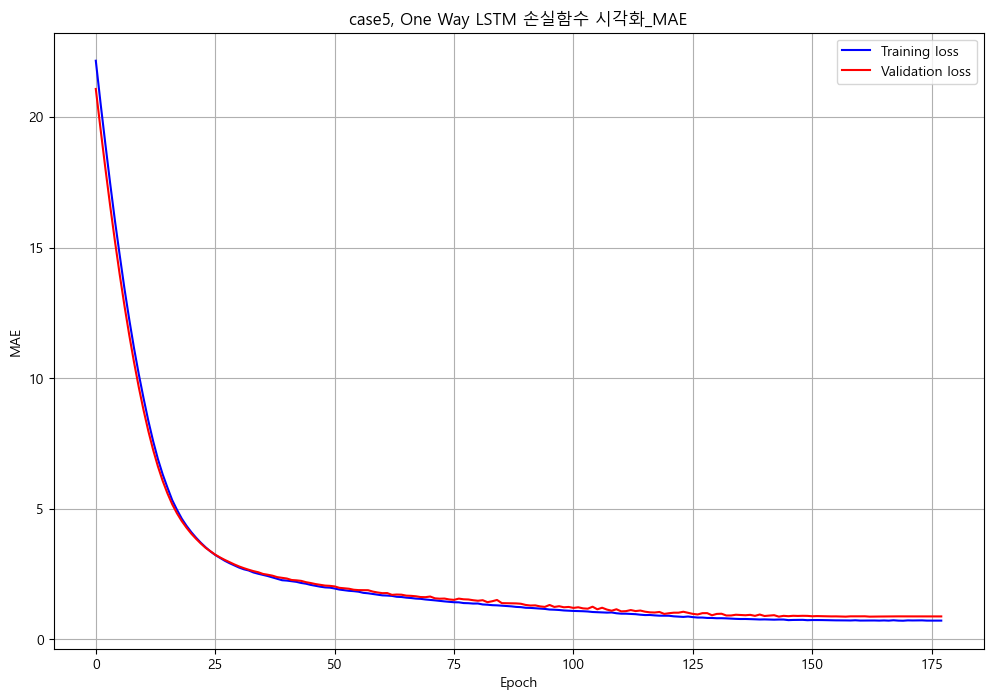

In [51]:
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import metrics
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
initial_lr = 0.0005

optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = LSTM(128, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = LSTM(64, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case5_uni_mae = Model(inputs=[numerical_input, categorical_input], outputs=output)
case5_uni_mae.compile(optimizer=optimizer, loss="mae")

# 모델 학습
case5_uni_mae_history = case5_uni_mae.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case5_uni_mae_history, "case5, One Way LSTM", "MAE")

# 모델 학습
case5_uni_mae.save("./output/case5/case5_uni_mae.h5")

Epoch 1/300
16/16 [==============================] - 5s 90ms/step - loss: 23.1062 - val_loss: 22.0133 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 17ms/step - loss: 22.0651 - val_loss: 21.2268 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 21ms/step - loss: 21.1278 - val_loss: 20.4096 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 16ms/step - loss: 20.1509 - val_loss: 19.5862 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 17ms/step - loss: 19.1775 - val_loss: 18.7480 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 18ms/step - loss: 18.2816 - val_loss: 17.9003 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 16ms/step - loss: 17.4034 - val_loss: 17.0609 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 18ms/step - loss: 16.5528 - val_loss: 16.2266 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

16/16 [==============================] - 0s 16ms/step - loss: 1.7402 - val_loss: 2.1600 - lr: 5.0000e-04
Epoch 71/300
16/16 [==============================] - 0s 18ms/step - loss: 1.7266 - val_loss: 2.0721 - lr: 5.0000e-04
Epoch 72/300
16/16 [==============================] - 0s 17ms/step - loss: 1.6987 - val_loss: 2.0271 - lr: 5.0000e-04
Epoch 73/300
16/16 [==============================] - 0s 15ms/step - loss: 1.7009 - val_loss: 2.0975 - lr: 5.0000e-04
Epoch 74/300
16/16 [==============================] - 0s 16ms/step - loss: 1.6706 - val_loss: 2.0424 - lr: 5.0000e-04
Epoch 75/300
16/16 [==============================] - 0s 16ms/step - loss: 1.6135 - val_loss: 2.0249 - lr: 5.0000e-04
Epoch 76/300
16/16 [==============================] - 0s 17ms/step - loss: 1.6054 - val_loss: 1.9613 - lr: 5.0000e-04
Epoch 77/300
16/16 [==============================] - 0s 17ms/step - loss: 1.6160 - val_loss: 2.0106 - lr: 5.0000e-04
Epoch 78/300
16/16 [==============================] - 0s 17ms/step - 

16/16 [==============================] - 0s 18ms/step - loss: 0.8796 - val_loss: 1.4281 - lr: 6.2500e-05
Epoch 136/300
16/16 [==============================] - 0s 16ms/step - loss: 0.8736 - val_loss: 1.4651 - lr: 6.2500e-05
Epoch 137/300
16/16 [==============================] - 0s 16ms/step - loss: 0.8810 - val_loss: 1.4429 - lr: 6.2500e-05
Epoch 138/300
16/16 [==============================] - 0s 16ms/step - loss: 0.8691 - val_loss: 1.4541 - lr: 6.2500e-05
Epoch 139/300
16/16 [==============================] - 0s 17ms/step - loss: 0.8829 - val_loss: 1.4198 - lr: 6.2500e-05
Epoch 140/300
16/16 [==============================] - 0s 17ms/step - loss: 0.8660 - val_loss: 1.4494 - lr: 6.2500e-05
Epoch 141/300
16/16 [==============================] - 0s 18ms/step - loss: 0.8826 - val_loss: 1.4378 - lr: 6.2500e-05
Epoch 142/300
16/16 [==============================] - 0s 17ms/step - loss: 0.8730 - val_loss: 1.4562 - lr: 6.2500e-05
Epoch 143/300
16/16 [==============================] - 0s 18ms

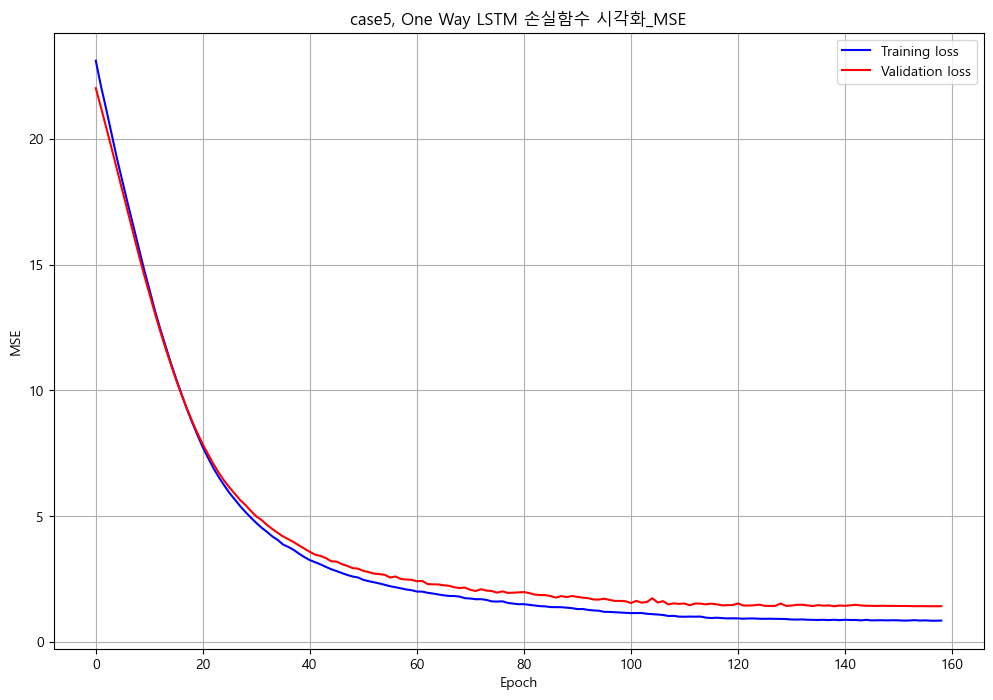

In [52]:
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
initial_lr = 0.0005

optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = LSTM(128, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = LSTM(64, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case5_uni_mse = Model(inputs=[numerical_input, categorical_input], outputs=output)
case5_uni_mse.compile(optimizer=optimizer, loss="mse" )

# 모델 학습
case5_uni_mse_history = case5_uni_mse.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case5_uni_mse_history, "case5, One Way LSTM", "MSE")

# 모델 학습
case5_uni_mse.save("./output/case5/case5_uni_mse.h5")

Epoch 1/300
16/16 [==============================] - 6s 103ms/step - loss: 23.0975 - root_mean_squared_error: 1.2759 - val_loss: 21.9791 - val_root_mean_squared_error: 0.9823 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 21ms/step - loss: 21.9341 - root_mean_squared_error: 1.1590 - val_loss: 21.0954 - val_root_mean_squared_error: 0.9970 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 21ms/step - loss: 20.8918 - root_mean_squared_error: 1.1100 - val_loss: 20.1764 - val_root_mean_squared_error: 1.0098 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 20ms/step - loss: 19.8405 - root_mean_squared_error: 1.0634 - val_loss: 19.2393 - val_root_mean_squared_error: 1.0185 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 17ms/step - loss: 18.8273 - root_mean_squared_error: 1.0354 - val_loss: 18.3021 - val_root_mean_squared_error: 1.0255 - lr: 5.0000e-04
Epoch 6/300
16/16 [=========================

16/16 [==============================] - 0s 17ms/step - loss: 2.7248 - root_mean_squared_error: 0.7631 - val_loss: 3.1213 - val_root_mean_squared_error: 1.0090 - lr: 5.0000e-04
Epoch 45/300
16/16 [==============================] - 0s 17ms/step - loss: 2.6659 - root_mean_squared_error: 0.7685 - val_loss: 2.9950 - val_root_mean_squared_error: 0.9745 - lr: 5.0000e-04
Epoch 46/300
16/16 [==============================] - 0s 16ms/step - loss: 2.5950 - root_mean_squared_error: 0.7628 - val_loss: 2.9649 - val_root_mean_squared_error: 0.9950 - lr: 5.0000e-04
Epoch 47/300
16/16 [==============================] - 0s 16ms/step - loss: 2.5187 - root_mean_squared_error: 0.7581 - val_loss: 2.8855 - val_root_mean_squared_error: 0.9862 - lr: 5.0000e-04
Epoch 48/300
16/16 [==============================] - 0s 15ms/step - loss: 2.4369 - root_mean_squared_error: 0.7429 - val_loss: 2.8221 - val_root_mean_squared_error: 0.9834 - lr: 5.0000e-04
Epoch 49/300
16/16 [==============================] - 0s 16ms/s

16/16 [==============================] - 0s 17ms/step - loss: 1.3274 - root_mean_squared_error: 0.7176 - val_loss: 1.7651 - val_root_mean_squared_error: 0.9812 - lr: 5.0000e-04
Epoch 88/300
16/16 [==============================] - 0s 16ms/step - loss: 1.3108 - root_mean_squared_error: 0.7185 - val_loss: 1.7330 - val_root_mean_squared_error: 0.9722 - lr: 5.0000e-04
Epoch 89/300
16/16 [==============================] - 0s 19ms/step - loss: 1.3134 - root_mean_squared_error: 0.7313 - val_loss: 1.7325 - val_root_mean_squared_error: 0.9829 - lr: 5.0000e-04
Epoch 90/300
16/16 [==============================] - 0s 17ms/step - loss: 1.2775 - root_mean_squared_error: 0.7188 - val_loss: 1.7927 - val_root_mean_squared_error: 1.0189 - lr: 5.0000e-04
Epoch 91/300
16/16 [==============================] - 0s 16ms/step - loss: 1.2620 - root_mean_squared_error: 0.7170 - val_loss: 1.6982 - val_root_mean_squared_error: 0.9795 - lr: 5.0000e-04
Epoch 92/300
16/16 [==============================] - 0s 16ms/s

16/16 [==============================] - 0s 16ms/step - loss: 0.9298 - root_mean_squared_error: 0.6879 - val_loss: 1.4739 - val_root_mean_squared_error: 1.0088 - lr: 6.2500e-05
Epoch 128/300
16/16 [==============================] - 0s 16ms/step - loss: 0.9432 - root_mean_squared_error: 0.6980 - val_loss: 1.4715 - val_root_mean_squared_error: 1.0080 - lr: 6.2500e-05
Epoch 129/300
16/16 [==============================] - 0s 17ms/step - loss: 0.9116 - root_mean_squared_error: 0.6761 - val_loss: 1.4703 - val_root_mean_squared_error: 1.0084 - lr: 6.2500e-05
Epoch 130/300
16/16 [==============================] - 0s 15ms/step - loss: 0.9286 - root_mean_squared_error: 0.6896 - val_loss: 1.4810 - val_root_mean_squared_error: 1.0142 - lr: 6.2500e-05
Epoch 131/300
14/16 [=========================>....] - ETA: 0s - loss: 0.9231 - root_mean_squared_error: 0.6865
Epoch 131: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
16/16 [==============================] - 0s 16ms/step - loss

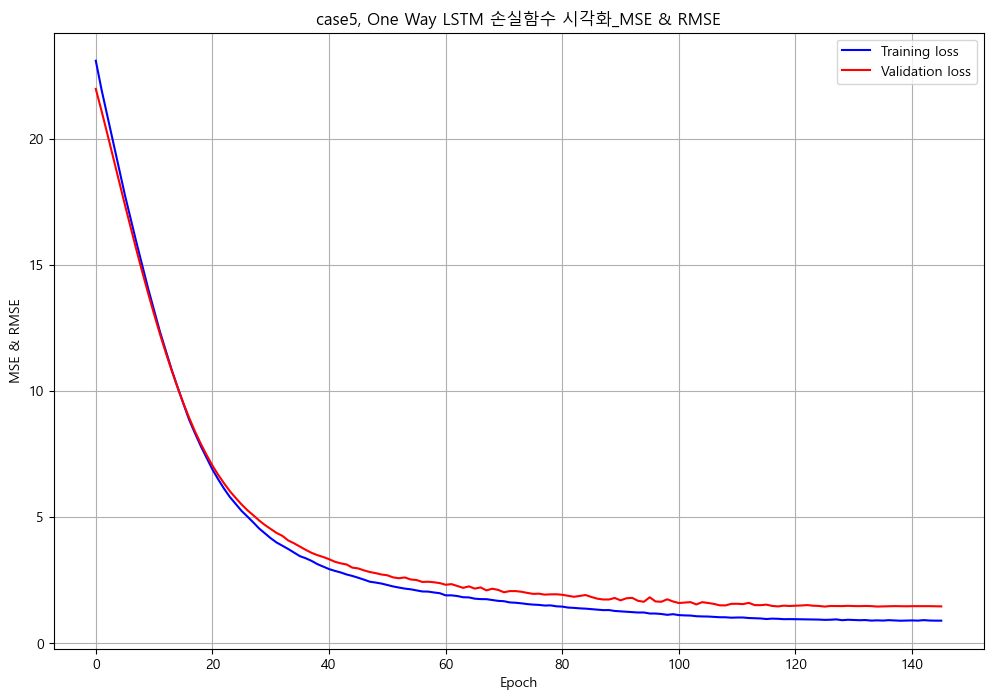

In [53]:
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
initial_lr = 0.0005

optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = LSTM(128, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = LSTM(64, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case5_uni_rmse = Model(inputs=[numerical_input, categorical_input], outputs=output)
case5_uni_rmse.compile(optimizer=optimizer
                       , loss="mse"
                       , metrics=[metrics.RootMeanSquaredError()]
                      )

# 모델 학습
case5_uni_rmse_history = case5_uni_rmse.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case5_uni_rmse_history, "case5, One Way LSTM", "MSE & RMSE")

# 모델 학습
case5_uni_rmse.save("./output/case5/case5_uni_rmse.h5")

### 양방향 LSTM

Epoch 1/300
16/16 [==============================] - 8s 130ms/step - loss: 54.8474 - val_loss: 51.5072 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 27ms/step - loss: 49.1509 - val_loss: 46.1138 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 26ms/step - loss: 43.8357 - val_loss: 40.9937 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 26ms/step - loss: 38.8039 - val_loss: 36.2194 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 24ms/step - loss: 34.1728 - val_loss: 31.7932 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 25ms/step - loss: 29.9206 - val_loss: 27.7571 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 24ms/step - loss: 26.0433 - val_loss: 24.0991 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 28ms/step - loss: 22.5310 - val_loss: 20.8094 - lr: 5.0000e-04
Epoch 9/300
16/16 [============================

16/16 [==============================] - 0s 23ms/step - loss: 2.2468 - val_loss: 2.3860 - lr: 5.0000e-04
Epoch 71/300
16/16 [==============================] - 0s 24ms/step - loss: 2.2217 - val_loss: 2.2624 - lr: 5.0000e-04
Epoch 72/300
16/16 [==============================] - 0s 29ms/step - loss: 2.1861 - val_loss: 2.2460 - lr: 5.0000e-04
Epoch 73/300
16/16 [==============================] - 0s 24ms/step - loss: 2.1689 - val_loss: 2.2395 - lr: 5.0000e-04
Epoch 74/300
16/16 [==============================] - 0s 25ms/step - loss: 2.1226 - val_loss: 2.2377 - lr: 5.0000e-04
Epoch 75/300
16/16 [==============================] - 0s 24ms/step - loss: 2.1129 - val_loss: 2.2277 - lr: 5.0000e-04
Epoch 76/300
16/16 [==============================] - 0s 22ms/step - loss: 2.0745 - val_loss: 2.2009 - lr: 5.0000e-04
Epoch 77/300
16/16 [==============================] - 0s 24ms/step - loss: 2.0533 - val_loss: 2.1576 - lr: 5.0000e-04
Epoch 78/300
16/16 [==============================] - 0s 23ms/step - 

16/16 [==============================] - 0s 25ms/step - loss: 0.8674 - val_loss: 0.9931 - lr: 5.0000e-04
Epoch 140/300
16/16 [==============================] - 0s 23ms/step - loss: 0.8485 - val_loss: 1.0043 - lr: 5.0000e-04
Epoch 141/300
16/16 [==============================] - 0s 24ms/step - loss: 0.8301 - val_loss: 0.9356 - lr: 5.0000e-04
Epoch 142/300
16/16 [==============================] - 0s 25ms/step - loss: 0.8177 - val_loss: 0.9865 - lr: 5.0000e-04
Epoch 143/300
16/16 [==============================] - 0s 25ms/step - loss: 0.8140 - val_loss: 0.9556 - lr: 5.0000e-04
Epoch 144/300
16/16 [==============================] - 0s 25ms/step - loss: 0.8162 - val_loss: 0.9770 - lr: 5.0000e-04
Epoch 145/300
16/16 [==============================] - 0s 24ms/step - loss: 0.7930 - val_loss: 0.9253 - lr: 5.0000e-04
Epoch 146/300
16/16 [==============================] - 0s 24ms/step - loss: 0.7626 - val_loss: 0.9110 - lr: 5.0000e-04
Epoch 147/300
16/16 [==============================] - 0s 24ms

16/16 [==============================] - 0s 24ms/step - loss: 0.5838 - val_loss: 0.7383 - lr: 3.1250e-05
Epoch 204/300
16/16 [==============================] - 0s 25ms/step - loss: 0.5827 - val_loss: 0.7387 - lr: 3.1250e-05
Epoch 205/300
16/16 [==============================] - 0s 26ms/step - loss: 0.5742 - val_loss: 0.7385 - lr: 3.1250e-05
Epoch 206/300
16/16 [==============================] - 0s 23ms/step - loss: 0.5923 - val_loss: 0.7337 - lr: 3.1250e-05
Epoch 207/300
16/16 [==============================] - ETA: 0s - loss: 0.5879
Epoch 207: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
16/16 [==============================] - 0s 24ms/step - loss: 0.5879 - val_loss: 0.7426 - lr: 3.1250e-05
Epoch 208/300
16/16 [==============================] - 0s 26ms/step - loss: 0.5723 - val_loss: 0.7382 - lr: 1.5625e-05
Epoch 209/300
16/16 [==============================] - 0s 24ms/step - loss: 0.5736 - val_loss: 0.7393 - lr: 1.5625e-05
Epoch 210/300
16/16 [=================

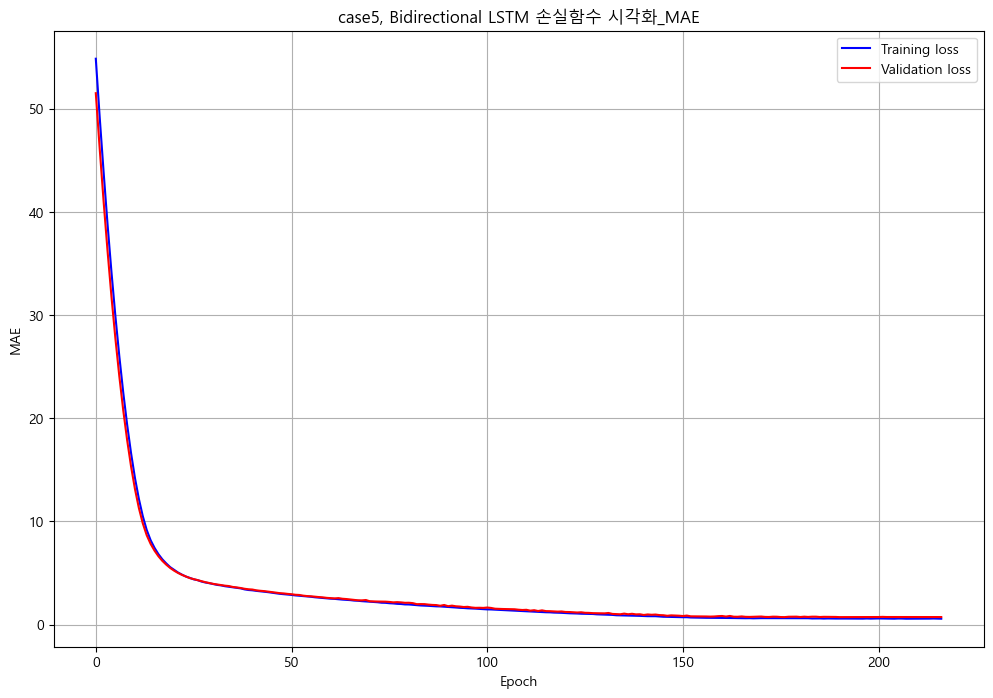

In [54]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention, Bidirectional
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
initial_lr = 0.0005

optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = Bidirectional(LSTM(128, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case5_bi_mae = Model(inputs=[numerical_input, categorical_input], outputs=output)
case5_bi_mae.compile(optimizer=optimizer, loss="mae")

# 모델 학습
case5_bi_mae_history = case5_bi_mae.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case5_bi_mae_history, "case5, Bidirectional LSTM", "MAE")

# 모델 저장
case5_bi_mae.save("./output/case5/case5_bi_mae.h5")

Epoch 1/300
16/16 [==============================] - 8s 130ms/step - loss: 56.7539 - val_loss: 54.2434 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 23ms/step - loss: 53.0053 - val_loss: 50.7290 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 26ms/step - loss: 49.2814 - val_loss: 47.1633 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 26ms/step - loss: 45.5990 - val_loss: 43.6348 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 23ms/step - loss: 42.0276 - val_loss: 40.2072 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 23ms/step - loss: 38.5318 - val_loss: 36.8900 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 22ms/step - loss: 35.2835 - val_loss: 33.7252 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 25ms/step - loss: 32.1632 - val_loss: 30.7268 - lr: 5.0000e-04
Epoch 9/300
16/16 [============================

16/16 [==============================] - 0s 25ms/step - loss: 2.4127 - val_loss: 2.7950 - lr: 5.0000e-04
Epoch 71/300
16/16 [==============================] - 0s 24ms/step - loss: 2.3945 - val_loss: 2.7406 - lr: 5.0000e-04
Epoch 72/300
16/16 [==============================] - 0s 24ms/step - loss: 2.3715 - val_loss: 2.7286 - lr: 5.0000e-04
Epoch 73/300
16/16 [==============================] - 0s 27ms/step - loss: 2.3283 - val_loss: 2.6752 - lr: 5.0000e-04
Epoch 74/300
16/16 [==============================] - 0s 24ms/step - loss: 2.2640 - val_loss: 2.6625 - lr: 5.0000e-04
Epoch 75/300
16/16 [==============================] - 0s 24ms/step - loss: 2.2397 - val_loss: 2.5830 - lr: 5.0000e-04
Epoch 76/300
16/16 [==============================] - 0s 24ms/step - loss: 2.1853 - val_loss: 2.5776 - lr: 5.0000e-04
Epoch 77/300
16/16 [==============================] - 0s 23ms/step - loss: 2.2034 - val_loss: 2.5886 - lr: 5.0000e-04
Epoch 78/300
16/16 [==============================] - 0s 24ms/step - 

16/16 [==============================] - ETA: 0s - loss: 0.8518
Epoch 139: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
16/16 [==============================] - 0s 23ms/step - loss: 0.8518 - val_loss: 1.3728 - lr: 5.0000e-04
Epoch 140/300
16/16 [==============================] - 0s 26ms/step - loss: 0.8200 - val_loss: 1.2856 - lr: 2.5000e-04
Epoch 141/300
16/16 [==============================] - 0s 25ms/step - loss: 0.7787 - val_loss: 1.2601 - lr: 2.5000e-04
Epoch 142/300
16/16 [==============================] - 0s 24ms/step - loss: 0.7660 - val_loss: 1.2931 - lr: 2.5000e-04
Epoch 143/300
16/16 [==============================] - 0s 23ms/step - loss: 0.7654 - val_loss: 1.2897 - lr: 2.5000e-04
Epoch 144/300
16/16 [==============================] - 0s 24ms/step - loss: 0.7428 - val_loss: 1.2022 - lr: 2.5000e-04
Epoch 145/300
16/16 [==============================] - 0s 25ms/step - loss: 0.7449 - val_loss: 1.2614 - lr: 2.5000e-04
Epoch 146/300
16/16 [==================

16/16 [==============================] - 0s 23ms/step - loss: 0.5659 - val_loss: 1.0949 - lr: 7.8125e-06
Epoch 201/300
16/16 [==============================] - 0s 25ms/step - loss: 0.5613 - val_loss: 1.0943 - lr: 3.9063e-06
Epoch 202/300
16/16 [==============================] - 0s 23ms/step - loss: 0.5684 - val_loss: 1.0952 - lr: 3.9063e-06
Epoch 203/300
16/16 [==============================] - 0s 23ms/step - loss: 0.5526 - val_loss: 1.0934 - lr: 3.9063e-06
Epoch 204/300
16/16 [==============================] - 0s 24ms/step - loss: 0.5521 - val_loss: 1.0935 - lr: 3.9063e-06
Epoch 205/300
16/16 [==============================] - ETA: 0s - loss: 0.5495
Epoch 205: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
16/16 [==============================] - 0s 23ms/step - loss: 0.5495 - val_loss: 1.0930 - lr: 3.9063e-06
Epoch 206/300
16/16 [==============================] - 0s 26ms/step - loss: 0.5579 - val_loss: 1.0912 - lr: 1.9531e-06
Epoch 207/300
16/16 [=================

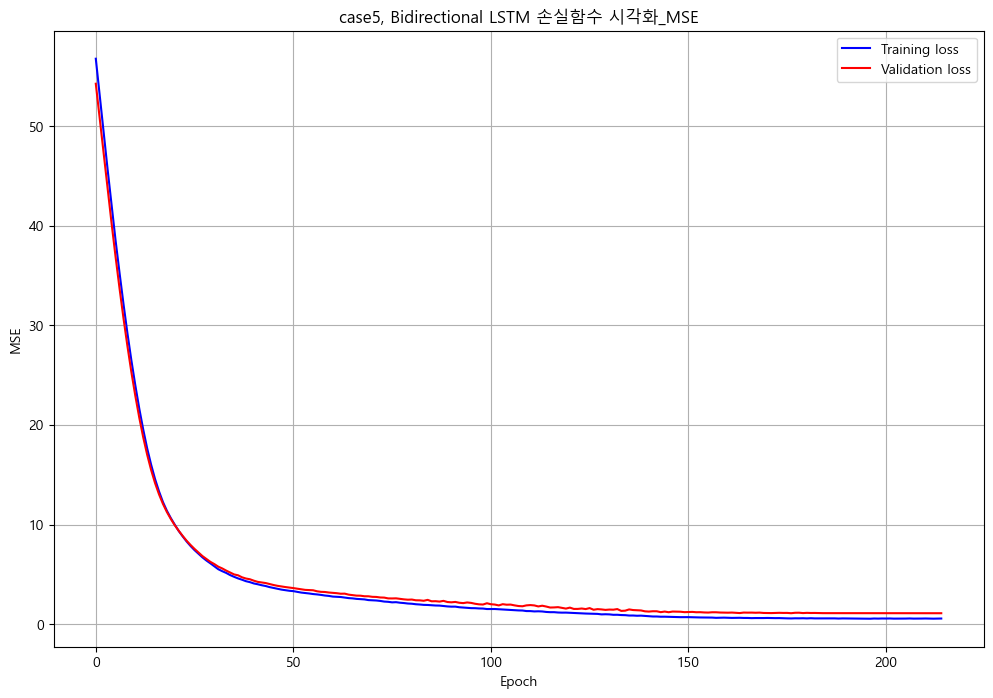

In [55]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention, Bidirectional
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
initial_lr = 0.0005

optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = Bidirectional(LSTM(128, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case5_bi_mse = Model(inputs=[numerical_input, categorical_input], outputs=output)
case5_bi_mse.compile(optimizer=optimizer, loss="mse")

# 모델 학습
case5_bi_mse_history = case5_bi_mse.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case5_bi_mse_history, "case5, Bidirectional LSTM", "MSE")

# 모델 저장
case5_bi_mse.save("./output/case5/case5_bi_mse.h5")

Epoch 1/300
16/16 [==============================] - 10s 177ms/step - loss: 56.4345 - root_mean_squared_error: 1.2072 - val_loss: 54.0478 - val_root_mean_squared_error: 0.9725 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 24ms/step - loss: 52.6452 - root_mean_squared_error: 1.1244 - val_loss: 50.3457 - val_root_mean_squared_error: 0.9673 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 30ms/step - loss: 48.7163 - root_mean_squared_error: 1.0326 - val_loss: 46.5839 - val_root_mean_squared_error: 0.9659 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 30ms/step - loss: 44.9283 - root_mean_squared_error: 1.0088 - val_loss: 42.8860 - val_root_mean_squared_error: 0.9641 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 28ms/step - loss: 41.2233 - root_mean_squared_error: 0.9775 - val_loss: 39.3005 - val_root_mean_squared_error: 0.9618 - lr: 5.0000e-04
Epoch 6/300
16/16 [========================

Epoch 44/300
16/16 [==============================] - 0s 27ms/step - loss: 3.6667 - root_mean_squared_error: 0.7782 - val_loss: 4.0472 - val_root_mean_squared_error: 1.0059 - lr: 5.0000e-04
Epoch 45/300
16/16 [==============================] - 0s 28ms/step - loss: 3.6005 - root_mean_squared_error: 0.7726 - val_loss: 3.9002 - val_root_mean_squared_error: 0.9689 - lr: 5.0000e-04
Epoch 46/300
16/16 [==============================] - 0s 27ms/step - loss: 3.5445 - root_mean_squared_error: 0.7836 - val_loss: 3.7976 - val_root_mean_squared_error: 0.9448 - lr: 5.0000e-04
Epoch 47/300
16/16 [==============================] - 0s 27ms/step - loss: 3.4597 - root_mean_squared_error: 0.7639 - val_loss: 3.8007 - val_root_mean_squared_error: 0.9821 - lr: 5.0000e-04
Epoch 48/300
16/16 [==============================] - 0s 26ms/step - loss: 3.3576 - root_mean_squared_error: 0.7500 - val_loss: 3.7216 - val_root_mean_squared_error: 0.9799 - lr: 5.0000e-04
Epoch 49/300
16/16 [==============================

16/16 [==============================] - 0s 24ms/step - loss: 1.8498 - root_mean_squared_error: 0.7246 - val_loss: 2.2509 - val_root_mean_squared_error: 0.9691 - lr: 5.0000e-04
Epoch 88/300
16/16 [==============================] - 0s 23ms/step - loss: 1.8615 - root_mean_squared_error: 0.7472 - val_loss: 2.2974 - val_root_mean_squared_error: 1.0006 - lr: 5.0000e-04
Epoch 89/300
16/16 [==============================] - 0s 25ms/step - loss: 1.8155 - root_mean_squared_error: 0.7295 - val_loss: 2.2686 - val_root_mean_squared_error: 1.0004 - lr: 5.0000e-04
Epoch 90/300
16/16 [==============================] - 0s 24ms/step - loss: 1.7914 - root_mean_squared_error: 0.7258 - val_loss: 2.3313 - val_root_mean_squared_error: 1.0382 - lr: 5.0000e-04
Epoch 91/300
16/16 [==============================] - 0s 25ms/step - loss: 1.7427 - root_mean_squared_error: 0.7117 - val_loss: 2.2378 - val_root_mean_squared_error: 1.0083 - lr: 5.0000e-04
Epoch 92/300
16/16 [==============================] - 0s 26ms/s

16/16 [==============================] - 0s 24ms/step - loss: 1.0589 - root_mean_squared_error: 0.7004 - val_loss: 1.6096 - val_root_mean_squared_error: 1.0231 - lr: 2.5000e-04
Epoch 130/300
16/16 [==============================] - 0s 24ms/step - loss: 1.0572 - root_mean_squared_error: 0.7063 - val_loss: 1.4652 - val_root_mean_squared_error: 0.9538 - lr: 2.5000e-04
Epoch 131/300
16/16 [==============================] - 0s 24ms/step - loss: 1.0225 - root_mean_squared_error: 0.6867 - val_loss: 1.5118 - val_root_mean_squared_error: 0.9828 - lr: 2.5000e-04
Epoch 132/300
16/16 [==============================] - 0s 24ms/step - loss: 1.0227 - root_mean_squared_error: 0.6938 - val_loss: 1.5770 - val_root_mean_squared_error: 1.0199 - lr: 2.5000e-04
Epoch 133/300
16/16 [==============================] - 0s 24ms/step - loss: 1.0082 - root_mean_squared_error: 0.6905 - val_loss: 1.5078 - val_root_mean_squared_error: 0.9912 - lr: 2.5000e-04
Epoch 134/300
16/16 [==============================] - 0s 2

16/16 [==============================] - 0s 24ms/step - loss: 0.8401 - root_mean_squared_error: 0.6703 - val_loss: 1.3940 - val_root_mean_squared_error: 1.0019 - lr: 3.1250e-05
Epoch 170/300
16/16 [==============================] - 0s 26ms/step - loss: 0.8406 - root_mean_squared_error: 0.6716 - val_loss: 1.3961 - val_root_mean_squared_error: 1.0036 - lr: 3.1250e-05
Epoch 171/300
16/16 [==============================] - 0s 25ms/step - loss: 0.8572 - root_mean_squared_error: 0.6848 - val_loss: 1.4001 - val_root_mean_squared_error: 1.0061 - lr: 3.1250e-05
Epoch 172/300
16/16 [==============================] - 0s 24ms/step - loss: 0.8481 - root_mean_squared_error: 0.6786 - val_loss: 1.3829 - val_root_mean_squared_error: 0.9979 - lr: 3.1250e-05
Epoch 173/300
16/16 [==============================] - ETA: 0s - loss: 0.8432 - root_mean_squared_error: 0.6759
Epoch 173: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
16/16 [==============================] - 0s 24ms/step - los

16/16 [==============================] - ETA: 0s - loss: 0.8213 - root_mean_squared_error: 0.6694
Epoch 208: ReduceLROnPlateau reducing learning rate to 1e-06.
16/16 [==============================] - 0s 23ms/step - loss: 0.8213 - root_mean_squared_error: 0.6694 - val_loss: 1.3744 - val_root_mean_squared_error: 1.0007 - lr: 1.9531e-06
Epoch 209/300
16/16 [==============================] - 0s 25ms/step - loss: 0.8228 - root_mean_squared_error: 0.6706 - val_loss: 1.3745 - val_root_mean_squared_error: 1.0008 - lr: 1.0000e-06
Epoch 210/300
16/16 [==============================] - 0s 26ms/step - loss: 0.8386 - root_mean_squared_error: 0.6824 - val_loss: 1.3735 - val_root_mean_squared_error: 1.0003 - lr: 1.0000e-06
Epoch 211/300
16/16 [==============================] - 0s 24ms/step - loss: 0.8273 - root_mean_squared_error: 0.6741 - val_loss: 1.3730 - val_root_mean_squared_error: 1.0001 - lr: 1.0000e-06
Epoch 212/300
16/16 [==============================] - 0s 24ms/step - loss: 0.8352 - root_

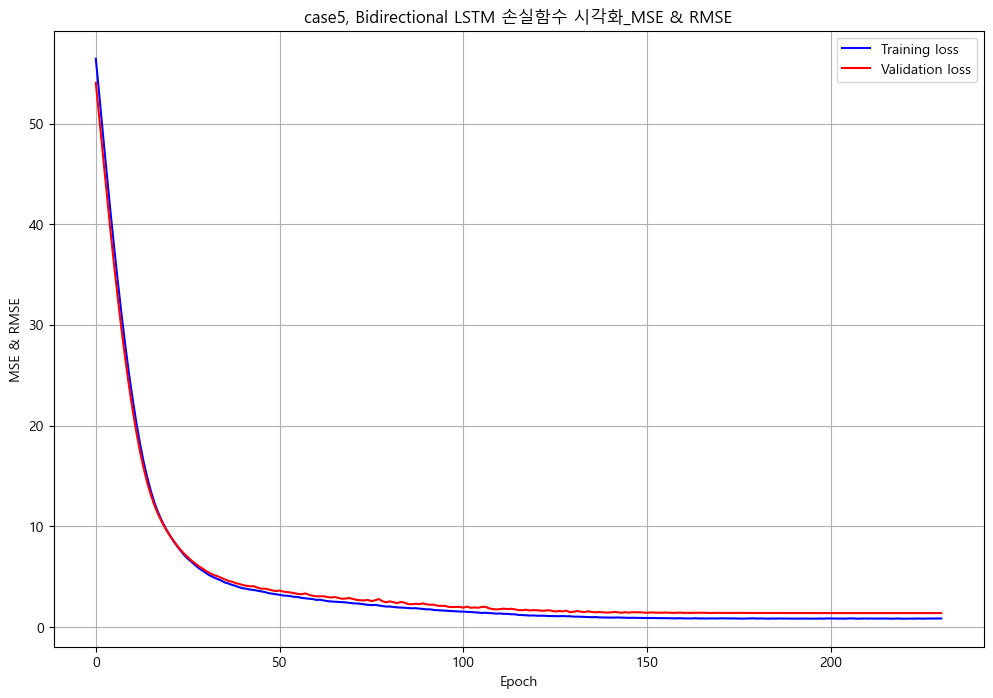

In [56]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention, Bidirectional
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
initial_lr = 0.0005

optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = Bidirectional(LSTM(128, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case5_bi_rmse = Model(inputs=[numerical_input, categorical_input], outputs=output)
case5_bi_rmse.compile(optimizer=optimizer
                       , loss="mse"
                       , metrics=[metrics.RootMeanSquaredError()]
                      )

# 모델 학습
case5_bi_rmse_history = case5_bi_rmse.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case5_bi_rmse_history, "case5, Bidirectional LSTM", "MSE & RMSE")

# 모델 저장
case5_bi_rmse.save("./output/case5/case5_bi_rmse.h5")

# Case6) 3개 다 & 로그 변환

## 데이터 전처리

### 부호 유지 로그 변환

In [51]:
case6_df = data[['WTIO', 'SETIO', 'DMI', 'ONI', 'SOI', 'ENSO', 'D20_SCTR']]

case6_dts = case6_df.values
print(case6_dts.shape)

case6_label = case6_dts[ : , 5]
case6_dts = case6_dts[ : , [0, 1, 2, 3, 4, 6]]

case6_dts = np.sign(case6_dts) * np.log1p(np.abs(case6_dts))
print(case6_dts.shape)

(400, 7)
(400, 6)


## 데이터 분리

In [52]:
# 학습 데이터
x_train_multi, y_train_multi = multivariate_data(case6_dts, case6_dts[:, -1], 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

x_train_label = label_split(case6_label, 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

# 검증 데이터
x_val_multi, y_val_multi = multivariate_data(case6_dts, case6_dts[:, -1], TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

x_val_label = label_split(case6_label, TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

# 테스트 데이터
x_test_multi, y_test_multi = multivariate_data(case6_dts, case6_dts[:, -1], TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

x_test_label = label_split(case6_label, TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

print(f"학습 데이터 형태: {x_train_multi.shape}")
print(f"학습 타겟데이터 형태: {y_train_multi.shape}")
print(f"학습 라벨데이터 형태: {x_train_label.shape}")
print("--------------------------------")
print(f"검증 데이터 형태: {x_val_multi.shape}")
print(f"검증 타겟데이터 형태: {y_val_multi.shape}")
print(f"검증 라벨데이터 형태: {x_val_label.shape}")
print("--------------------------------")
print(f"테스트 데이터 형태: {x_test_multi.shape}")
print(f"테스트 타겟데이터 형태: {y_test_multi.shape}")
print(f"테스트 라벨데이터 형태: {x_test_label.shape}")
print("--------------------------------")
print('과거 데이터 윈도우 형태: {}'.format(x_train_multi[0].shape))
print('예측 목표 기간 형태: {}'.format(y_train_multi[0].shape))

학습 데이터 형태: (256, 12, 6)
학습 타겟데이터 형태: (256, 12)
학습 라벨데이터 형태: (256, 12)
--------------------------------
검증 데이터 형태: (56, 12, 6)
검증 타겟데이터 형태: (56, 12)
검증 라벨데이터 형태: (56, 12)
--------------------------------
테스트 데이터 형태: (16, 12, 6)
테스트 타겟데이터 형태: (16, 12)
테스트 라벨데이터 형태: (16, 12)
--------------------------------
과거 데이터 윈도우 형태: (12, 6)
예측 목표 기간 형태: (12,)


## 모델 학습

### 단방향 LSTM

Epoch 1/300
16/16 [==============================] - 4s 56ms/step - loss: 24.9460 - val_loss: 24.2901 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 12ms/step - loss: 22.8987 - val_loss: 22.4975 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 11ms/step - loss: 20.9585 - val_loss: 20.7878 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 12ms/step - loss: 19.0753 - val_loss: 19.1758 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 12ms/step - loss: 17.3444 - val_loss: 17.6377 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 12ms/step - loss: 15.7068 - val_loss: 16.2239 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 11ms/step - loss: 14.2041 - val_loss: 14.8996 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 12ms/step - loss: 12.7621 - val_loss: 13.6427 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

Epoch 130/300
16/16 [==============================] - 0s 11ms/step - loss: 1.5209 - val_loss: 1.2155 - lr: 1.9531e-06
Epoch 131/300
16/16 [==============================] - 0s 11ms/step - loss: 1.5345 - val_loss: 1.2147 - lr: 1.9531e-06
Epoch 132/300
16/16 [==============================] - 0s 11ms/step - loss: 1.5268 - val_loss: 1.2135 - lr: 1.9531e-06
Epoch 133/300
16/16 [==============================] - 0s 11ms/step - loss: 1.5575 - val_loss: 1.2139 - lr: 1.9531e-06
Epoch 134/300
13/16 [=======================>......] - ETA: 0s - loss: 1.5275
Epoch 134: ReduceLROnPlateau reducing learning rate to 1e-06.
16/16 [==============================] - 0s 11ms/step - loss: 1.5348 - val_loss: 1.2145 - lr: 1.9531e-06
Epoch 135/300
16/16 [==============================] - 0s 11ms/step - loss: 1.5492 - val_loss: 1.2160 - lr: 1.0000e-06


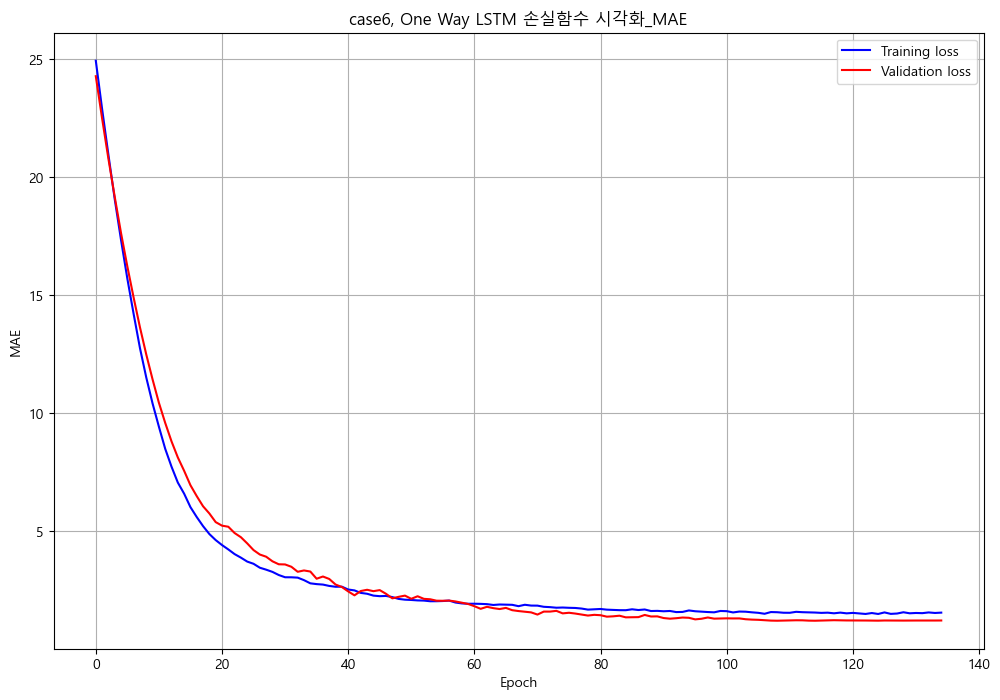

In [53]:
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = LSTM(128, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = LSTM(64, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case6_uni_mae = Model(inputs=[numerical_input, categorical_input], outputs=output)
case6_uni_mae.compile(optimizer=optimizer, loss="mae")

# 모델 학습
case6_uni_mae_history = case6_uni_mae.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case6_uni_mae_history, "case6, One Way LSTM", "MAE")

# 모델 저장
case6_uni_mae.save("./output/case6/case6_uni_mae.h5")

Epoch 1/300
16/16 [==============================] - 4s 57ms/step - loss: 42.6407 - val_loss: 40.3962 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 12ms/step - loss: 39.9709 - val_loss: 39.4067 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 12ms/step - loss: 37.9562 - val_loss: 38.2153 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 11ms/step - loss: 35.9012 - val_loss: 37.0619 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 11ms/step - loss: 33.9664 - val_loss: 35.8413 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 12ms/step - loss: 31.9079 - val_loss: 34.5689 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 11ms/step - loss: 29.6523 - val_loss: 32.6165 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 12ms/step - loss: 27.5783 - val_loss: 30.4078 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

16/16 [==============================] - 0s 11ms/step - loss: 3.1642 - val_loss: 2.6519 - lr: 5.0000e-04
Epoch 71/300
16/16 [==============================] - 0s 11ms/step - loss: 3.0385 - val_loss: 2.5213 - lr: 5.0000e-04
Epoch 72/300
16/16 [==============================] - 0s 12ms/step - loss: 2.9258 - val_loss: 2.5040 - lr: 5.0000e-04
Epoch 73/300
16/16 [==============================] - 0s 11ms/step - loss: 2.8453 - val_loss: 2.3954 - lr: 5.0000e-04
Epoch 74/300
16/16 [==============================] - 0s 11ms/step - loss: 2.8169 - val_loss: 2.3599 - lr: 5.0000e-04
Epoch 75/300
16/16 [==============================] - 0s 11ms/step - loss: 2.7289 - val_loss: 2.2896 - lr: 5.0000e-04
Epoch 76/300
16/16 [==============================] - 0s 11ms/step - loss: 2.6295 - val_loss: 2.2793 - lr: 5.0000e-04
Epoch 77/300
16/16 [==============================] - 0s 12ms/step - loss: 2.5697 - val_loss: 2.2453 - lr: 5.0000e-04
Epoch 78/300
16/16 [==============================] - 0s 11ms/step - 

16/16 [==============================] - 0s 12ms/step - loss: 0.6262 - val_loss: 0.3328 - lr: 1.2500e-04
Epoch 206/300
16/16 [==============================] - 0s 11ms/step - loss: 0.5497 - val_loss: 0.3335 - lr: 1.2500e-04
Epoch 207/300
16/16 [==============================] - 0s 12ms/step - loss: 0.5723 - val_loss: 0.3236 - lr: 1.2500e-04
Epoch 208/300
16/16 [==============================] - 0s 11ms/step - loss: 0.5248 - val_loss: 0.3247 - lr: 1.2500e-04
Epoch 209/300
16/16 [==============================] - 0s 11ms/step - loss: 0.6055 - val_loss: 0.3333 - lr: 1.2500e-04
Epoch 210/300
16/16 [==============================] - 0s 11ms/step - loss: 0.5550 - val_loss: 0.3272 - lr: 1.2500e-04
Epoch 211/300
16/16 [==============================] - 0s 11ms/step - loss: 0.5623 - val_loss: 0.3173 - lr: 1.2500e-04
Epoch 212/300
16/16 [==============================] - 0s 11ms/step - loss: 0.5653 - val_loss: 0.3187 - lr: 1.2500e-04
Epoch 213/300
16/16 [==============================] - 0s 11ms

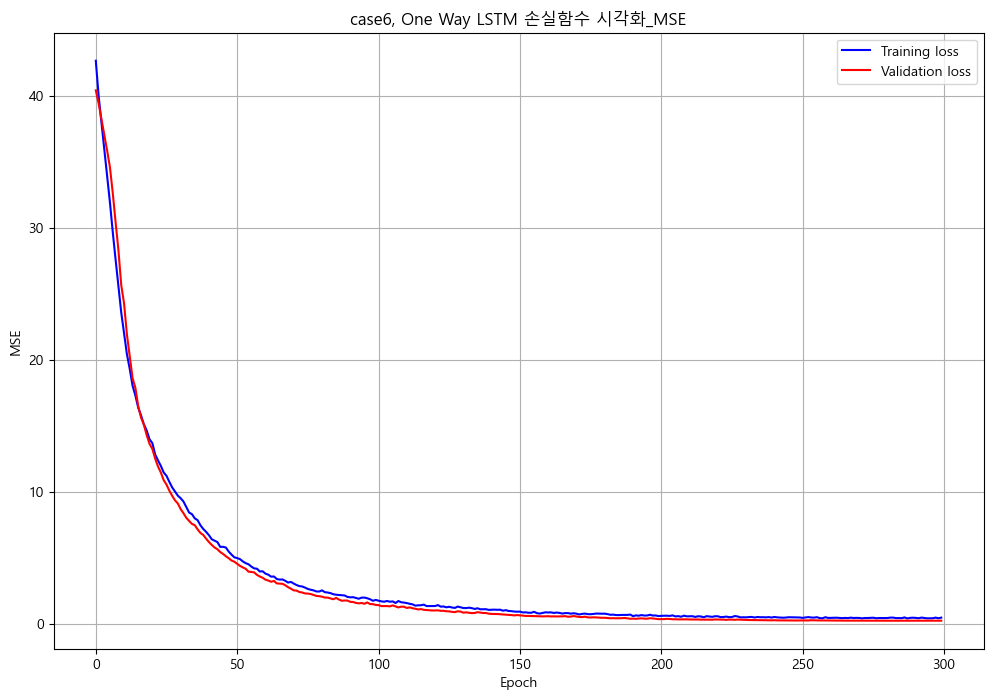

In [54]:
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = LSTM(128, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = LSTM(64, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case6_uni_mse = Model(inputs=[numerical_input, categorical_input], outputs=output)
case6_uni_mse.compile(optimizer=optimizer, loss="mse")

# 모델 학습
case6_uni_mse_history = case6_uni_mse.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case6_uni_mse_history, "case6, One Way LSTM", "MSE")

# 모델 저장
case6_uni_mse.save("./output/case6/case6_uni_mse.h5")

Epoch 1/300
16/16 [==============================] - 4s 57ms/step - loss: 41.6046 - root_mean_squared_error: 4.4637 - val_loss: 40.5261 - val_root_mean_squared_error: 4.3626 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 12ms/step - loss: 38.9838 - root_mean_squared_error: 4.2033 - val_loss: 39.6183 - val_root_mean_squared_error: 4.3023 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 12ms/step - loss: 36.5057 - root_mean_squared_error: 3.9488 - val_loss: 38.4589 - val_root_mean_squared_error: 4.2160 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 12ms/step - loss: 34.4301 - root_mean_squared_error: 3.7356 - val_loss: 37.1438 - val_root_mean_squared_error: 4.1121 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 12ms/step - loss: 32.0639 - root_mean_squared_error: 3.4706 - val_loss: 35.6608 - val_root_mean_squared_error: 3.9860 - lr: 5.0000e-04
Epoch 6/300
16/16 [==========================

Epoch 44/300
16/16 [==============================] - 0s 12ms/step - loss: 6.5231 - root_mean_squared_error: 0.9153 - val_loss: 5.9821 - val_root_mean_squared_error: 0.6180 - lr: 5.0000e-04
Epoch 45/300
16/16 [==============================] - 0s 12ms/step - loss: 6.1579 - root_mean_squared_error: 0.8004 - val_loss: 5.7579 - val_root_mean_squared_error: 0.5774 - lr: 5.0000e-04
Epoch 46/300
16/16 [==============================] - 0s 12ms/step - loss: 5.9691 - root_mean_squared_error: 0.7885 - val_loss: 5.5706 - val_root_mean_squared_error: 0.5492 - lr: 5.0000e-04
Epoch 47/300
16/16 [==============================] - 0s 12ms/step - loss: 6.0628 - root_mean_squared_error: 0.9231 - val_loss: 5.3869 - val_root_mean_squared_error: 0.4954 - lr: 5.0000e-04
Epoch 48/300
16/16 [==============================] - 0s 12ms/step - loss: 5.7839 - root_mean_squared_error: 0.8502 - val_loss: 5.1832 - val_root_mean_squared_error: 0.4388 - lr: 5.0000e-04
Epoch 49/300
16/16 [==============================

16/16 [==============================] - 0s 12ms/step - loss: 1.3733 - root_mean_squared_error: 0.6915 - val_loss: 1.0552 - val_root_mean_squared_error: 0.3856 - lr: 5.0000e-04
Epoch 131/300
16/16 [==============================] - 0s 12ms/step - loss: 1.3335 - root_mean_squared_error: 0.6548 - val_loss: 0.9623 - val_root_mean_squared_error: 0.2783 - lr: 5.0000e-04
Epoch 132/300
16/16 [==============================] - 0s 11ms/step - loss: 1.3229 - root_mean_squared_error: 0.6762 - val_loss: 0.9458 - val_root_mean_squared_error: 0.3237 - lr: 5.0000e-04
Epoch 133/300
16/16 [==============================] - 0s 11ms/step - loss: 1.2142 - root_mean_squared_error: 0.6291 - val_loss: 0.9623 - val_root_mean_squared_error: 0.3983 - lr: 5.0000e-04
Epoch 134/300
16/16 [==============================] - 0s 12ms/step - loss: 1.2595 - root_mean_squared_error: 0.6789 - val_loss: 0.9816 - val_root_mean_squared_error: 0.4361 - lr: 5.0000e-04
Epoch 135/300
16/16 [==============================] - 0s 1

Epoch 173/300
16/16 [==============================] - 0s 11ms/step - loss: 0.7057 - root_mean_squared_error: 0.5630 - val_loss: 0.4759 - val_root_mean_squared_error: 0.2974 - lr: 5.0000e-04
Epoch 174/300
16/16 [==============================] - 0s 11ms/step - loss: 0.7183 - root_mean_squared_error: 0.5805 - val_loss: 0.4919 - val_root_mean_squared_error: 0.3524 - lr: 5.0000e-04
Epoch 175/300
16/16 [==============================] - 0s 11ms/step - loss: 0.6910 - root_mean_squared_error: 0.5706 - val_loss: 0.4946 - val_root_mean_squared_error: 0.3753 - lr: 5.0000e-04
Epoch 176/300
16/16 [==============================] - 0s 11ms/step - loss: 0.7118 - root_mean_squared_error: 0.6026 - val_loss: 0.4963 - val_root_mean_squared_error: 0.3831 - lr: 5.0000e-04
Epoch 177/300
13/16 [=======================>......] - ETA: 0s - loss: 0.7116 - root_mean_squared_error: 0.5935
Epoch 177: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
16/16 [==============================] - 0s 11

16/16 [==============================] - 0s 12ms/step - loss: 0.4633 - root_mean_squared_error: 0.5296 - val_loss: 0.2681 - val_root_mean_squared_error: 0.2966 - lr: 1.2500e-04
Epoch 215/300
16/16 [==============================] - 0s 11ms/step - loss: 0.4646 - root_mean_squared_error: 0.5357 - val_loss: 0.2587 - val_root_mean_squared_error: 0.2856 - lr: 1.2500e-04
Epoch 216/300
16/16 [==============================] - 0s 11ms/step - loss: 0.4340 - root_mean_squared_error: 0.5083 - val_loss: 0.2547 - val_root_mean_squared_error: 0.2886 - lr: 1.2500e-04
Epoch 217/300
16/16 [==============================] - 0s 11ms/step - loss: 0.4329 - root_mean_squared_error: 0.5134 - val_loss: 0.2456 - val_root_mean_squared_error: 0.2813 - lr: 1.2500e-04
Epoch 218/300
16/16 [==============================] - 0s 11ms/step - loss: 0.4918 - root_mean_squared_error: 0.5706 - val_loss: 0.2337 - val_root_mean_squared_error: 0.2570 - lr: 1.2500e-04
Epoch 219/300
16/16 [==============================] - 0s 1

16/16 [==============================] - 0s 11ms/step - loss: 0.4271 - root_mean_squared_error: 0.5497 - val_loss: 0.2023 - val_root_mean_squared_error: 0.2783 - lr: 1.0000e-06
Epoch 294/300
16/16 [==============================] - 0s 11ms/step - loss: 0.3806 - root_mean_squared_error: 0.5056 - val_loss: 0.2023 - val_root_mean_squared_error: 0.2783 - lr: 1.0000e-06
Epoch 295/300
16/16 [==============================] - 0s 11ms/step - loss: 0.3738 - root_mean_squared_error: 0.4989 - val_loss: 0.2014 - val_root_mean_squared_error: 0.2767 - lr: 1.0000e-06
Epoch 296/300
16/16 [==============================] - 0s 11ms/step - loss: 0.3367 - root_mean_squared_error: 0.4603 - val_loss: 0.2019 - val_root_mean_squared_error: 0.2776 - lr: 1.0000e-06
Epoch 297/300
16/16 [==============================] - 0s 11ms/step - loss: 0.3759 - root_mean_squared_error: 0.5010 - val_loss: 0.2033 - val_root_mean_squared_error: 0.2800 - lr: 1.0000e-06
Epoch 298/300
16/16 [==============================] - 0s 1

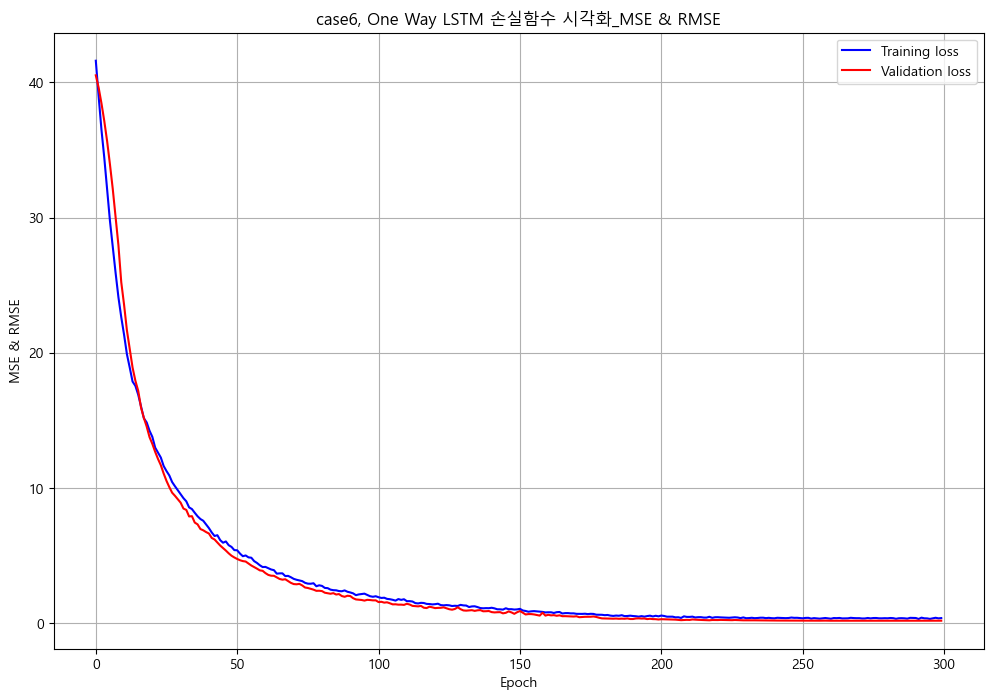

In [55]:
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = LSTM(128, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = LSTM(64, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case6_uni_rmse = Model(inputs=[numerical_input, categorical_input], outputs=output)
case6_uni_rmse.compile(optimizer=optimizer
                       , loss="mse"
                       , metrics=[metrics.RootMeanSquaredError()]
                      )

# 모델 학습
case6_uni_rmse_history = case6_uni_rmse.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case6_uni_rmse_history, "case6, One Way LSTM", "MSE & RMSE")

# 모델 저장
case6_uni_rmse.save("./output/case6/case6_uni_rmse.h5")

### 양방향 LSTM

Epoch 1/300
16/16 [==============================] - 6s 90ms/step - loss: 57.6608 - val_loss: 54.4640 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 17ms/step - loss: 51.2347 - val_loss: 48.4662 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 18ms/step - loss: 45.2879 - val_loss: 42.9133 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 18ms/step - loss: 39.7568 - val_loss: 37.7766 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 17ms/step - loss: 34.6621 - val_loss: 33.0761 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 17ms/step - loss: 30.0354 - val_loss: 28.7885 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 18ms/step - loss: 25.8739 - val_loss: 24.9287 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 17ms/step - loss: 22.0832 - val_loss: 21.4962 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

Epoch 137/300
13/16 [=======================>......] - ETA: 0s - loss: 1.0165
Epoch 137: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
16/16 [==============================] - 0s 17ms/step - loss: 1.0144 - val_loss: 0.8554 - lr: 1.2500e-04
Epoch 138/300
16/16 [==============================] - 0s 17ms/step - loss: 0.9963 - val_loss: 0.8152 - lr: 6.2500e-05
Epoch 139/300
16/16 [==============================] - 0s 17ms/step - loss: 0.9745 - val_loss: 0.8111 - lr: 6.2500e-05
Epoch 140/300
16/16 [==============================] - 0s 17ms/step - loss: 0.9695 - val_loss: 0.8605 - lr: 6.2500e-05
Epoch 141/300
16/16 [==============================] - 0s 17ms/step - loss: 0.9685 - val_loss: 0.8793 - lr: 6.2500e-05
Epoch 142/300
16/16 [==============================] - 0s 18ms/step - loss: 1.0105 - val_loss: 0.8157 - lr: 6.2500e-05
Epoch 143/300
16/16 [==============================] - 0s 17ms/step - loss: 0.9824 - val_loss: 0.7930 - lr: 6.2500e-05
Epoch 144/300
16/16 [=====

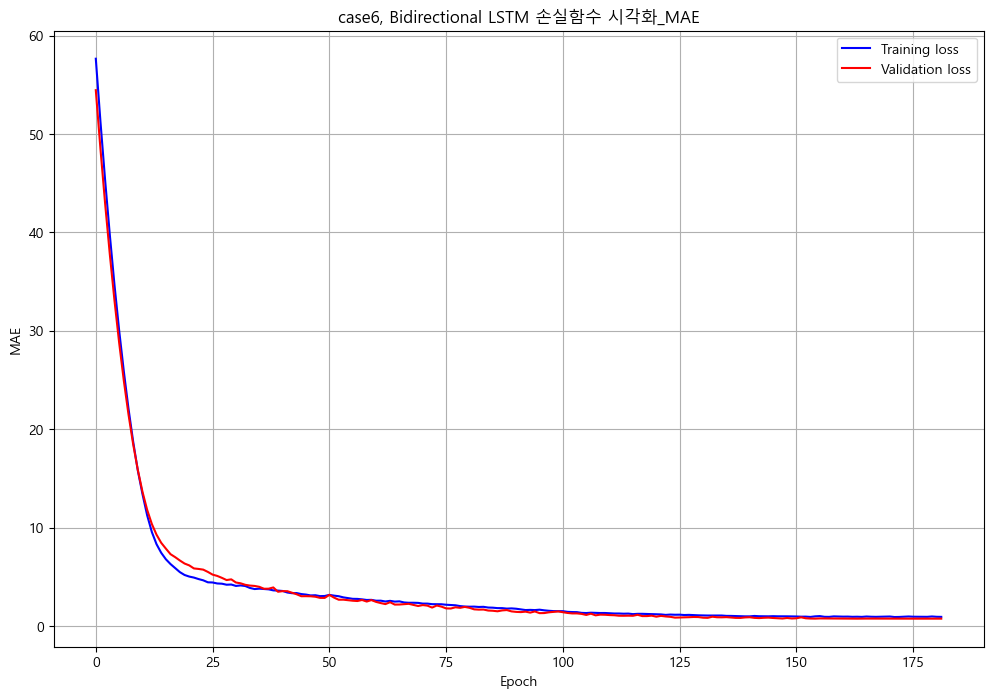

In [56]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention, Bidirectional
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = Bidirectional(LSTM(128, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case6_bi_mae = Model(inputs=[numerical_input, categorical_input], outputs=output)

case6_bi_mae.compile(optimizer=optimizer, loss="mae")

# 모델 학습
case6_bi_mae_history = case6_bi_mae.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case6_bi_mae_history, "case6, Bidirectional LSTM", "MAE")

# 모델 저장
case6_bi_mae.save("./output/case6/case6_bi_mae.h5")

Epoch 1/300
16/16 [==============================] - 8s 174ms/step - loss: 76.4819 - val_loss: 73.8078 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 17ms/step - loss: 73.1326 - val_loss: 71.9090 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 17ms/step - loss: 69.8842 - val_loss: 69.8670 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 17ms/step - loss: 66.5719 - val_loss: 67.6267 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 17ms/step - loss: 63.0850 - val_loss: 65.1995 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 18ms/step - loss: 59.5550 - val_loss: 62.8469 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 17ms/step - loss: 55.8574 - val_loss: 60.4787 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 17ms/step - loss: 52.3330 - val_loss: 57.9330 - lr: 5.0000e-04
Epoch 9/300
16/16 [============================

Epoch 70/300
16/16 [==============================] - 0s 19ms/step - loss: 4.2156 - val_loss: 3.9558 - lr: 5.0000e-04
Epoch 71/300
16/16 [==============================] - 0s 17ms/step - loss: 3.9895 - val_loss: 3.9106 - lr: 5.0000e-04
Epoch 72/300
16/16 [==============================] - 0s 17ms/step - loss: 3.7992 - val_loss: 3.5792 - lr: 5.0000e-04
Epoch 73/300
16/16 [==============================] - 0s 17ms/step - loss: 3.6172 - val_loss: 4.2168 - lr: 5.0000e-04
Epoch 74/300
16/16 [==============================] - 0s 17ms/step - loss: 3.7843 - val_loss: 3.7783 - lr: 5.0000e-04
Epoch 75/300
16/16 [==============================] - 0s 17ms/step - loss: 3.6628 - val_loss: 3.3750 - lr: 5.0000e-04
Epoch 76/300
16/16 [==============================] - 0s 17ms/step - loss: 3.5039 - val_loss: 3.4549 - lr: 5.0000e-04
Epoch 77/300
16/16 [==============================] - 0s 17ms/step - loss: 3.4040 - val_loss: 3.4562 - lr: 5.0000e-04
Epoch 78/300
16/16 [==============================] - 0s

Epoch 138/300
16/16 [==============================] - 0s 17ms/step - loss: 1.3383 - val_loss: 1.1087 - lr: 2.5000e-04
Epoch 139/300
16/16 [==============================] - 0s 17ms/step - loss: 1.2556 - val_loss: 1.0583 - lr: 2.5000e-04
Epoch 140/300
16/16 [==============================] - 0s 17ms/step - loss: 1.1616 - val_loss: 0.9534 - lr: 2.5000e-04
Epoch 141/300
16/16 [==============================] - 0s 17ms/step - loss: 1.2061 - val_loss: 0.9472 - lr: 2.5000e-04
Epoch 142/300
16/16 [==============================] - 0s 18ms/step - loss: 1.2281 - val_loss: 0.9285 - lr: 2.5000e-04
Epoch 143/300
16/16 [==============================] - 0s 17ms/step - loss: 1.2120 - val_loss: 0.9400 - lr: 2.5000e-04
Epoch 144/300
16/16 [==============================] - 0s 17ms/step - loss: 1.1395 - val_loss: 0.9078 - lr: 2.5000e-04
Epoch 145/300
16/16 [==============================] - 0s 17ms/step - loss: 1.1503 - val_loss: 0.8857 - lr: 2.5000e-04
Epoch 146/300
16/16 [===========================

Epoch 206/300
16/16 [==============================] - 0s 17ms/step - loss: 0.5552 - val_loss: 0.3592 - lr: 1.2500e-04
Epoch 207/300
16/16 [==============================] - 0s 17ms/step - loss: 0.5972 - val_loss: 0.3671 - lr: 1.2500e-04
Epoch 208/300
16/16 [==============================] - 0s 17ms/step - loss: 0.5449 - val_loss: 0.3605 - lr: 1.2500e-04
Epoch 209/300
16/16 [==============================] - 0s 17ms/step - loss: 0.6455 - val_loss: 0.3522 - lr: 1.2500e-04
Epoch 210/300
16/16 [==============================] - 0s 17ms/step - loss: 0.5614 - val_loss: 0.3996 - lr: 1.2500e-04
Epoch 211/300
16/16 [==============================] - 0s 18ms/step - loss: 0.6059 - val_loss: 0.3418 - lr: 1.2500e-04
Epoch 212/300
16/16 [==============================] - 0s 17ms/step - loss: 0.5802 - val_loss: 0.3361 - lr: 1.2500e-04
Epoch 213/300
16/16 [==============================] - 0s 17ms/step - loss: 0.5577 - val_loss: 0.3678 - lr: 1.2500e-04
Epoch 214/300
16/16 [===========================

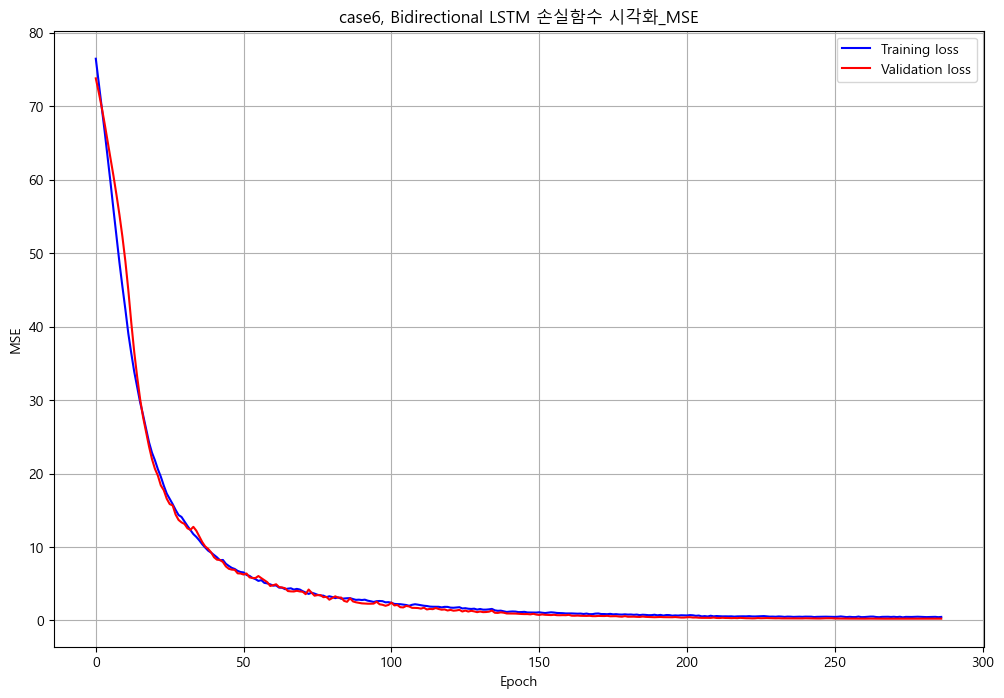

In [57]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention, Bidirectional
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = Bidirectional(LSTM(128, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case6_bi_mse = Model(inputs=[numerical_input, categorical_input], outputs=output)

case6_bi_mse.compile(optimizer=optimizer, loss="mse")

# 모델 학습
case6_bi_mse_history = case6_bi_mse.fit(  
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case6_bi_mse_history, "case6, Bidirectional LSTM", "MSE")

# 모델 저장
case6_bi_mse.save("./output/case6/case6_bi_mse.h5")

Epoch 1/300
16/16 [==============================] - 6s 91ms/step - loss: 73.7803 - root_mean_squared_error: 4.2350 - val_loss: 73.9068 - val_root_mean_squared_error: 4.3637 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 17ms/step - loss: 69.6817 - root_mean_squared_error: 3.9669 - val_loss: 71.4543 - val_root_mean_squared_error: 4.3091 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 17ms/step - loss: 65.6951 - root_mean_squared_error: 3.7122 - val_loss: 68.6302 - val_root_mean_squared_error: 4.2229 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 18ms/step - loss: 61.3506 - root_mean_squared_error: 3.3988 - val_loss: 65.4228 - val_root_mean_squared_error: 4.0939 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 17ms/step - loss: 57.3316 - root_mean_squared_error: 3.1085 - val_loss: 62.4151 - val_root_mean_squared_error: 3.9840 - lr: 5.0000e-04
Epoch 6/300
16/16 [==========================

Epoch 44/300
16/16 [==============================] - 0s 17ms/step - loss: 7.6398 - root_mean_squared_error: 0.9105 - val_loss: 7.4406 - val_root_mean_squared_error: 0.8582 - lr: 5.0000e-04
Epoch 45/300
16/16 [==============================] - 0s 17ms/step - loss: 7.3115 - root_mean_squared_error: 0.8618 - val_loss: 7.2233 - val_root_mean_squared_error: 0.8906 - lr: 5.0000e-04
Epoch 46/300
16/16 [==============================] - 0s 17ms/step - loss: 6.9894 - root_mean_squared_error: 0.8286 - val_loss: 6.9364 - val_root_mean_squared_error: 0.8701 - lr: 5.0000e-04
Epoch 47/300
16/16 [==============================] - 0s 17ms/step - loss: 6.6993 - root_mean_squared_error: 0.7985 - val_loss: 6.8378 - val_root_mean_squared_error: 0.9555 - lr: 5.0000e-04
Epoch 48/300
16/16 [==============================] - 0s 18ms/step - loss: 6.5717 - root_mean_squared_error: 0.8659 - val_loss: 6.6128 - val_root_mean_squared_error: 0.9405 - lr: 5.0000e-04
Epoch 49/300
16/16 [==============================

16/16 [==============================] - 0s 18ms/step - loss: 1.4862 - root_mean_squared_error: 0.6364 - val_loss: 1.2323 - val_root_mean_squared_error: 0.4206 - lr: 5.0000e-04
Epoch 131/300
16/16 [==============================] - 0s 17ms/step - loss: 1.5769 - root_mean_squared_error: 0.7320 - val_loss: 1.1933 - val_root_mean_squared_error: 0.4048 - lr: 5.0000e-04
Epoch 132/300
13/16 [=======================>......] - ETA: 0s - loss: 1.4022 - root_mean_squared_error: 0.6266
Epoch 132: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
16/16 [==============================] - 0s 17ms/step - loss: 1.4009 - root_mean_squared_error: 0.6313 - val_loss: 1.2106 - val_root_mean_squared_error: 0.4941 - lr: 5.0000e-04
Epoch 133/300
16/16 [==============================] - 0s 17ms/step - loss: 1.3626 - root_mean_squared_error: 0.6524 - val_loss: 1.1020 - val_root_mean_squared_error: 0.4351 - lr: 2.5000e-04
Epoch 134/300
16/16 [==============================] - 0s 17ms/step - loss

16/16 [==============================] - 0s 17ms/step - loss: 0.8131 - root_mean_squared_error: 0.5453 - val_loss: 0.6269 - val_root_mean_squared_error: 0.3307 - lr: 2.5000e-04
Epoch 173/300
16/16 [==============================] - 0s 17ms/step - loss: 0.8520 - root_mean_squared_error: 0.5855 - val_loss: 0.5866 - val_root_mean_squared_error: 0.2847 - lr: 2.5000e-04
Epoch 174/300
16/16 [==============================] - 0s 17ms/step - loss: 0.8194 - root_mean_squared_error: 0.5599 - val_loss: 0.6076 - val_root_mean_squared_error: 0.3254 - lr: 2.5000e-04
Epoch 175/300
16/16 [==============================] - 0s 18ms/step - loss: 0.8631 - root_mean_squared_error: 0.6061 - val_loss: 0.5530 - val_root_mean_squared_error: 0.2580 - lr: 2.5000e-04
Epoch 176/300
16/16 [==============================] - 0s 17ms/step - loss: 0.7917 - root_mean_squared_error: 0.5610 - val_loss: 0.5475 - val_root_mean_squared_error: 0.2832 - lr: 2.5000e-04
Epoch 177/300
16/16 [==============================] - 0s 1

Epoch 215/300
16/16 [==============================] - 0s 17ms/step - loss: 0.5705 - root_mean_squared_error: 0.5611 - val_loss: 0.3392 - val_root_mean_squared_error: 0.2809 - lr: 2.5000e-04
Epoch 216/300
16/16 [==============================] - 0s 17ms/step - loss: 0.5224 - root_mean_squared_error: 0.5120 - val_loss: 0.3412 - val_root_mean_squared_error: 0.2958 - lr: 2.5000e-04
Epoch 217/300
16/16 [==============================] - 0s 17ms/step - loss: 0.5099 - root_mean_squared_error: 0.5156 - val_loss: 0.3319 - val_root_mean_squared_error: 0.3099 - lr: 2.5000e-04
Epoch 218/300
16/16 [==============================] - 0s 17ms/step - loss: 0.5184 - root_mean_squared_error: 0.5343 - val_loss: 0.3233 - val_root_mean_squared_error: 0.2969 - lr: 2.5000e-04
Epoch 219/300
16/16 [==============================] - 0s 17ms/step - loss: 0.5433 - root_mean_squared_error: 0.5464 - val_loss: 0.3657 - val_root_mean_squared_error: 0.3386 - lr: 2.5000e-04
Epoch 220/300
16/16 [========================

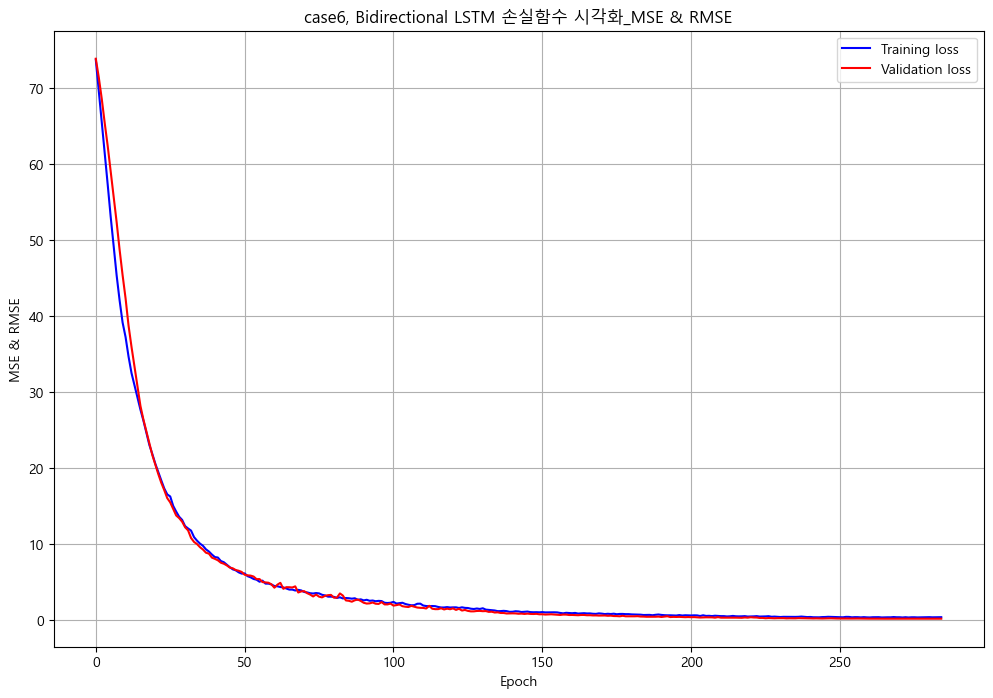

In [58]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention, Bidirectional
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = Bidirectional(LSTM(128, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case6_bi_rmse = Model(inputs=[numerical_input, categorical_input], outputs=output)

case6_bi_rmse.compile(optimizer=optimizer
                       , loss="mse"
                       , metrics=[metrics.RootMeanSquaredError()]
                      )

# 모델 학습
case6_bi_rmse_history = case6_bi_rmse.fit( 
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case6_bi_rmse_history, "case6, Bidirectional LSTM", "MSE & RMSE")

# 모델 저장
case6_bi_rmse.save("./output/case6/case6_bi_rmse.h5")

# 최종점검

## compare1: case1 & case2

### 모델 불러오기

In [ ]:
# case1
case1_uni_mae = tf.keras.models.load_model("./output/case1/case1_uni_mae.h5")
case1_uni_mse = tf.keras.models.load_model("./output/case1/case1_uni_mse.h5")
case1_uni_rmse = tf.keras.models.load_model("./output/case1/case1_uni_rmse.h5")

case1_bi_mae = tf.keras.models.load_model("./output/case1/case1_bi_mae.h5")
case1_bi_mse = tf.keras.models.load_model("./output/case1/case1_bi_mse.h5")
case1_bi_rmse = tf.keras.models.load_model("./output/case1/case1_bi_rmse.h5")

# case2
case2_uni_mae = tf.keras.models.load_model("./output/case2/case2_uni_mae.h5")
case2_uni_mse = tf.keras.models.load_model("./output/case2/case2_uni_mse.h5")
case2_uni_rmse = tf.keras.models.load_model("./output/case2/case2_uni_rmse.h5")

case2_bi_mae = tf.keras.models.load_model("./output/case2/case2_bi_mae.h5")
case2_bi_mse = tf.keras.models.load_model("./output/case2/case2_bi_mse.h5")
case2_bi_rmse = tf.keras.models.load_model("./output/case2/case2_bi_rmse.h5")

### 검증데이터 구성

In [19]:
compare1 = data[['WTIO', 'SETIO', 'ONI', 'SOI', 'ENSO', 'D20_SCTR']]
compare1_dts = compare1.values

compare1_label = compare1_dts[ : , 4]
compare1_dts = compare1_dts[ : , [0, 1, 2, 3, 5]]

# 타겟 데이터
Y_compare1 = compare1_dts[388 : 400, -1]

# 학습데이터
X_compare1 = compare1_dts[376 : 388, :]
X_compare1_label = np.reshape(compare1_label[376 : 388], (1, 12))

## 표준화
compare1_mean = X_compare1.mean(axis=0)
compare1_std = X_compare1.std(axis=0)
X_compare1_std = (X_compare1 - compare1_mean)/compare1_std
X_compare1_std = np.reshape(X_compare1_std, (1, 12, 5))

## 로그 변환
X_compare1_log = np.sign(X_compare1) * np.log1p(np.abs(X_compare1))
X_compare1_log = np.reshape(X_compare1_log, (1, 12, 5))

### 예측값 생성

In [30]:
# Case1
Y_HAT_case1_uni_mae = case1_uni_mae.predict([X_compare1_std, X_compare1_label])
Y_HAT_case1_uni_mae = Y_HAT_case1_uni_mae * compare1_std[-1] + compare1_mean[-1]

Y_HAT_case1_uni_mse = case1_uni_mse.predict([X_compare1_std, X_compare1_label])
Y_HAT_case1_uni_mse = Y_HAT_case1_uni_mse * compare1_std[-1] + compare1_mean[-1]

Y_HAT_case1_uni_rmse = case1_uni_rmse.predict([X_compare1_std, X_compare1_label])
Y_HAT_case1_uni_rmse = Y_HAT_case1_uni_rmse * compare1_std[-1] + compare1_mean[-1]

Y_HAT_case1_bi_mae = case1_bi_mae.predict([X_compare1_std, X_compare1_label])
Y_HAT_case1_bi_mae = Y_HAT_case1_bi_mae * compare1_std[-1] + compare1_mean[-1]

Y_HAT_case1_bi_mse = case1_bi_mse.predict([X_compare1_std, X_compare1_label])
Y_HAT_case1_bi_mse = Y_HAT_case1_bi_mse * compare1_std[-1] + compare1_mean[-1]

Y_HAT_case1_bi_rmse = case1_bi_rmse.predict([X_compare1_std, X_compare1_label])
Y_HAT_case1_bi_rmse = Y_HAT_case1_bi_rmse * compare1_std[-1] + compare1_mean[-1]

1/1 [==============================] - 1s 1s/step


In [25]:
# Case2
Y_HAT_case2_uni_mae = case2_uni_mae.predict([X_compare1_log, X_compare1_label])
Y_HAT_case2_uni_mae = np.sign(Y_HAT_case2_uni_mae) * (np.expm1(np.abs(Y_HAT_case2_uni_mae)))

Y_HAT_case2_uni_mse = case2_uni_mse.predict([X_compare1_log, X_compare1_label])
Y_HAT_case2_uni_mse = np.sign(Y_HAT_case2_uni_mse) * (np.expm1(np.abs(Y_HAT_case2_uni_mse)))

Y_HAT_case2_uni_rmse = case2_uni_rmse.predict([X_compare1_log, X_compare1_label])
Y_HAT_case2_uni_rmse = np.sign(Y_HAT_case2_uni_rmse) * (np.expm1(np.abs(Y_HAT_case2_uni_rmse)))

Y_HAT_case2_bi_mae = case2_bi_mae.predict([X_compare1_log, X_compare1_label])
Y_HAT_case2_bi_mae = np.sign(Y_HAT_case2_bi_mae) * (np.expm1(np.abs(Y_HAT_case2_bi_mae)))

Y_HAT_case2_bi_mse = case2_bi_mse.predict([X_compare1_log, X_compare1_label])
Y_HAT_case2_bi_mse = np.sign(Y_HAT_case2_bi_mse) * (np.expm1(np.abs(Y_HAT_case2_bi_mse)))

Y_HAT_case2_bi_rmse = case2_bi_rmse.predict([X_compare1_log, X_compare1_label])
Y_HAT_case2_bi_rmse = np.sign(Y_HAT_case2_bi_rmse) * (np.expm1(np.abs(Y_HAT_case2_bi_rmse)))

1/1 [==============================] - 0s 22ms/step


### 시각화

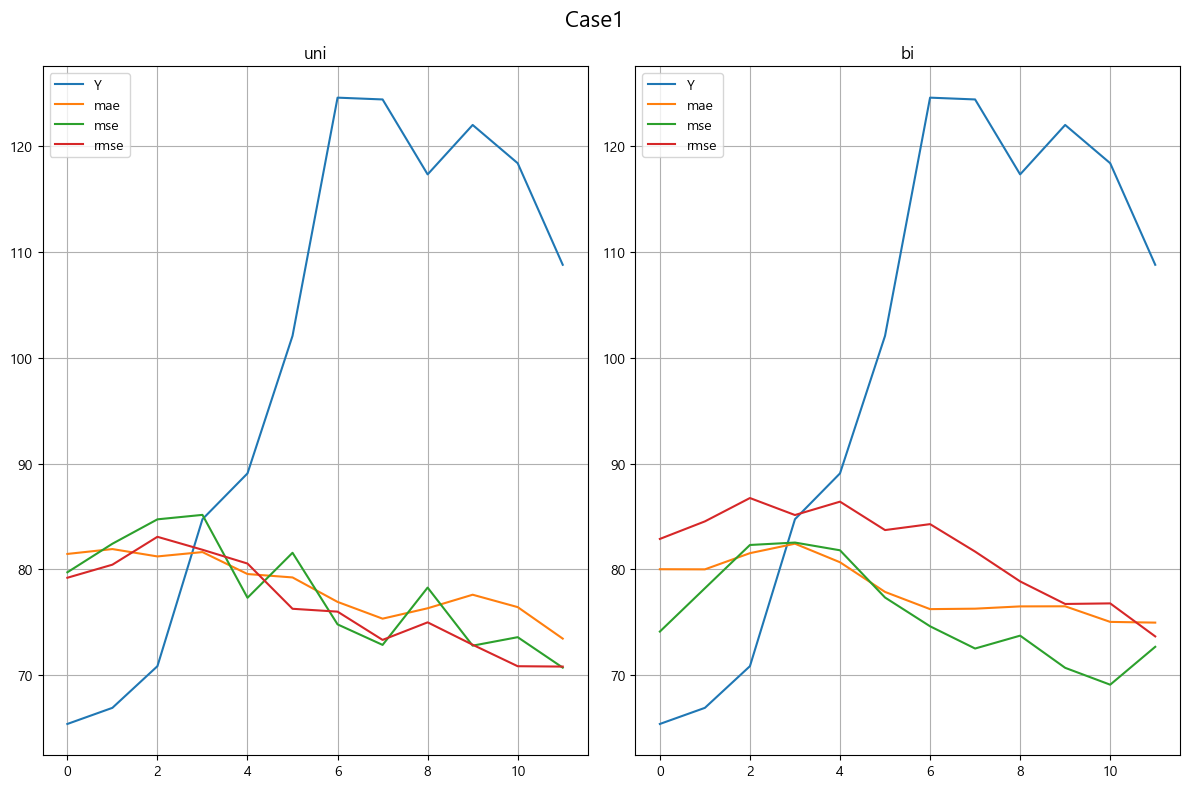

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].plot(Y_compare1, label="Y")
ax[0].plot(Y_HAT_case1_uni_mae[0], label="mae")
ax[0].plot(Y_HAT_case1_uni_mse[0], label="mse")
ax[0].plot(Y_HAT_case1_uni_rmse[0], label="rmse")
ax[0].set_title("uni", fontsize=12)
ax[0].grid()
ax[0].legend()

ax[1].plot(Y_compare1, label="Y")
ax[1].plot(Y_HAT_case1_bi_mae[0], label="mae")
ax[1].plot(Y_HAT_case1_bi_mse[0], label="mse")
ax[1].plot(Y_HAT_case1_bi_rmse[0], label="rmse")
ax[1].set_title("bi", fontsize=12)
ax[1].grid()
ax[1].legend()

plt.suptitle("Case1", fontsize=16)

plt.tight_layout()
plt.savefig(f'./output/case1_예측값.png')

plt.show()

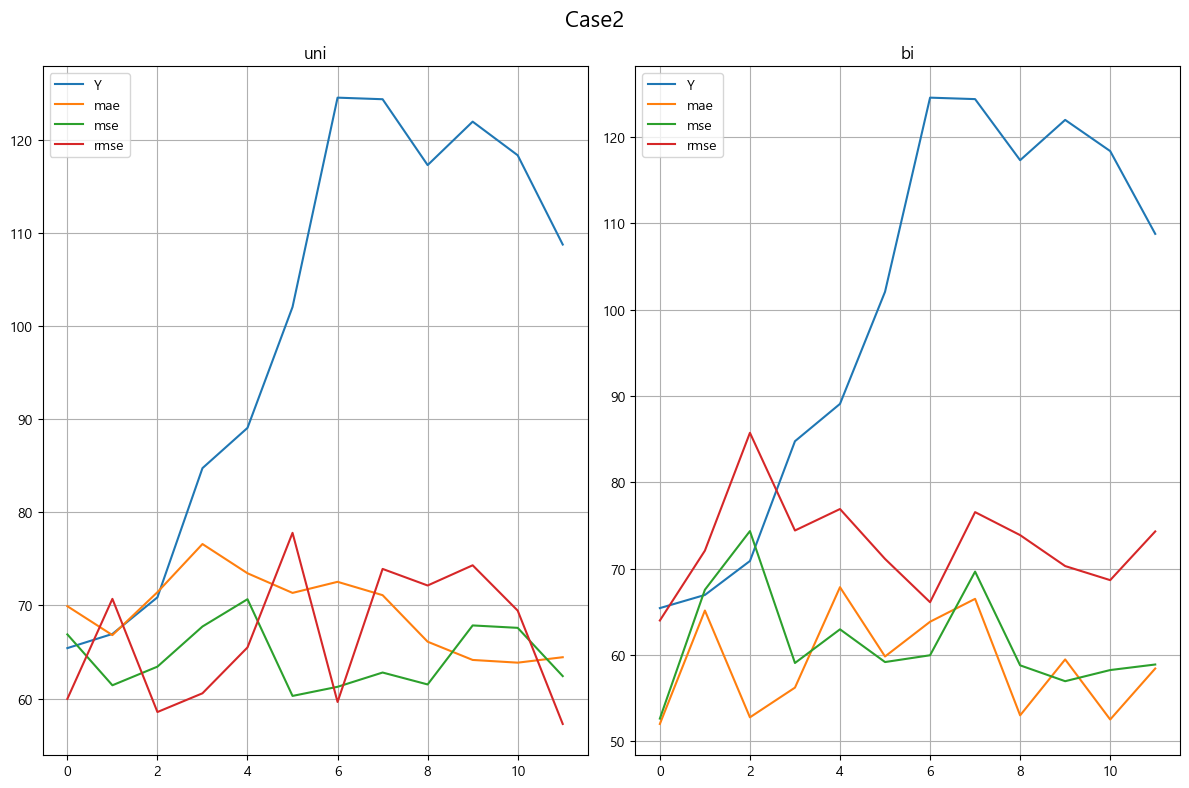

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].plot(Y_compare1, label="Y")
ax[0].plot(Y_HAT_case2_uni_mae[0], label="mae")
ax[0].plot(Y_HAT_case2_uni_mse[0], label="mse")
ax[0].plot(Y_HAT_case2_uni_rmse[0], label="rmse")
ax[0].set_title("uni", fontsize=12)
ax[0].grid()
ax[0].legend()

ax[1].plot(Y_compare1, label="Y")
ax[1].plot(Y_HAT_case2_bi_mae[0], label="mae")
ax[1].plot(Y_HAT_case2_bi_mse[0], label="mse")
ax[1].plot(Y_HAT_case2_bi_rmse[0], label="rmse")
ax[1].set_title("bi", fontsize=12)
ax[1].grid()
ax[1].legend()

plt.suptitle("Case2", fontsize=16)

plt.tight_layout()
plt.savefig(f'./output/case2_예측값.png')

plt.show()

## compare2: case3 & case4

### 모델 불러오기

In [ ]:
# case3
case3_uni_mae = tf.keras.models.load_model("./output/case3/case3_uni_mae.h5")
case3_uni_mse = tf.keras.models.load_model("./output/case3/case3_uni_mse.h5")
case3_uni_rmse = tf.keras.models.load_model("./output/case3/case3_uni_rmse.h5")

case3_bi_mae = tf.keras.models.load_model("./output/case3/case3_bi_mae.h5")
case3_bi_mse = tf.keras.models.load_model("./output/case3/case3_bi_mse.h5")
case3_bi_rmse = tf.keras.models.load_model("./output/case3/case3_bi_rmse.h5")

# case4
case4_uni_mae = tf.keras.models.load_model("./output/case4/case4_uni_mae.h5")
case4_uni_mse = tf.keras.models.load_model("./output/case4/case4_uni_mse.h5")
case4_uni_rmse = tf.keras.models.load_model("./output/case4/case4_uni_rmse.h5")

case4_bi_mae = tf.keras.models.load_model("./output/case4/case4_bi_mae.h5")
case4_bi_mse = tf.keras.models.load_model("./output/case4/case4_bi_mse.h5")
case4_bi_rmse = tf.keras.models.load_model("./output/case4/case4_bi_rmse.h5")

### 검증데이터 구성

In [36]:
compare2 = data[['DMI', 'ONI', 'SOI', 'ENSO', 'D20_SCTR']]
compare2_dts = compare2.values

compare2_label = compare2_dts[ : , 3]
compare2_dts = compare2_dts[ : , [0, 1, 2, 4]]

# 타겟 데이터
Y_compare2 = compare2_dts[388 : 400, -1]

# 학습데이터
X_compare2 = compare2_dts[376 : 388, :]
X_compare2_label = np.reshape(compare2_label[376 : 388], (1, 12))

## 표준화
compare2_mean = X_compare2.mean(axis=0)
compare2_std = X_compare2.std(axis=0)
X_compare2_std = (X_compare2 - compare2_mean)/compare2_std
X_compare2_std = np.reshape(X_compare2_std, (1, 12, 4))

## 로그 변환
X_compare2_log = np.sign(X_compare2) * np.log1p(np.abs(X_compare2))
X_compare2_log = np.reshape(X_compare2_log, (1, 12, 4))

### 예측값 생성

In [39]:
# Case3
Y_HAT_case3_uni_mae = case3_uni_mae.predict([X_compare2_std, X_compare2_label])
Y_HAT_case3_uni_mae = Y_HAT_case3_uni_mae * compare2_std[-1] + compare2_mean[-1]

Y_HAT_case3_uni_mse = case3_uni_mse.predict([X_compare2_std, X_compare2_label])
Y_HAT_case3_uni_mse = Y_HAT_case3_uni_mse * compare2_std[-1] + compare2_mean[-1]

Y_HAT_case3_uni_rmse = case3_uni_rmse.predict([X_compare2_std, X_compare2_label])
Y_HAT_case3_uni_rmse = Y_HAT_case3_uni_rmse * compare2_std[-1] + compare2_mean[-1]

Y_HAT_case3_bi_mae = case3_bi_mae.predict([X_compare2_std, X_compare2_label])
Y_HAT_case3_bi_mae = Y_HAT_case3_bi_mae * compare2_std[-1] + compare2_mean[-1]

Y_HAT_case3_bi_mse = case3_bi_mse.predict([X_compare2_std, X_compare2_label])
Y_HAT_case3_bi_mse = Y_HAT_case3_bi_mse * compare2_std[-1] + compare2_mean[-1]

Y_HAT_case3_bi_rmse = case3_bi_rmse.predict([X_compare2_std, X_compare2_label])
Y_HAT_case3_bi_rmse = Y_HAT_case3_bi_rmse * compare2_std[-1] + compare2_mean[-1]

1/1 [==============================] - 1s 1s/step


In [40]:
# Case4
Y_HAT_case4_uni_mae = case4_uni_mae.predict([X_compare2_log, X_compare2_label])
Y_HAT_case4_uni_mae = np.sign(Y_HAT_case4_uni_mae) * (np.expm1(np.abs(Y_HAT_case4_uni_mae)))

Y_HAT_case4_uni_mse = case4_uni_mse.predict([X_compare2_log, X_compare2_label])
Y_HAT_case4_uni_mse = np.sign(Y_HAT_case4_uni_mse) * (np.expm1(np.abs(Y_HAT_case4_uni_mse)))

Y_HAT_case4_uni_rmse = case4_uni_rmse.predict([X_compare2_log, X_compare2_label])
Y_HAT_case4_uni_rmse = np.sign(Y_HAT_case4_uni_rmse) * (np.expm1(np.abs(Y_HAT_case4_uni_rmse)))

Y_HAT_case4_bi_mae = case4_bi_mae.predict([X_compare2_log, X_compare2_label])
Y_HAT_case4_bi_mae = np.sign(Y_HAT_case4_bi_mae) * (np.expm1(np.abs(Y_HAT_case4_bi_mae)))

Y_HAT_case4_bi_mse = case4_bi_mse.predict([X_compare2_log, X_compare2_label])
Y_HAT_case4_bi_mse = np.sign(Y_HAT_case4_bi_mse) * (np.expm1(np.abs(Y_HAT_case4_bi_mse)))

Y_HAT_case4_bi_rmse = case4_bi_rmse.predict([X_compare2_log, X_compare2_label])
Y_HAT_case4_bi_rmse = np.sign(Y_HAT_case4_bi_rmse) * (np.expm1(np.abs(Y_HAT_case4_bi_rmse)))

1/1 [==============================] - 2s 2s/step


### 시각화

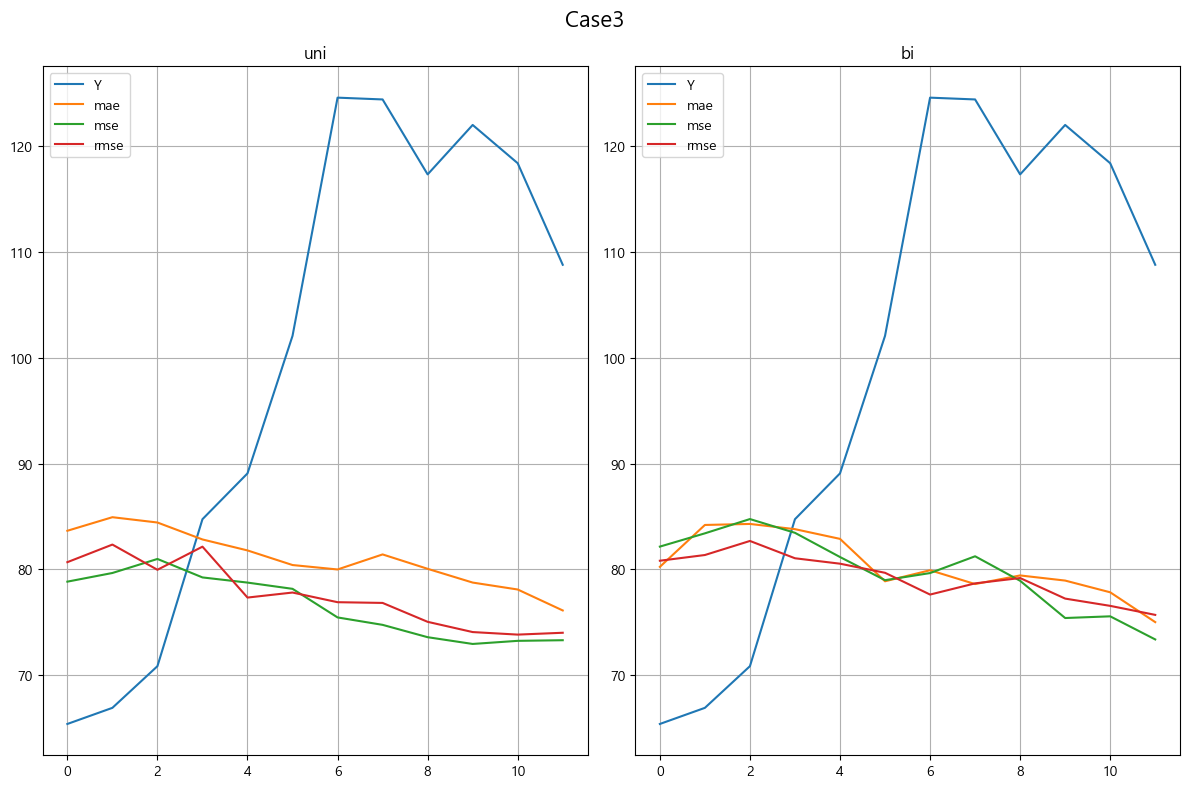

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].plot(Y_compare2, label="Y")
ax[0].plot(Y_HAT_case3_uni_mae[0], label="mae")
ax[0].plot(Y_HAT_case3_uni_mse[0], label="mse")
ax[0].plot(Y_HAT_case3_uni_rmse[0], label="rmse")
ax[0].set_title("uni", fontsize=12)
ax[0].grid()
ax[0].legend()

ax[1].plot(Y_compare2, label="Y")
ax[1].plot(Y_HAT_case3_bi_mae[0], label="mae")
ax[1].plot(Y_HAT_case3_bi_mse[0], label="mse")
ax[1].plot(Y_HAT_case3_bi_rmse[0], label="rmse")
ax[1].set_title("bi", fontsize=12)
ax[1].grid()
ax[1].legend()

plt.suptitle("Case3", fontsize=16)

plt.tight_layout()
plt.savefig(f'./output/case3_예측값.png')

plt.show()

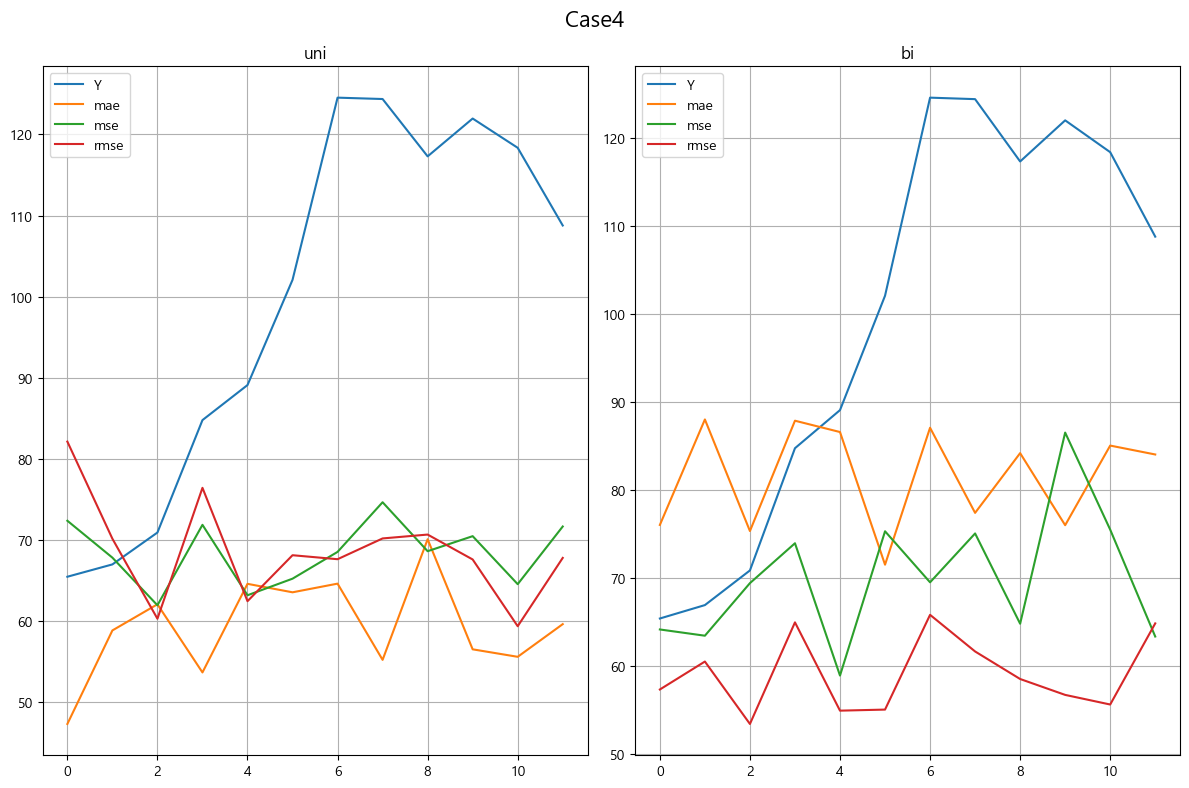

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].plot(Y_compare2, label="Y")
ax[0].plot(Y_HAT_case4_uni_mae[0], label="mae")
ax[0].plot(Y_HAT_case4_uni_mse[0], label="mse")
ax[0].plot(Y_HAT_case4_uni_rmse[0], label="rmse")
ax[0].set_title("uni", fontsize=12)
ax[0].grid()
ax[0].legend()

ax[1].plot(Y_compare2, label="Y")
ax[1].plot(Y_HAT_case4_bi_mae[0], label="mae")
ax[1].plot(Y_HAT_case4_bi_mse[0], label="mse")
ax[1].plot(Y_HAT_case4_bi_rmse[0], label="rmse")
ax[1].set_title("bi", fontsize=12)
ax[1].grid()
ax[1].legend()

plt.suptitle("Case4", fontsize=16)

plt.tight_layout()
plt.savefig(f'./output/case4_예측값.png')

plt.show()

## compare3: case5 & case6

### 모델 불러오기

In [57]:
# case5
case5_uni_mae = tf.keras.models.load_model("./output/case5/case5_uni_mae.h5")
case5_uni_mse = tf.keras.models.load_model("./output/case5/case5_uni_mse.h5")
case5_uni_rmse = tf.keras.models.load_model("./output/case5/case5_uni_rmse.h5")

case5_bi_mae = tf.keras.models.load_model("./output/case5/case5_bi_mae.h5")
case5_bi_mse = tf.keras.models.load_model("./output/case5/case5_bi_mse.h5")
case5_bi_rmse = tf.keras.models.load_model("./output/case5/case5_bi_rmse.h5")

# case6
case6_uni_mae = tf.keras.models.load_model("./output/case6/case6_uni_mae.h5")
case6_uni_mse = tf.keras.models.load_model("./output/case6/case6_uni_mse.h5")
case6_uni_rmse = tf.keras.models.load_model("./output/case6/case6_uni_rmse.h5")

case6_bi_mae = tf.keras.models.load_model("./output/case6/case6_bi_mae.h5")
case6_bi_mse = tf.keras.models.load_model("./output/case6/case6_bi_mse.h5")
case6_bi_rmse = tf.keras.models.load_model("./output/case6/case6_bi_rmse.h5")

### 검증데이터 구성

In [43]:
compare3 = data[['WTIO', 'SETIO', 'DMI', 'ONI', 'SOI', 'ENSO', 'D20_SCTR']]
compare3_dts = compare3.values

compare3_label = compare3_dts[ : , 5]
compare3_dts = compare3_dts[ : , [0, 1, 2, 3, 4, 6]]

# 타겟 데이터
Y_compare3 = compare3_dts[388 : 400, -1]

# 학습데이터
X_compare3 = compare3_dts[376 : 388, :]
X_compare3_label = np.reshape(compare3_label[376 : 388], (1, 12))

## 표준화
compare3_mean = X_compare3.mean(axis=0)
compare3_std = X_compare3.std(axis=0)
X_compare3_std = (X_compare3 - compare3_mean)/compare3_std
X_compare3_std = np.reshape(X_compare3_std, (1, 12, 6))

## 로그 변환
X_compare3_log = np.sign(X_compare3) * np.log1p(np.abs(X_compare3))
X_compare3_log = np.reshape(X_compare3_log, (1, 12, 6))

### 예측값 생성

In [58]:
# Case5
Y_HAT_case5_uni_mae = case5_uni_mae.predict([X_compare3_std, X_compare3_label])
Y_HAT_case5_uni_mae = Y_HAT_case5_uni_mae * compare3_std[-1] + compare3_mean[-1]

Y_HAT_case5_uni_mse = case5_uni_mse.predict([X_compare3_std, X_compare3_label])
Y_HAT_case5_uni_mse = Y_HAT_case3_uni_mse * compare3_std[-1] + compare3_mean[-1]

Y_HAT_case5_uni_rmse = case5_uni_rmse.predict([X_compare3_std, X_compare3_label])
Y_HAT_case5_uni_rmse = Y_HAT_case3_uni_rmse * compare3_std[-1] + compare3_mean[-1]

Y_HAT_case5_bi_mae = case5_bi_mae.predict([X_compare3_std, X_compare3_label])
Y_HAT_case5_bi_mae = Y_HAT_case5_bi_mae * compare3_std[-1] + compare3_mean[-1]

Y_HAT_case5_bi_mse = case5_bi_mse.predict([X_compare3_std, X_compare3_label])
Y_HAT_case5_bi_mse = Y_HAT_case5_bi_mse * compare3_std[-1] + compare3_mean[-1]

Y_HAT_case5_bi_rmse = case5_bi_rmse.predict([X_compare3_std, X_compare3_label])
Y_HAT_case5_bi_rmse = Y_HAT_case5_bi_rmse * compare3_std[-1] + compare3_mean[-1]

1/1 [==============================] - 1s 1s/step


In [59]:
# Case6
Y_HAT_case6_uni_mae = case6_uni_mae.predict([X_compare3_log, X_compare3_label])
Y_HAT_case6_uni_mae = np.sign(Y_HAT_case6_uni_mae) * (np.expm1(np.abs(Y_HAT_case6_uni_mae)))

Y_HAT_case6_uni_mse = case6_uni_mse.predict([X_compare3_log, X_compare3_label])
Y_HAT_case6_uni_mse = np.sign(Y_HAT_case6_uni_mse) * (np.expm1(np.abs(Y_HAT_case6_uni_mse)))

Y_HAT_case6_uni_rmse = case6_uni_rmse.predict([X_compare3_log, X_compare3_label])
Y_HAT_case6_uni_rmse = np.sign(Y_HAT_case6_uni_rmse) * (np.expm1(np.abs(Y_HAT_case6_uni_rmse)))

Y_HAT_case6_bi_mae = case6_bi_mae.predict([X_compare3_log, X_compare3_label])
Y_HAT_case6_bi_mae = np.sign(Y_HAT_case6_bi_mae) * (np.expm1(np.abs(Y_HAT_case6_bi_mae)))

Y_HAT_case6_bi_mse = case6_bi_mse.predict([X_compare3_log, X_compare3_label])
Y_HAT_case6_bi_mse = np.sign(Y_HAT_case6_bi_mse) * (np.expm1(np.abs(Y_HAT_case6_bi_mse)))

Y_HAT_case6_bi_rmse = case6_bi_rmse.predict([X_compare3_log, X_compare3_label])
Y_HAT_case6_bi_rmse = np.sign(Y_HAT_case6_bi_rmse) * (np.expm1(np.abs(Y_HAT_case6_bi_rmse)))

1/1 [==============================] - 2s 2s/step


### 시각화

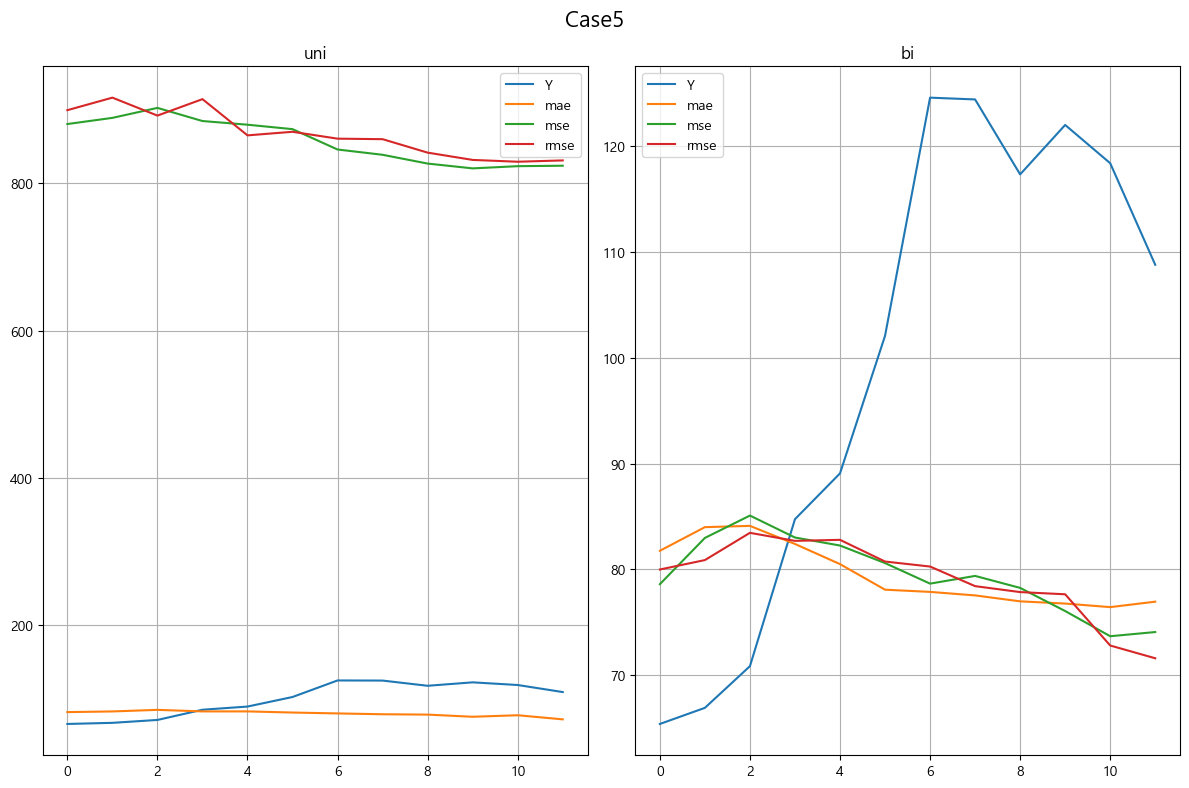

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].plot(Y_compare3, label="Y")
ax[0].plot(Y_HAT_case5_uni_mae[0], label="mae")
ax[0].plot(Y_HAT_case5_uni_mse[0], label="mse")
ax[0].plot(Y_HAT_case5_uni_rmse[0], label="rmse")
ax[0].set_title("uni", fontsize=12)
ax[0].grid()
ax[0].legend()

ax[1].plot(Y_compare3, label="Y")
ax[1].plot(Y_HAT_case5_bi_mae[0], label="mae")
ax[1].plot(Y_HAT_case5_bi_mse[0], label="mse")
ax[1].plot(Y_HAT_case5_bi_rmse[0], label="rmse")
ax[1].set_title("bi", fontsize=12)
ax[1].grid()
ax[1].legend()

plt.suptitle("Case5", fontsize=16)

plt.tight_layout()
plt.savefig(f'./output/case5_예측값.png')

plt.show()

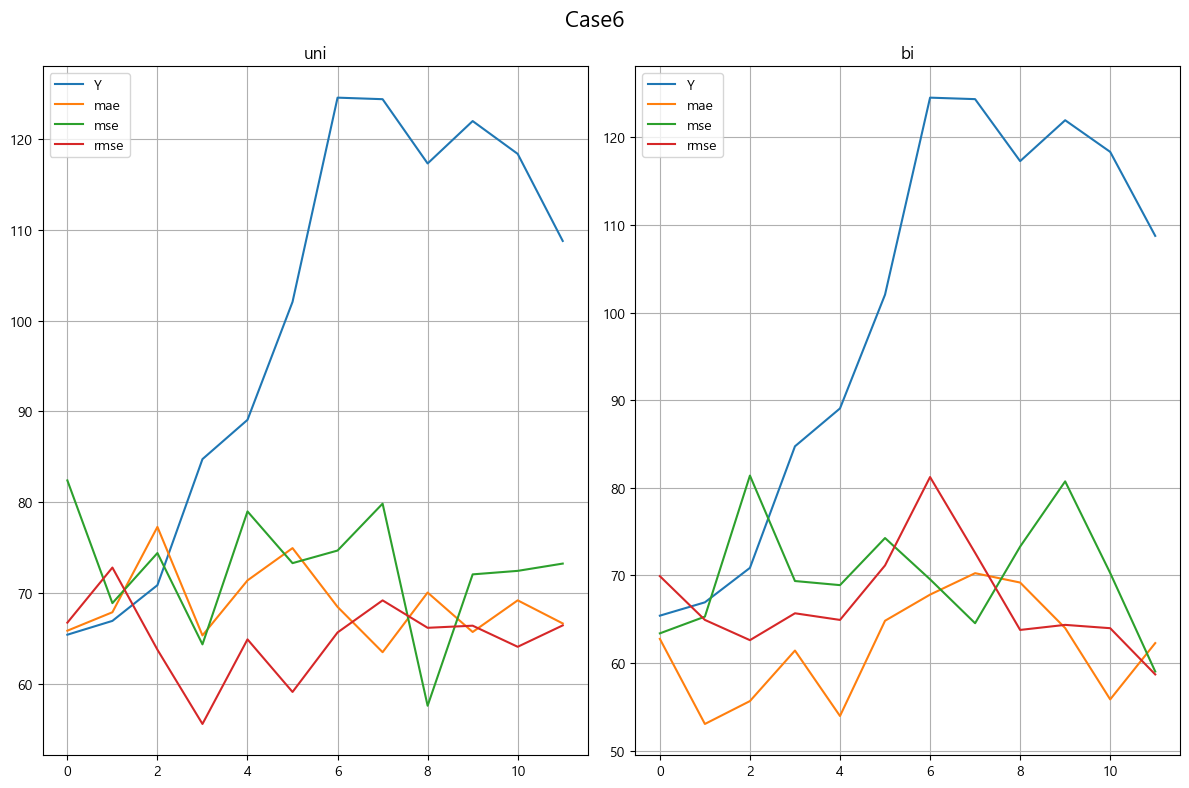

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].plot(Y_compare3, label="Y")
ax[0].plot(Y_HAT_case6_uni_mae[0], label="mae")
ax[0].plot(Y_HAT_case6_uni_mse[0], label="mse")
ax[0].plot(Y_HAT_case6_uni_rmse[0], label="rmse")
ax[0].set_title("uni", fontsize=12)
ax[0].grid()
ax[0].legend()

ax[1].plot(Y_compare3, label="Y")
ax[1].plot(Y_HAT_case6_bi_mae[0], label="mae")
ax[1].plot(Y_HAT_case6_bi_mse[0], label="mse")
ax[1].plot(Y_HAT_case6_bi_rmse[0], label="rmse")
ax[1].set_title("bi", fontsize=12)
ax[1].grid()
ax[1].legend()

plt.suptitle("Case6", fontsize=16)

plt.tight_layout()
plt.savefig(f'./output/case6_예측값.png')

plt.show()